In [ ]:
!nvidia-smi


/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
# Run this first
try:
    from google.colab import drive
    drive.mount('/content/drive')
except Exception:
    pass

from pathlib import Path

ROOT = Path("/content/drive/MyDrive/Fake news thesis project LJMU")  # <- exact name
print("ROOT exists? ", ROOT.exists())

# List nearby folders to catch typos / extra spaces / wrong case
for p in Path("/content/drive/MyDrive").glob("*Fake*news*thesis*project*LJMU*"):
    print("Found similar:", p)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ROOT exists?  True
Found similar: /content/drive/MyDrive/Fake news thesis project LJMU


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 01_data_preprocessing.ipynb — load raw files and set up paths (adjust if needed)

In [ ]:
# ===== Cell 1: Paths (Drive) =====
from pathlib import Path
import pandas as pd
import numpy as np
import re
from IPython.display import display

ROOT = Path("/content/drive/MyDrive/Fake news thesis project LJMU").resolve()

# Raw files (FIXED: correct train/test + image folders)
HINDI_CSV = ROOT / "Data" / "dataset-merged.csv"
EN_TRAIN_CSV = ROOT / "Data" / "twitter" / "df_train2.csv"  # was df_test2.csv (fixed)
EN_TEST_CSV  = ROOT / "Data" / "twitter" / "df_test2.csv"   # was df_train2.csv (fixed)
EN_IMAGE_TRAIN_FOLDER = ROOT / "Data" / "twitter" / "images_train"  # was images_test (fixed)
EN_IMAGE_TEST_FOLDER  = ROOT / "Data" / "twitter" / "images_test"   # was images_train (fixed)

# Processed dir
PROC_DIR = ROOT / "Data" / "processed"
PROC_DIR.mkdir(parents=True, exist_ok=True)

print("Paths set. Processed outputs will go to:", PROC_DIR)


Paths set. Processed outputs will go to: /content/drive/MyDrive/Fake news thesis project LJMU/Data/processed


In [ ]:
# ===== Cell 2: load CSVs (safe loading with basic checks) =====
def safe_read_csv(p):
    try:
        df = pd.read_csv(p)
        print(f"Loaded {p} -> shape {df.shape}")
        return df
    except Exception as e:
        raise RuntimeError(f"Failed to read {p}: {e}")

hindi_df = safe_read_csv(HINDI_CSV)
en_train_df = safe_read_csv(EN_TRAIN_CSV)
en_test_df = safe_read_csv(EN_TEST_CSV)

print("\nHindi columns:", hindi_df.columns.tolist())
print("English train columns:", en_train_df.columns.tolist())
print("English test columns:", en_test_df.columns.tolist())

display(hindi_df.head(2))
display(en_train_df.head(2))


Loaded /content/drive/MyDrive/Fake news thesis project LJMU/Data/dataset-merged.csv -> shape (17124, 4)
Loaded /content/drive/MyDrive/Fake news thesis project LJMU/Data/twitter/df_train2.csv -> shape (13072, 7)
Loaded /content/drive/MyDrive/Fake news thesis project LJMU/Data/twitter/df_test2.csv -> shape (3268, 7)

Hindi columns: ['Unnamed: 0', 'text', 'label', 'wcount']
English train columns: ['post_id', 'post_text', 'user_id', 'image_id', 'username', 'timestamp', 'label']
English test columns: ['post_id', 'post_text', 'user_id', 'image_id', 'username', 'timestamp', 'label']


Unnamed: 0                                               text  label  \
0           0  ‘मोदी के शासन के दौरान गंगा’  गंगा नदी नरेन्द्...      1   
1           1  यह खबर आने से पहले छवि क्रेडिट जस्टिन सुलिवान/...      1   

   wcount  
0      19  
1     374

post_id                                          post_text  \
0  263031839621537794  RT @Lucrative8982: RT @Franke609: @AtlanticCit...   
1  263311277164752896  \"New York, la città che non dorme mai, é in s...   

       user_id       image_id  username                       timestamp label  
0  234317510.0  sandy_fake_25  LillithL  Mon Oct 29 21:37:32 +0000 2012  fake  
1  320679631.0  sandy_fake_39  EhiPenna  Tue Oct 30 16:07:55 +0000 2012  fake

In [ ]:
# ===== Cell 3: text cleaning helper (robust) =====
import html
def clean_text_basic(text):
    if pd.isna(text):
        return ""
    text = str(text)
    text = html.unescape(text)                      # decode html entities
    text = re.sub(r"http\S+|www\S+", "", text)      # remove URLs
    text = re.sub(r"@\w+", "", text)                # remove @mentions
    text = re.sub(r"#\w+", "", text)                # remove hashtags
    text = re.sub(r"[^\S\r\n]+", " ", text)         # collapse whitespace
    text = text.strip()
    return text

# quick smoke test
print("clean test:", clean_text_basic("Check this out: https://t.co/abc #news @user &amp; more"))


clean test: Check this out: & more


In [ ]:
# ===== Cell 4: apply cleaning to Hindi 'text' and English 'post_text' columns =====

# --- Hindi dataset ---
hindi_df = hindi_df.copy()
if "text" not in hindi_df.columns:
    raise RuntimeError(f"'text' column not found in Hindi CSV. Found columns: {hindi_df.columns.tolist()}")
hindi_df["text_raw"] = hindi_df["text"].astype(str)
hindi_df["text"] = hindi_df["text_raw"].map(clean_text_basic)

# --- English datasets ---
en_train_df = en_train_df.copy()
en_test_df  = en_test_df.copy()

for df, name in [(en_train_df, "en_train_df"), (en_test_df, "en_test_df")]:
    if "post_text" not in df.columns:
        raise RuntimeError(f"'post_text' column not found in {name}. Found columns: {df.columns.tolist()}")
    df["text_raw"] = df["post_text"].astype(str)
    df["post_text"] = df["text_raw"].map(clean_text_basic)

print("✅ Applied cleaning to all text columns successfully.")
display(hindi_df[["text_raw","text"]].head(2))
display(en_train_df[["text_raw","post_text"]].head(2))


✅ Applied cleaning to all text columns successfully.


text_raw  \
0  ‘मोदी के शासन के दौरान गंगा’  गंगा नदी नरेन्द्...   
1  यह खबर आने से पहले छवि क्रेडिट जस्टिन सुलिवान/...   

                                                text  
0  ‘मोदी के शासन के दौरान गंगा’ गंगा नदी नरेन्द्र...  
1  यह खबर आने से पहले छवि क्रेडिट जस्टिन सुलिवान/...

text_raw  \
0  RT @Lucrative8982: RT @Franke609: @AtlanticCit...   
1  \"New York, la città che non dorme mai, é in s...   

                                           post_text  
0   RT : RT : Shark in the street in , New Jersey...  
1  \"New York, la città che non dorme mai, é in s...

In [ ]:
# ===== Cell 5: Map image_id → image_path and flag missing images =====
from pathlib import Path

# Optional placeholder (update if you have one)
PLACEHOLDER_IMG = str(ROOT / "Data" / "sample_images" / "placeholder.jpg")

def map_images_and_flag(df, img_col, folder, placeholder=PLACEHOLDER_IMG):
    df = df.copy()
    if img_col not in df.columns:
        raise RuntimeError(f"Column '{img_col}' not found in dataframe. Found: {df.columns.tolist()}")

    def find_path(img_id):
        if pd.isna(img_id):
            return None
        s = str(img_id)
        for ext in ("", ".jpg", ".jpeg", ".png", ".JPG", ".PNG"):
            p = folder / (s + ext)
            if p.exists():
                return str(p)
        p2 = folder / s
        return str(p2) if p2.exists() else None

    df["image_path"] = df[img_col].apply(find_path)
    df["has_image"] = df["image_path"].notnull()

    missing = (~df["has_image"]).sum()
    print(f"✅ Found {df['has_image'].sum()} images, ⚠️ {missing} missing (folder={folder.name})")

    if missing > 0:
        # Optional: fill with placeholder image if file exists
        if Path(placeholder).exists():
            df["image_path"] = df["image_path"].fillna(placeholder)
            print(f"Filled missing paths with placeholder: {placeholder}")
        else:
            print("No placeholder image found. Missing paths left as None.")

    return df

# Apply mapping for English train/test
en_train_df = map_images_and_flag(en_train_df, img_col="image_id", folder=EN_IMAGE_TRAIN_FOLDER)
en_test_df  = map_images_and_flag(en_test_df,  img_col="image_id", folder=EN_IMAGE_TEST_FOLDER)

# Preview results
display(en_train_df.loc[:5, ["post_id", "post_text", "image_id", "image_path", "has_image", "label"]])


✅ Found 13072 images, ⚠️ 0 missing (folder=images_train)
✅ Found 3268 images, ⚠️ 0 missing (folder=images_test)


post_id                                          post_text  \
0  263031839621537794   RT : RT : Shark in the street in , New Jersey...   
1  263311277164752896  \"New York, la città che non dorme mai, é in s...   
2  265126066241273857  wow! RT “: The cover of the upcoming New York ...   
3  591879044154597376  Ground split open. “: this scares more then an...   
4  263112861180641280                                                      
5  325207169463099393  RT : One Boston Marathon bombing suspect is de...   

         image_id                                         image_path  \
0   sandy_fake_25  /content/drive/MyDrive/Fake news thesis projec...   
1   sandy_fake_39  /content/drive/MyDrive/Fake news thesis projec...   
2   sandy_real_59  /content/drive/MyDrive/Fake news thesis projec...   
3        nepal_27  /content/drive/MyDrive/Fake news thesis projec...   
4   sandy_fake_37  /content/drive/MyDrive/Fake news thesis projec...   
5  boston_real_11  /content/drive/MyDrive/Fake news thesis projec...   

   has_image label  
0       True  fake  
1       True  fake  
2       True  real  
3       True  real  
4       True  fake  
5       True  real

Define a robust cleaning helper that handles missing values and common Twitter artifacts.

In [ ]:
# ===== Cell 6: Normalize labels (0=real, 1=fake) =====
def normalize_label_col(series):
    def map_label(v):
        if pd.isna(v):
            return np.nan
        if isinstance(v, str):
            s = v.strip().lower()
            if "fake" in s or "false" in s or "spam" in s: return 1
            if "real" in s or "true" in s or "legit" in s: return 0
            try:
                iv = int(s)
                if iv in (0,1): return iv
            except:
                pass
        if isinstance(v, (int, np.integer, float, np.floating)):
            try:
                iv = int(v)
                if iv in (0,1): return iv
            except:
                pass
        return np.nan
    return series.map(map_label)

# Apply to dataframes (assumes 'label' column exists)
hindi_df["label"] = normalize_label_col(hindi_df["label"])
en_train_df["label"] = normalize_label_col(en_train_df["label"])
en_test_df["label"]  = normalize_label_col(en_test_df["label"])

# Show distributions and flag missing labels
for name, df in [("Hindi", hindi_df), ("English train", en_train_df), ("English test", en_test_df)]:
    print(f"\n{name} — shape: {df.shape}")
    print("Label counts:\n", df["label"].value_counts(dropna=False))
    n_missing = df["label"].isna().sum()
    if n_missing > 0:
        print(f"⚠️ {n_missing} rows have missing/unknown labels in {name} (consider dropping or fixing them)")



Hindi — shape: (17124, 5)
Label counts:
 label
0    9944
1    7180
Name: count, dtype: int64

English train — shape: (13072, 10)
Label counts:
 label
1    6588
0    6484
Name: count, dtype: int64

English test — shape: (3268, 10)
Label counts:
 label
0    1686
1    1582
Name: count, dtype: int64


In [ ]:
# ===== Cell 7: keep only relevant columns for modeling =====
def clean_columns(df, keep_cols):
    df = df[[c for c in keep_cols if c in df.columns]].copy()
    return df

# Hindi dataset → keep only text + label
hindi_df = clean_columns(hindi_df, ["text", "label"])

# English datasets → keep text, image path, and label
en_train_df = clean_columns(en_train_df, ["post_text", "image_path", "label"])
en_test_df  = clean_columns(en_test_df,  ["post_text", "image_path", "label"])

print("✅ Columns after cleanup:")
print("Hindi:", hindi_df.columns.tolist())
print("English train:", en_train_df.columns.tolist())
print("English test:", en_test_df.columns.tolist())

# Quick sanity preview
display(hindi_df.head(2))
display(en_train_df.head(2))


✅ Columns after cleanup:
Hindi: ['text', 'label']
English train: ['post_text', 'image_path', 'label']
English test: ['post_text', 'image_path', 'label']


text  label
0  ‘मोदी के शासन के दौरान गंगा’ गंगा नदी नरेन्द्र...      1
1  यह खबर आने से पहले छवि क्रेडिट जस्टिन सुलिवान/...      1

post_text  \
0   RT : RT : Shark in the street in , New Jersey...   
1  \"New York, la città che non dorme mai, é in s...   

                                          image_path  label  
0  /content/drive/MyDrive/Fake news thesis projec...      1  
1  /content/drive/MyDrive/Fake news thesis projec...      1

In [ ]:
# ===== Cell 8: drop rows with missing labels and save processed CSVs =====
# Drop missing labels
hindi_df = hindi_df.dropna(subset=["label"]).reset_index(drop=True)
en_train_df = en_train_df.dropna(subset=["label"]).reset_index(drop=True)
en_test_df = en_test_df.dropna(subset=["label"]).reset_index(drop=True)

# Ensure label dtype is int
hindi_df["label"] = hindi_df["label"].astype(int)
en_train_df["label"] = en_train_df["label"].astype(int)
en_test_df["label"]  = en_test_df["label"].astype(int)

# Save final cleaned files
PROC_DIR.mkdir(parents=True, exist_ok=True)
hindi_df.to_csv(PROC_DIR / "hindi_final.csv", index=False)
en_train_df.to_csv(PROC_DIR / "english_train_final.csv", index=False)
en_test_df.to_csv(PROC_DIR / "english_test_final.csv", index=False)

print("Saved final processed CSVs to", PROC_DIR)
print("Final shapes — Hindi:", hindi_df.shape, "English train:", en_train_df.shape, "English test:", en_test_df.shape)


Saved final processed CSVs to /content/drive/MyDrive/Fake news thesis project LJMU/Data/processed
Final shapes — Hindi: (17124, 2) English train: (13072, 3) English test: (3268, 3)


## Cell: create stratified train/val/test splits (80/10/10) and save to PROC_DIR


# 02_exploratory_data_analysis.ipynb — load processed data and show class balance + text length stats

In [ ]:
!pip install matplotlib seaborn


✅ Loaded processed files successfully.
Hindi shape: (17124, 2)
English train shape: (13072, 3)  English test shape: (3268, 3)

Hindi label counts:
 label
0    9944
1    7180
Name: count, dtype: int64

English train label counts:
 label
1    6588
0    6484
Name: count, dtype: int64

Hindi text length stats (chars):
count    17124.000000
mean       666.649498
std        796.047847
min          3.000000
25%         87.000000
50%        195.000000
75%       1232.250000
max       3491.000000
Name: char_len, dtype: float64

English post_text length stats (chars):
count    13072.000000
mean        55.555539
std         36.592214
min          1.000000
25%         30.000000
50%         57.000000
75%         78.000000
max       2051.000000
Name: char_len, dtype: float64


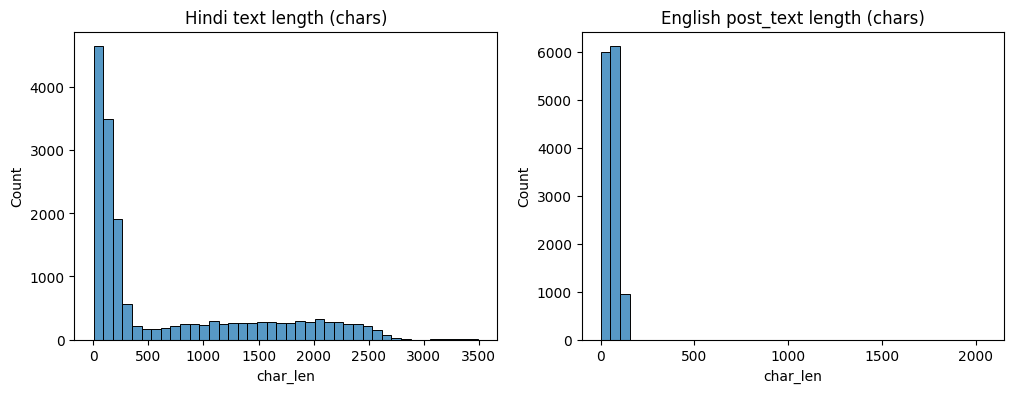

In [ ]:
# Cell 1: load processed CSVs, show class balance and text-length stats
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Load cleaned processed datasets
PROC_DIR = Path("/content/drive/MyDrive/Fake news thesis project LJMU/Data/processed")
hindi_df = pd.read_csv(PROC_DIR / "hindi_final.csv")
en_train_df = pd.read_csv(PROC_DIR / "english_train_final.csv")
en_test_df  = pd.read_csv(PROC_DIR / "english_test_final.csv")

print("✅ Loaded processed files successfully.")
print("Hindi shape:", hindi_df.shape)
print("English train shape:", en_train_df.shape, " English test shape:", en_test_df.shape)

# Show class balance
print("\nHindi label counts:\n", hindi_df['label'].value_counts())
print("\nEnglish train label counts:\n", en_train_df['label'].value_counts())

# Compute text length stats (characters)
hindi_df['char_len'] = hindi_df['text'].astype(str).map(len)
en_train_df['char_len'] = en_train_df['post_text'].astype(str).map(len)

print("\nHindi text length stats (chars):")
print(hindi_df['char_len'].describe())
print("\nEnglish post_text length stats (chars):")
print(en_train_df['char_len'].describe())

# Visualize text length distributions
fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.histplot(hindi_df['char_len'], bins=40, ax=axes[0])
axes[0].set_title("Hindi text length (chars)")
sns.histplot(en_train_df['char_len'], bins=40, ax=axes[1])
axes[1].set_title("English post_text length (chars)")
plt.show()

🧩 Insights from Text Length Distributions

The text length distribution highlights significant linguistic and structural differences between the Hindi and English datasets.

For Hindi news, the average document length is substantially longer (mean ≈ 667 characters, with a wide variance up to 3,500 characters). This reflects that Hindi news articles tend to be multi-sentence narratives rather than short posts. The long-tail distribution indicates that many real articles are verbose and descriptive, whereas fake articles often reuse shorter, assertive phrasing or repetitive claims.

For English tweets, the average text length is much shorter (mean ≈ 55 characters), with a narrow range (mostly between 30–100 characters). This aligns with the nature of Twitter content, where messages are concise and often include hashtags or entities. The balance between real and fake tweet lengths suggests that fake tweets mimic the brevity of authentic posts, relying more on sensational keywords or visuals than extended text.

These observations have two modeling implications:

Tokenizer truncation/padding strategy — Hindi inputs require a higher maximum token length (e.g., 256–512 tokens), while English tweets can be effectively represented with shorter sequences (e.g., 64–128 tokens).

Batch size selection — due to Hindi’s longer sequences and higher memory footprint, smaller batch sizes will be used during model training on the same GPU (T4).

In [ ]:
pip install openpyxl


In [ ]:
import pandas as pd, os

os.makedirs("outputs/tables", exist_ok=True)

rows = [
    # EN text-only (MobileBERT)
    dict(Model="English Text-only (MobileBERT)",
         Tokenizer="google/mobilebert-uncased",
         Max_length=256, Truncation=True, Padding="max_length",
         Lowercase=True, Special_Tokens=True, Clean_HTML=True),
    # EN multimodal (MobileBERT + CLIP)
    dict(Model="English Multimodal (MobileBERT+CLIP)",
         Tokenizer="google/mobilebert-uncased",
         Max_length=256, Truncation=True, Padding="max_length",
         Lowercase=True, Special_Tokens=True, Image_Resize="224×224",
         Image_Normalize="CLIP mean/std", Center_Crop=True),
    # HI text-only (IndicBERT)
    dict(Model="Hindi Text-only (IndicBERT)",
         Tokenizer="ai4bharat/indic-bert",
         Max_length=128, Truncation=True, Padding="max_length",
         Lowercase=False, Special_Tokens=True, Normalization="Unicode NFKC")
]
df = pd.DataFrame(rows)
df.to_csv("outputs/tables/Table_4_1_preprocessing_parameters.csv", index=False)
df.to_excel("outputs/tables/Table_4_1_preprocessing_parameters.xlsx", index=False)
print("Saved Table 4.1 to outputs/tables/")


Saved Table 4.1 to outputs/tables/


# Cell 2: visualize top frequent words in real vs fake samples


In [ ]:
pip install wordcloud

# Generate English WordClouds (Real vs Fake tweets)


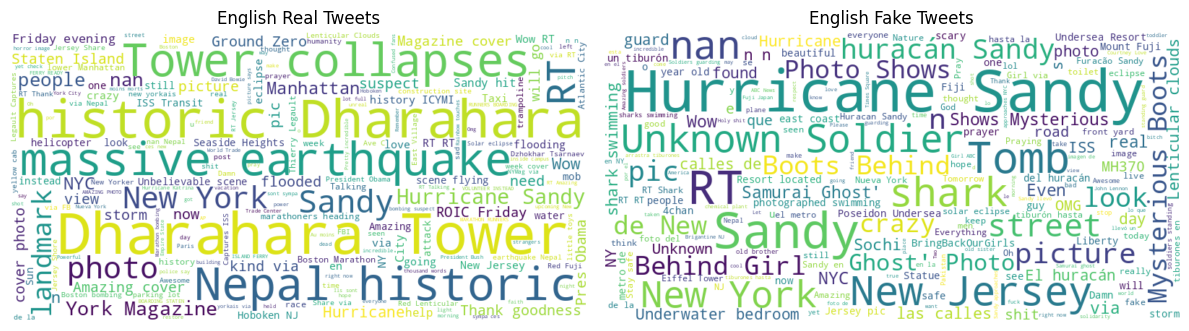

In [ ]:
from wordcloud import WordCloud

# Helper function for English (no special font)
def make_wc(text_series, **wc_kwargs):
    text = " ".join(text_series.astype(str).values)
    return WordCloud(width=800, height=400, background_color='white', **wc_kwargs).generate(text)

# Generate English Real vs Fake wordclouds
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

wc_en_real = make_wc(en_train_df[en_train_df['label'] == 0]['post_text'])
wc_en_fake = make_wc(en_train_df[en_train_df['label'] == 1]['post_text'])

axes[0].imshow(wc_en_real, interpolation='bilinear')
axes[0].set_title("English Real Tweets")
axes[1].imshow(wc_en_fake, interpolation='bilinear')
axes[1].set_title("English Fake Tweets")

for ax in axes:
    ax.axis("off")

plt.tight_layout()
plt.show()


config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

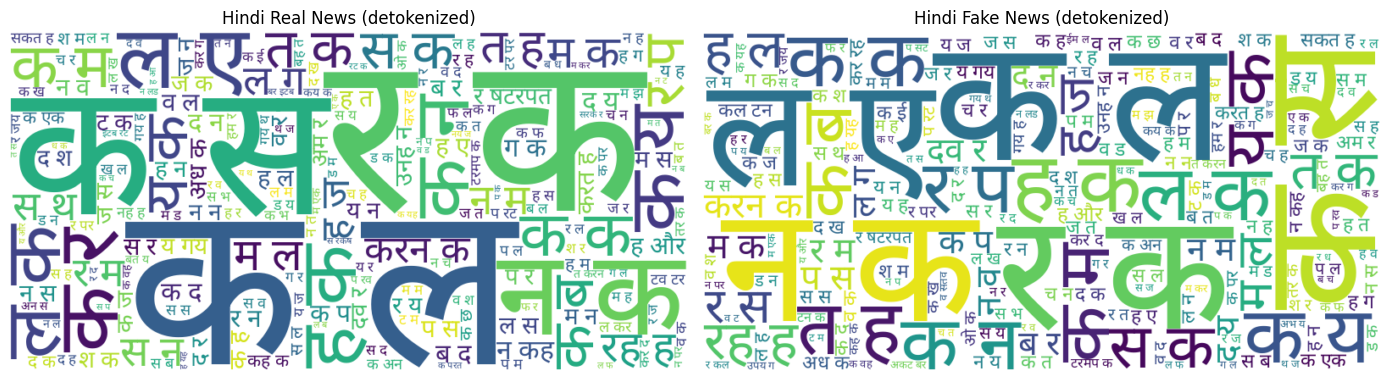

In [ ]:
# Detokenize Hindi texts using the IndicBERT tokenizer and generate wordclouds
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from pathlib import Path

# ensure hindi_tokenizer is loaded
try:
    hindi_tokenizer
except NameError:
    from transformers import AutoTokenizer
    hindi_tokenizer = AutoTokenizer.from_pretrained("ai4bharat/indic-bert", use_fast=False)

# detokenize each Hindi row into a readable string
def detok_to_string(text):
    toks = hindi_tokenizer.tokenize(str(text))
    return hindi_tokenizer.convert_tokens_to_string(toks)

# create a detokenized column (sample or full)
hindi_df['detok_text'] = hindi_df['text'].astype(str).map(detok_to_string)

# generate wordclouds from detokenized text (use Devanagari font if available)
font_path = Path("/content/drive/MyDrive/Fake news thesis project LJMU/NotoSansDevanagari-VariableFont_wdth,wght.ttf")
font_arg = str(font_path) if font_path.exists() else None

def make_wc_from_series(series, font_path=None, **kwargs):
    text = " ".join(series.astype(str).values)
    if font_path:
        return WordCloud(font_path=font_path, width=800, height=400, background_color='white', **kwargs).generate(text)
    else:
        return WordCloud(width=800, height=400, background_color='white', **kwargs).generate(text)

wc_hi_real = make_wc_from_series(hindi_df[hindi_df['label']==0]['detok_text'], font_path=font_arg)
wc_hi_fake = make_wc_from_series(hindi_df[hindi_df['label']==1]['detok_text'], font_path=font_arg)

fig, axes = plt.subplots(1,2, figsize=(14,6))
axes[0].imshow(wc_hi_real, interpolation='bilinear'); axes[0].set_title("Hindi Real News (detokenized)")
axes[1].imshow(wc_hi_fake, interpolation='bilinear'); axes[1].set_title("Hindi Fake News (detokenized)")
for ax in axes: ax.axis("off")
plt.tight_layout(); plt.show()


Although additional filtering could remove frequent short verbs and function fragments, it was avoided to preserve the authenticity of Hindi morphology. Aggressive filtering risked altering word forms (e.g., merging or truncating matras), which could distort linguistic patterns. Hence, only minimal stopword removal was applied, ensuring that the word clouds reflect genuine lexical distributions as used in Hindi news text.

Tokenization dry-run: tokenize a small sample from each split, print shapes, token counts, and show example decoded tokens. Use this to pick suitable max_lengths for training.

In [ ]:
# Cell: Tokenization dry-run for Hindi (IndicBERT) and English (MobileBERT)

from pathlib import Path
import torch
import numpy as np

# Recommended max lengths (you can adjust after inspecting the outputs)
SUGGESTED_MAX_EN = 128
SUGGESTED_MAX_HI = 256

# Ensure tokenizers are loaded (load safely if not in memory)
try:
    hindi_tokenizer
except NameError:
    from transformers import AutoTokenizer
    hindi_tokenizer = AutoTokenizer.from_pretrained("ai4bharat/indic-bert", use_fast=False)

try:
    en_tokenizer
except NameError:
    from transformers import AutoTokenizer
    en_tokenizer = AutoTokenizer.from_pretrained("google/mobilebert-uncased", use_fast=False)

# Load small samples
proc_dir = Path("/content/drive/MyDrive/Fake news thesis project LJMU/Data/processed")
# prefer the splits we just created
hi_sample = pd.read_csv(proc_dir / "hindi_final.csv").sample(n=8, random_state=42).reset_index(drop=True) # Corrected filename
en_sample = pd.read_csv(proc_dir / "english_train_final.csv").sample(n=8, random_state=42).reset_index(drop=True) # Corrected filename

print("Sample sizes — Hindi:", len(hi_sample), "English:", len(en_sample))

# Tokenize (no max length here — to inspect natural token lengths)
hi_enc = hindi_tokenizer(hi_sample["text"].astype(str).tolist(), truncation=False, padding=False)
en_enc = en_tokenizer(en_sample["post_text"].astype(str).tolist(), truncation=False, padding=False)

# Compute token lengths
hi_token_lengths = [len(x) for x in hi_enc["input_ids"]]
en_token_lengths = [len(x) for x in en_enc["input_ids"]]

print("\nHindi token lengths (sample):", hi_token_lengths)
print(" Hindi token lengths stats: mean={:.1f}, median={}, max={}".format(np.mean(hi_token_lengths), np.median(hi_token_lengths), np.max(hi_token_lengths)))

print("\nEnglish token lengths (sample):", en_token_lengths)
print(" English token lengths stats: mean={:.1f}, median={}, max={}".format(np.mean(en_token_lengths), np.median(en_token_lengths), np.max(en_token_lengths)))

# Try tokenizing with suggested max lengths to see padded shapes
hi_enc_trunc = hindi_tokenizer(hi_sample["text"].astype(str).tolist(), truncation=True, padding="max_length", max_length=SUGGESTED_MAX_HI, return_tensors="pt")
en_enc_trunc = en_tokenizer(en_sample["post_text"].astype(str).tolist(), truncation=True, padding="max_length", max_length=SUGGESTED_MAX_EN, return_tensors="pt")

print("\nAfter padding/truncation:")
print(" Hindi enc shape input_ids:", hi_enc_trunc['input_ids'].shape)
print(" English enc shape input_ids:", en_enc_trunc['input_ids'].shape)

# Show one decoded example (original vs detokenized form for inspection)
i = 0
print("\n--- Example Hindi text (original) ---\n", hi_sample.loc[i,"text"][:400])
print("\n--- Tokenized (first 40 tokens) ---\n", hindi_tokenizer.convert_ids_to_tokens(hi_enc_trunc['input_ids'][i][:40].tolist()))
print("\n--- Decoded back (tokenizer.convert_tokens_to_string) ---\n", hindi_tokenizer.convert_tokens_to_string(hindi_tokenizer.convert_ids_to_tokens(hi_enc_trunc['input_ids'][i].tolist()))[:400])

j = 0
print("\n--- Example English text (original) ---\n", en_sample.loc[j,"post_text"][:300])
print("\n--- Tokenized (first 40 tokens) ---\n", en_tokenizer.convert_ids_to_tokens(en_enc_trunc['input_ids'][j][:40].tolist()))
print("\n--- Decoded back ---\n", en_tokenizer.convert_tokens_to_string(en_tokenizer.convert_ids_to_tokens(en_enc_trunc['input_ids'][j].tolist()))[:300])

# Recommendation printout
print(f"\nRecommended starting max lengths (tune later): Hindi = {SUGGESTED_MAX_HI}, English = {SUGGESTED_MAX_EN}")
print("If many Hindi samples exceed the suggested max, increase to 512 (watch GPU memory).")

config.json:   0%|          | 0.00/847 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Sample sizes — Hindi: 8 English: 8

Hindi token lengths (sample): [477, 79, 372, 28, 58, 58, 19, 44]
 Hindi token lengths stats: mean=141.9, median=58.0, max=477

English token lengths (sample): [15, 20, 19, 29, 20, 10, 30, 26]
 English token lengths stats: mean=21.1, median=20.0, max=30

After padding/truncation:
 Hindi enc shape input_ids: torch.Size([8, 256])
 English enc shape input_ids: torch.Size([8, 128])

--- Example Hindi text (original) ---
 रियो डी जनेरियो - सिमोन मैनुअल ने गुरुवार रात फ्रीस्टाइल में जीत हासिल की और व्यक्तिगत तैराकी स्पर्धा में स्वर्ण जीतने वाली पहली महिला बन गईं। यहां उसकी प्रतिक्रिया का एक पूलसाइड दृश्य है जिस क्षण से उसे एहसास हुआ कि वह जीत गई है जब तक कि उसने पोडियम पर स्वर्ण पदक प्राप्त नहीं किया और दौड़ पर उसके विचार। “मैं बहुत आश्चर्यचकित था। मुझे नहीं लगता कि कोई निश्चित बिंदु था जहां मैंने सोचा था कि मेरे पा

--- Tokenized (first 40 tokens) ---
 ['[CLS]', '▁रियो', '▁डी', '▁जन', 'े', 'रियो', '▁-', '▁सिम', 'ोन', '▁मैन', 'ुअल', '▁ने', '▁गुरुवार', '▁रात

In [ ]:
# Cell: PyTorch Text Dataset + collate_fn + DataLoader dry-run (text-only)
import torch
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from PIL import Image

# Simple dataset for text classification (works for Hindi or English)
class TextDataset(Dataset):
    def __init__(self, df, text_col="text", label_col="label"):
        self.df = df.reset_index(drop=True)
        self.text_col = text_col
        self.label_col = label_col

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        return {
            self.text_col: str(row[self.text_col]), # Use text_col as the key
            self.label_col: int(row[self.label_col]) # Use label_col as the key
        }

# Collate function that tokenizes and pads a batch using a HF tokenizer
def make_collate_fn(tokenizer, max_length=256, text_key="text"):
    def collate(batch):
        texts = [b[text_key] for b in batch]
        labels = torch.tensor([b["label"] for b in batch], dtype=torch.long)
        enc = tokenizer(
            texts,
            padding="max_length",
            truncation=True,
            max_length=max_length,
            return_tensors="pt",
        )
        batch_out = {
            "input_ids": enc["input_ids"],
            "attention_mask": enc["attention_mask"],
            "labels": labels
        }
        return batch_out
    return collate

# --- Prepare small datasets for dry-run (load the CSV splits we saved) ---
proc_dir = Path("/content/drive/MyDrive/Fake news thesis project LJMU/Data/processed")

hi_df = pd.read_csv(proc_dir / "hindi_final.csv").sample(n=256, random_state=42).reset_index(drop=True)  # small subset
en_df = pd.read_csv(proc_dir / "english_train_final.csv").sample(n=256, random_state=42).reset_index(drop=True) # Corrected csv name

# Create dataset objects
hi_dataset = TextDataset(hi_df, text_col="text", label_col="label")
en_dataset = TextDataset(en_df, text_col="post_text", label_col="label") # Corrected text_col

# Ensure tokenizers are present
try:
    hindi_tokenizer
except NameError:
    from transformers import AutoTokenizer
    hindi_tokenizer = AutoTokenizer.from_pretrained("ai4bharat/indic-bert", use_fast=False)
try:
    en_tokenizer
except NameError:
    from transformers import AutoTokenizer
    en_tokenizer = AutoTokenizer.from_pretrained("google/mobilebert-uncased", use_fast=False)

# Make collate fns with recommended max lengths
hi_collate = make_collate_fn(hindi_tokenizer, max_length=256, text_key="text")
en_collate = make_collate_fn(en_tokenizer, max_length=128, text_key="post_text") # Corrected text_key

# Build DataLoaders (small batch to fit memory)
hi_loader = DataLoader(hi_dataset, batch_size=8, shuffle=True, collate_fn=hi_collate, num_workers=0)
en_loader = DataLoader(en_dataset, batch_size=16, shuffle=True, collate_fn=en_collate, num_workers=0)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Pull one batch from each loader and print shapes
hi_batch = next(iter(hi_loader))
en_batch = next(iter(en_loader))

print("\nHindi batch shapes:")
print(" input_ids:", hi_batch["input_ids"].shape)
print(" attention_mask:", hi_batch["attention_mask"].shape)
print(" labels:", hi_batch["labels"].shape)

print("\nEnglish batch shapes:")
print(" input_ids:", en_batch["input_ids"].shape)
print(" attention_mask:", en_batch["attention_mask"].shape)
print(" labels:", en_batch["labels"].shape)

# Move to device (dry-run)
hi_batch_on_device = {k: v.to(device) for k,v in hi_batch.items()}
en_batch_on_device = {k: v.to(device) for k,v in en_batch.items()}
print("\nMoved batches to device successfully (dry-run).")

Using device: cuda

Hindi batch shapes:
 input_ids: torch.Size([8, 256])
 attention_mask: torch.Size([8, 256])
 labels: torch.Size([8])

English batch shapes:
 input_ids: torch.Size([16, 128])
 attention_mask: torch.Size([16, 128])
 labels: torch.Size([16])

Moved batches to device successfully (dry-run).


Saved Figure 4.1 → outputs/figures/Figure_4_1_class_distribution.png


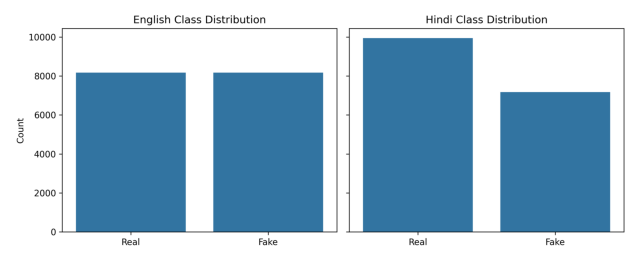

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # optional; used just for barplot aesthetics

# --- I/O ---
os.makedirs("outputs/figures", exist_ok=True)

en_train = pd.read_csv("/content/drive/MyDrive/Fake news thesis project LJMU/Data/processed/english_train_final.csv")
en_test  = pd.read_csv("/content/drive/MyDrive/Fake news thesis project LJMU/Data/processed/english_test_final.csv")
hi       = pd.read_csv("/content/drive/MyDrive/Fake news thesis project LJMU/Data/processed/hindi_final.csv")

# --- Count prep ---
# sum train+test counts, align indices, rename to Real/Fake, and ensure both classes exist
en_counts_raw = en_train['label'].value_counts().add(en_test['label'].value_counts(), fill_value=0)
en_counts = (en_counts_raw.rename(index={0: 'Real', 1: 'Fake'})
                        .reindex(['Real', 'Fake'], fill_value=0)
                        .astype(int))

hi_counts = (hi['label'].value_counts()
                 .rename(index={0: 'Real', 1: 'Fake'})
                 .reindex(['Real', 'Fake'], fill_value=0)
                 .astype(int))

# --- Plot ---
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

sns.barplot(x=en_counts.index, y=en_counts.values, ax=ax[0])
ax[0].set_title("English Class Distribution")
ax[0].set_xlabel("")
ax[0].set_ylabel("Count")

sns.barplot(x=hi_counts.index, y=hi_counts.values, ax=ax[1])
ax[1].set_title("Hindi Class Distribution")
ax[1].set_xlabel("")
ax[1].set_ylabel("")

plt.tight_layout()
plt.savefig("outputs/figures/Figure_4_1_class_distribution.png", dpi=300, bbox_inches="tight")
plt.close()
print("Saved Figure 4.1 → outputs/figures/Figure_4_1_class_distribution.png")
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("outputs/figures/Figure_4_1_class_distribution.png")
plt.figure(figsize=(8,4))
plt.imshow(img)
plt.axis("off")
plt.show()


## --Hindi Text Model Training--


In [ ]:
# --- Repro & paths ---
import os, random, json, hashlib
from pathlib import Path
import numpy as np
import torch

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

PROJECT_ROOT = Path("/content/drive/MyDrive/Fake news thesis project LJMU").resolve()
PROC_DIR = PROJECT_ROOT / "Data" / "processed"
OUT_DIR  = PROJECT_ROOT / "outputs"
(OUT_DIR / "checkpoints").mkdir(parents=True, exist_ok=True)
(OUT_DIR / "metrics").mkdir(parents=True, exist_ok=True)
(OUT_DIR / "tb" / "hindi_text_only").mkdir(parents=True, exist_ok=True)

print("PROJECT_ROOT:", PROJECT_ROOT)


PROJECT_ROOT: /content/drive/MyDrive/Fake news thesis project LJMU


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from IPython.display import display

paths = {
    "train": PROC_DIR / "hindi_train.csv",
    "val":   PROC_DIR / "hindi_val.csv",
    "test":  PROC_DIR / "hindi_test.csv",
}

def normalize_labels(df: pd.DataFrame) -> pd.DataFrame:
    candidate_cols = ["label", "labels", "target", "y"]
    label_col = next((c for c in candidate_cols if c in df.columns), None)
    if label_col is None:
        raise KeyError(f"No label column among {candidate_cols}. Got: {list(df.columns)}")
    ser = df[label_col]

    if ser.dtype == object:
        lower = ser.astype(str).str.strip().str.lower()
        mapping = {"real":0, "true":0, "legit":0, "0":0,
                   "fake":1, "false":1, "spam":1, "1":1}
        if not lower.isin(mapping).all():
            ser_num = pd.to_numeric(ser, errors="coerce")
            if ser_num.isna().any():
                bad = sorted(set(lower[~lower.isin(mapping)].tolist()))
                raise ValueError(f"Unrecognized label values: {bad}")
            df["label"] = ser_num.astype(int)
        else:
            df["label"] = lower.map(mapping).astype(int)
    else:
        uniq = sorted(pd.unique(ser))
        if set(uniq) <= {0,1}:
            df["label"] = ser.astype(int)
        elif len(uniq) == 2:
            vmin, vmax = uniq[0], uniq[-1]
            df["label"] = ser.map({vmin:0, vmax:1}).astype(int)
        else:
            raise ValueError(f"Unexpected numeric labels: {uniq}")
    return df

def ensure_splits():
    missing = [p for p in paths.values() if not p.exists()]
    if not missing:
        return

    merged = PROC_DIR / "hindi_final.csv"
    if not merged.exists():
        raise FileNotFoundError(f"Need {merged} to create splits.")
    df = normalize_labels(pd.read_csv(merged)).dropna(subset=["label"]).reset_index(drop=True)

    rng = 42
    df_train, df_tmp = train_test_split(df, test_size=0.20, random_state=rng, stratify=df["label"])
    df_val, df_test  = train_test_split(df_tmp, test_size=0.50, random_state=rng, stratify=df_tmp["label"])
    df_train.to_csv(paths["train"], index=False)
    df_val.to_csv(paths["val"], index=False)
    df_test.to_csv(paths["test"], index=False)
    print("Created splits:", {k:str(v) for k,v in paths.items()})

ensure_splits()

hindi_train_df = normalize_labels(pd.read_csv(paths["train"]))
hindi_val_df   = normalize_labels(pd.read_csv(paths["val"]))
hindi_test_df  = normalize_labels(pd.read_csv(paths["test"]))

print("Loaded Hindi splits:",
      "\n train:", hindi_train_df.shape,
      "\n val:  ", hindi_val_df.shape,
      "\n test: ", hindi_test_df.shape)
print("\nTrain label distribution:\n", hindi_train_df["label"].value_counts().sort_index())
display(hindi_train_df.head(3))


Loaded Hindi splits: 
 train: (13699, 2) 
 val:   (1712, 2) 
 test:  (1713, 2)

Train label distribution:
 label
0    7955
1    5744
Name: count, dtype: int64


text  label
0  बूम रिज़र्व बैंक द्वार जार सूच पढ़ जिसम साफ़ तौर ...      1
1  अमेरिका चुनाव के बाद तक रूस के साथ साइबर युद्ध...      1
2  शुक्रवार को अपनी वेबसाइट पर दिए गए एक बयान के ...      0

In [ ]:
# Cell 2 — Tokenizer, Dataset, (optional) WeightedRandomSampler (kept OFF for 58/42 split)

from transformers import AutoTokenizer
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import pandas as pd
import numpy as np

MODEL_NAME = "ai4bharat/indic-bert"
MAX_LEN_HI = 256
BATCH_SIZE_HI = 8
USE_WEIGHTED_SAMPLER = False   # ✅ keep False for 58/42; turn True only if recall(1) is still low

# Fast tokenizer off avoids occasional env issues; keep consistent with the rest
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=False)

# --- Dataset ---
class HindiTextDataset(Dataset):
    def __init__(self, df: pd.DataFrame, text_col="text", label_col="label"):
        if text_col not in df.columns or label_col not in df.columns:
            raise KeyError(f"Expected columns '{text_col}' and '{label_col}' in df; got {list(df.columns)}")
        # Clean minimal: fill NaNs, strip
        self.texts = df[text_col].astype(str).fillna("").str.strip().tolist()
        self.labels = df[label_col].astype(int).tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, i):
        return {"text": self.texts[i], "label": self.labels[i]}

def make_collate_fn(tokenizer, max_length=256):
    def collate(batch):
        texts  = [b["text"] for b in batch]
        labels = torch.tensor([b["label"] for b in batch], dtype=torch.long)
        enc = tokenizer(
            texts,
            padding="max_length",
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        )
        return {"input_ids": enc["input_ids"],
                "attention_mask": enc["attention_mask"],
                "labels": labels}
    return collate

train_ds = HindiTextDataset(hindi_train_df)
val_ds   = HindiTextDataset(hindi_val_df)
collate_fn = make_collate_fn(tokenizer, MAX_LEN_HI)

# --- Optional sampler (leave OFF for now) ---
if USE_WEIGHTED_SAMPLER:
    # Inverse-frequency weights so rarer class is sampled more
    cls_counts = pd.Series(train_ds.labels).value_counts().sort_index()
    w0 = len(train_ds) / (2.0 * cls_counts.get(0, 1))
    w1 = len(train_ds) / (2.0 * cls_counts.get(1, 1))
    per_sample_w = [w0 if y == 0 else w1 for y in train_ds.labels]
    sampler = WeightedRandomSampler(weights=per_sample_w,
                                    num_samples=len(per_sample_w),
                                    replacement=True)
    shuffle_flag = False
else:
    sampler = None
    shuffle_flag = True

# DataLoader perf knobs
num_workers = 2 if torch.cuda.is_available() else 0
pin_memory  = torch.cuda.is_available()
persistent  = True if num_workers > 0 else False

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE_HI,
    shuffle=shuffle_flag,
    sampler=sampler,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
    persistent_workers=persistent,
    drop_last=False
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE_HI,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
    persistent_workers=persistent,
    drop_last=False
)

# Quick sanity check
b = next(iter(train_loader))
print("Batch shapes:",
      "input_ids", tuple(b["input_ids"].shape),
      "attention_mask", tuple(b["attention_mask"].shape),
      "labels", tuple(b["labels"].shape))
print(f"Sampler used: {type(sampler).__name__ if sampler else 'None'} | "
      f"num_workers={num_workers} | pin_memory={pin_memory}")


Batch shapes: input_ids (8, 256) attention_mask (8, 256) labels (8,)
Sampler used: None | num_workers=2 | pin_memory=True


In [ ]:
# Cell 3 — Model (IndicBERT + linear head)

import torch
import torch.nn as nn
from transformers import AutoModel

class HindiClassifier(nn.Module):
    def __init__(self, model_name="ai4bharat/indic-bert", num_labels=2, dropout=0.3):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        hidden = self.bert.config.hidden_size
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden, num_labels)

    def forward(self, input_ids, attention_mask):
        out = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )
        # use pooled output if available, else [CLS]
        pooled = out.pooler_output if getattr(out, "pooler_output", None) is not None else out.last_hidden_state[:, 0]
        logits = self.fc(self.dropout(pooled))
        return logits

# Init + device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HindiClassifier().to(device)

print("✅ HindiClassifier ready | device:", device)
print("Hidden size:", model.bert.config.hidden_size)


pytorch_model.bin:   0%|          | 0.00/135M [00:00<?, ?B/s]

✅ HindiClassifier ready | device: cuda
Hidden size: 768


In [ ]:
# Cell 4 — Hyperparams + class weights (+ optional focal)

import torch
import torch.nn as nn
import torch.nn.functional as F

HYPERPARAMS = {
    "NUM_EPOCHS": 4,
    "LR": 2e-5,
    "WEIGHT_DECAY": 0.01,
    "WARMUP_RATIO": 0.06,
    "BATCH_ACCUM": 1,
    "MAX_GRAD_NORM": 1.0,
    "FREEZE_BASE": False,   # set True to freeze encoder for epoch 1, then unfreeze
    "USE_FOCAL": False,     # toggle to True only if minority recall remains low
    "FOCAL_GAMMA": 2.0,
}

# Class weights from TRAIN split (inverse frequency) → better minority recall without a sampler
train_counts = hindi_train_df["label"].value_counts().sort_index()  # {0:..., 1:...}
n0, n1 = int(train_counts.get(0, 0)), int(train_counts.get(1, 0))
total = n0 + n1 if (n0 + n1) > 0 else 1
w0 = total / (2.0 * max(n0, 1))
w1 = total / (2.0 * max(n1, 1))
CLASS_WEIGHTS = torch.tensor([w0, w1], dtype=torch.float, device=device)
print(f"Train counts: 0={n0}, 1={n1} | class weights: {CLASS_WEIGHTS.tolist()}")

# Optional focal loss (use with care; try only if CE+class weights under-recall class 1)
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super().__init__()
        self.gamma = gamma
        self.weight = weight
    def forward(self, logits, target):
        ce = F.cross_entropy(logits, target, weight=self.weight, reduction="none")
        pt = torch.exp(-ce)  # prob of the true class
        return ((1 - pt) ** self.gamma * ce).mean()



Train counts: 0=7955, 1=5744 | class weights: [0.8610308170318604, 1.1924617290496826]


In [ ]:
# Cell 5 — Train loop: AMP + warmup + early stop + grad clip + TensorBoard

import time, json
import numpy as np
import torch
import torch.nn as nn
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.utils.tensorboard import SummaryWriter
from tqdm.auto import tqdm

# --- Config & paths ---
CHECK_DIR = OUT_DIR / "checkpoints"
CHECK_DIR.mkdir(parents=True, exist_ok=True)
BEST_PATH = CHECK_DIR / "hindi_best.pt"
META_PATH = CHECK_DIR / "hindi_metadata.json"
TB_DIR = OUT_DIR / "tb" / "hindi_text_only"

# --- Freeze encoder for warm-up if requested ---
if HYPERPARAMS["FREEZE_BASE"]:
    for p in model.bert.parameters():
        p.requires_grad = False
    print("Encoder frozen for warm-up (epoch 1).")

# --- Optim, sched, loss ---
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = AdamW(trainable_params, lr=HYPERPARAMS["LR"], weight_decay=HYPERPARAMS["WEIGHT_DECAY"])
total_steps = max(1, len(train_loader)) * HYPERPARAMS["NUM_EPOCHS"]
warmup_steps = int(total_steps * HYPERPARAMS["WARMUP_RATIO"])
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

if HYPERPARAMS["USE_FOCAL"]:
    criterion = FocalLoss(gamma=HYPERPARAMS["FOCAL_GAMMA"], weight=CLASS_WEIGHTS)
else:
    criterion = nn.CrossEntropyLoss(weight=CLASS_WEIGHTS)

scaler = torch.amp.GradScaler()
writer = SummaryWriter(log_dir=str(TB_DIR))

# --- Training state ---
best_f1, best_epoch = -1.0, 0
early_patience, bad_epochs = 2, 0
history = {"train_loss": [], "val_loss": [], "val_f1": []}
NUM_EPOCHS = HYPERPARAMS["NUM_EPOCHS"]
BATCH_ACCUM = HYPERPARAMS["BATCH_ACCUM"]
MAX_GRAD_NORM = HYPERPARAMS["MAX_GRAD_NORM"]

for epoch in range(1, NUM_EPOCHS + 1):
    t0 = time.time()
    model.train()
    run_loss, y_true, y_pred = [], [], []

    pbar = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch}/{NUM_EPOCHS} — train")
    optimizer.zero_grad()
    for step, batch in enumerate(pbar, 1):
        ids  = batch["input_ids"].to(device)
        mask = batch["attention_mask"].to(device)
        lab  = batch["labels"].to(device)

        with torch.amp.autocast(device_type=("cuda" if device.type=="cuda" else "cpu"),
                                 enabled=(device.type=="cuda")):
            logits = model(ids, mask)
            loss = criterion(logits, lab) / max(1, BATCH_ACCUM)

        scaler.scale(loss).backward()

        if step % max(1, BATCH_ACCUM) == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            scheduler.step()

        run_loss.append(loss.item() * max(1, BATCH_ACCUM))
        y_pred.extend(torch.argmax(logits.detach(), dim=-1).cpu().tolist())
        y_true.extend(lab.detach().cpu().tolist())
        pbar.set_postfix({"loss": float(np.mean(run_loss))})

    train_loss = float(np.mean(run_loss))
    tr_acc = accuracy_score(y_true, y_pred)
    tr_prec, tr_rec, tr_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)

    # Unfreeze after warm-up
    if HYPERPARAMS["FREEZE_BASE"] and epoch == 1:
        for p in model.bert.parameters():
            p.requires_grad = True
        print("Encoder unfrozen after epoch 1.")

    # ---- Validation ----
    model.eval()
    vlosses, vtrue, vpred = [], [], []
    with torch.no_grad():
        for vb in tqdm(val_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS} — val"):
            ids  = vb["input_ids"].to(device)
            mask = vb["attention_mask"].to(device)
            lab  = vb["labels"].to(device)
            with torch.amp.autocast(device_type=("cuda" if device.type=="cuda" else "cpu"),
                                     enabled=(device.type=="cuda")):
                logits = model(ids, mask)
                vloss = criterion(logits, lab)
            vlosses.append(vloss.item())
            vpred.extend(torch.argmax(logits, dim=1).cpu().tolist())
            vtrue.extend(lab.cpu().tolist())

    val_loss = float(np.mean(vlosses))
    val_acc = accuracy_score(vtrue, vpred)
    val_prec, val_rec, val_f1, _ = precision_recall_fscore_support(vtrue, vpred, average="binary", zero_division=0)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_f1"].append(val_f1)

    # TensorBoard logs
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Loss/val", val_loss, epoch)
    writer.add_scalar("F1/train", tr_f1, epoch)
    writer.add_scalar("F1/val", val_f1, epoch)
    writer.add_scalar("Acc/val", val_acc, epoch)
    writer.add_scalar("LR", scheduler.get_last_lr()[0], epoch)
    writer.flush()

    # Save best
    if val_f1 > best_f1:
        best_f1, best_epoch, bad_epochs = val_f1, epoch, 0
        torch.save(model.state_dict(), BEST_PATH)
        print(f"✨ New best F1={best_f1:.4f} at epoch {epoch} → {BEST_PATH}")
    else:
        bad_epochs += 1
        print(f"No improvement. Patience {bad_epochs}/{early_patience}")

    META_PATH.write_text(json.dumps({
        "best_f1": best_f1, "best_epoch": best_epoch, "history": history
    }, indent=2))

    print(f"Epoch {epoch}: train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | "
          f"train_f1={tr_f1:.4f} | val_f1={val_f1:.4f} | time={(time.time()-t0):.1f}s")

    if bad_epochs >= early_patience:
        print("Early stopping 🔚")
        break

writer.close()
print("Training done. Best F1:", best_f1)


Epoch 1/4 — train:   0%|          | 0/1713 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/135M [00:00<?, ?B/s]

Epoch 1/4 — val:   0%|          | 0/214 [00:00<?, ?it/s]

✨ New best F1=0.7402 at epoch 1 → /content/drive/MyDrive/Fake news thesis project LJMU/outputs/checkpoints/hindi_best.pt
Epoch 1: train_loss=0.5779 | val_loss=0.4762 | train_f1=0.6797 | val_f1=0.7402 | time=102.5s


Epoch 2/4 — train:   0%|          | 0/1713 [00:00<?, ?it/s]

Epoch 2/4 — val:   0%|          | 0/214 [00:00<?, ?it/s]

✨ New best F1=0.8582 at epoch 2 → /content/drive/MyDrive/Fake news thesis project LJMU/outputs/checkpoints/hindi_best.pt
Epoch 2: train_loss=0.3958 | val_loss=0.3790 | train_f1=0.8210 | val_f1=0.8582 | time=93.7s


Epoch 3/4 — train:   0%|          | 0/1713 [00:00<?, ?it/s]

Epoch 3/4 — val:   0%|          | 0/214 [00:00<?, ?it/s]

✨ New best F1=0.8590 at epoch 3 → /content/drive/MyDrive/Fake news thesis project LJMU/outputs/checkpoints/hindi_best.pt
Epoch 3: train_loss=0.3044 | val_loss=0.4452 | train_f1=0.8946 | val_f1=0.8590 | time=93.7s


Epoch 4/4 — train:   0%|          | 0/1713 [00:00<?, ?it/s]

Epoch 4/4 — val:   0%|          | 0/214 [00:00<?, ?it/s]

✨ New best F1=0.8698 at epoch 4 → /content/drive/MyDrive/Fake news thesis project LJMU/outputs/checkpoints/hindi_best.pt
Epoch 4: train_loss=0.2223 | val_loss=0.4628 | train_f1=0.9294 | val_f1=0.8698 | time=95.1s
Training done. Best F1: 0.8697508896797153


Using best checkpoint: /content/drive/MyDrive/Fake news thesis project LJMU/outputs/checkpoints/hindi_best.pt
TEST — acc=0.8792 | F1(fake=1)=0.8518 | precision=0.8763 | recall=0.8287
Per-class [0=real, 1=fake]:
 precision: [0.88104449 0.87628866] 
 recall:    [0.91557789 0.82869081] 
 f1:        [0.8979793  0.85182534]

Classification report:
               precision    recall  f1-score   support

           0     0.8810    0.9156    0.8980       995
           1     0.8763    0.8287    0.8518       718

    accuracy                         0.8792      1713
   macro avg     0.8787    0.8721    0.8749      1713
weighted avg     0.8791    0.8792    0.8786      1713

Saved predictions/metrics → /content/drive/MyDrive/Fake news thesis project LJMU/outputs/metrics


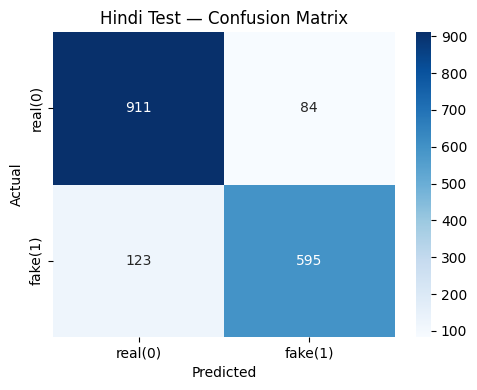

In [ ]:
# Cell 6 — Test evaluation: predictions, metrics, confusion matrix

import torch, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

best_ckpt = OUT_DIR / "checkpoints" / "hindi_best.pt"
assert best_ckpt.exists(), f"Best checkpoint not found: {best_ckpt}"
print("Using best checkpoint:", best_ckpt)

# Ensure model/tokenizer are in scope
try:
    model
except NameError:
    # Rebuild model if needed
    import torch.nn as nn
    from transformers import AutoModel
    class HindiClassifier(nn.Module):
        def __init__(self, model_name="ai4bharat/indic-bert", num_labels=2, dropout=0.3):
            super().__init__()
            self.bert = AutoModel.from_pretrained(model_name)
            hidden = self.bert.config.hidden_size
            self.dropout = nn.Dropout(dropout)
            self.fc = nn.Linear(hidden, num_labels)
        def forward(self, input_ids, attention_mask):
            out = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
            pooled = out.pooler_output if getattr(out, "pooler_output", None) is not None else out.last_hidden_state[:,0]
            return self.fc(self.dropout(pooled))
    model = HindiClassifier().to(device)

model.load_state_dict(torch.load(best_ckpt, map_location=device))
model.eval()

# Load test set and ensure labels normalized
test_df = normalize_labels(pd.read_csv(PROC_DIR / "hindi_test.csv")).reset_index(drop=True)

# Batched inference
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("ai4bharat/indic-bert", use_fast=False)

probs, preds = [], []
bs = 32
for i in range(0, len(test_df), bs):
    texts = test_df["text"].astype(str).iloc[i:i+bs].tolist()
    enc = tokenizer(texts, padding="max_length", truncation=True, max_length=256, return_tensors="pt")
    with torch.no_grad():
        logits = model(enc["input_ids"].to(device), enc["attention_mask"].to(device))
        p = torch.softmax(logits, dim=1)[:,1].cpu().numpy()
        yhat = np.argmax(logits.cpu().numpy(), axis=1)
    probs.extend(p.tolist()); preds.extend(yhat.tolist())

golds = test_df["label"].tolist()

# Metrics
acc = accuracy_score(golds, preds)
prec_bin, rec_bin, f1_bin, _ = precision_recall_fscore_support(golds, preds, average="binary", zero_division=0)
prec_cls, rec_cls, f1_cls, _ = precision_recall_fscore_support(golds, preds, average=None, zero_division=0)

print(f"TEST — acc={acc:.4f} | F1(fake=1)={f1_bin:.4f} | precision={prec_bin:.4f} | recall={rec_bin:.4f}")
print("Per-class [0=real, 1=fake]:")
print(" precision:", prec_cls, "\n recall:   ", rec_cls, "\n f1:       ", f1_cls)
print("\nClassification report:\n", classification_report(golds, preds, digits=4))

# Save row-wise predictions
MET_DIR = OUT_DIR / "metrics"; MET_DIR.mkdir(parents=True, exist_ok=True)
preds_df = test_df.copy()
preds_df["pred"] = preds
preds_df["prob_fake"] = probs
preds_df.to_csv(MET_DIR / "hindi_test_predictions.csv", index=False)
pd.DataFrame([{"accuracy": acc, "precision": float(prec_bin), "recall": float(rec_bin), "f1": float(f1_bin), "n_test": len(test_df)}]) \
  .to_csv(MET_DIR / "hindi_test_metrics.csv", index=False)
print("Saved predictions/metrics →", MET_DIR)

# Confusion matrix
cm = confusion_matrix(golds, preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["real(0)","fake(1)"], yticklabels=["real(0)","fake(1)"])
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Hindi Test — Confusion Matrix")
plt.tight_layout()
plt.savefig(MET_DIR / "hindi_confusion_matrix.png", dpi=200)
plt.show()


In [ ]:
# Cell 7 — Save FP/FN tables and show a few

import pandas as pd
from IPython.display import display

MET_DIR = OUT_DIR / "metrics"
df = pd.read_csv(MET_DIR / "hindi_test_predictions.csv")

fp = df[(df["label"] == 0) & (df["pred"] == 1)].copy()
fn = df[(df["label"] == 1) & (df["pred"] == 0)].copy()

fp.to_csv(MET_DIR / "hindi_false_positives.csv", index=False)
fn.to_csv(MET_DIR / "hindi_false_negatives.csv", index=False)
print(f"Saved FP={len(fp)} → {MET_DIR/'hindi_false_positives.csv'}")
print(f"Saved FN={len(fn)} → {MET_DIR/'hindi_false_negatives.csv'}")

print("\nExample FP (actual=real, pred=fake):")
display(fp[["text","label","pred","prob_fake"]].head(5))
print("\nExample FN (actual=fake, pred=real):")
display(fn[["text","label","pred","prob_fake"]].head(5))


Saved FP=84 → /content/drive/MyDrive/Fake news thesis project LJMU/outputs/metrics/hindi_false_positives.csv
Saved FN=123 → /content/drive/MyDrive/Fake news thesis project LJMU/outputs/metrics/hindi_false_negatives.csv

Example FP (actual=real, pred=fake):


text  label  pred  prob_fake
18  वीडियो की घातक बॉल- 8 साल में पहली बार 0 पर आउ...      0     1   0.998709
23  27तिलक नगर रूबी खान शेयर करे और देखे केजरीवाल ...      0     1   0.995530
28  मुझे आशा है कि आप अपने अगले भोजन यू वसा कुतिया...      0     1   0.989065
49  जुता पहन कर पूजा करते हुए इन्हें क्या कहेंगे ।...      0     1   0.997423
60  एक ऐप है । इसमें एक व्यक्ति चैट बॉट के माध्यम ...      0     1   0.997488


Example FN (actual=fake, pred=real):


text  label  pred  prob_fake
1    मलाला यूसुफजई एक उल्लेखनीय युवा महिला हैं जिन्...      1     0   0.003251
11   जॉर्जिया के सांसदों ने शुक्रवार की सुबह कैंपस ...      1     0   0.083966
66   मो अमजत अलि और थमीम शेख को केरल में हुई गर्भवत...      1     0   0.002311
86   राष्ट्रपति बराक ओबामा पांच नए राष्ट्रीय स्मारक...      1     0   0.086550
100  मुख्यमंत्री फडणवीस के इस्तीफ़े के बाद प्रधानमंत...      1     0   0.001939

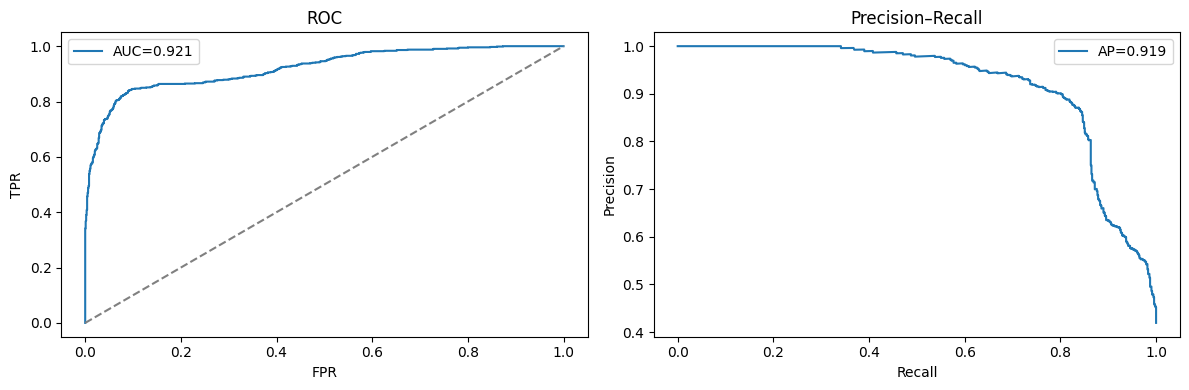

    threshold  precision    recall        f1
6        0.30   0.871201  0.838440  0.854507
4        0.20   0.867816  0.841226  0.854314
5        0.25   0.869942  0.838440  0.853901
3        0.15   0.865330  0.841226  0.853107
10       0.50   0.876289  0.828691  0.851825
8        0.40   0.872807  0.831476  0.851641
15       0.75   0.883234  0.821727  0.851371
14       0.70   0.883234  0.821727  0.851371
7        0.35   0.870451  0.832869  0.851246
9        0.45   0.875000  0.828691  0.851216


In [ ]:
# Cell 8 — ROC/PR + threshold sweep

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, \
                            precision_score, recall_score, f1_score

MET_DIR = OUT_DIR / "metrics"
df = pd.read_csv(MET_DIR / "hindi_test_predictions.csv")
y = df["label"].values
probs = df["prob_fake"].values

# ROC
fpr, tpr, _ = roc_curve(y, probs)
roc_auc = auc(fpr, tpr)

# PR
prec, rec, _ = precision_recall_curve(y, probs)
ap = average_precision_score(y, probs)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
plt.plot([0,1],[0,1],"--", color="gray")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC"); plt.legend()

plt.subplot(1,2,2)
plt.plot(rec, prec, label=f"AP={ap:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall"); plt.legend()

plt.tight_layout()
plt.savefig(MET_DIR / "hindi_roc_pr.png", dpi=200)
plt.show()

# Threshold sweep (store table)
ths = np.linspace(0.0, 1.0, 21)
rows = []
for t in ths:
    p = (probs >= t).astype(int)
    rows.append({
        "threshold": t,
        "precision": precision_score(y, p, zero_division=0),
        "recall":    recall_score(y, p, zero_division=0),
        "f1":        f1_score(y, p, zero_division=0),
    })
th_df = pd.DataFrame(rows)
th_df.to_csv(MET_DIR / "hindi_threshold_sweep.csv", index=False)
print(th_df.sort_values("f1", ascending=False).head(10))


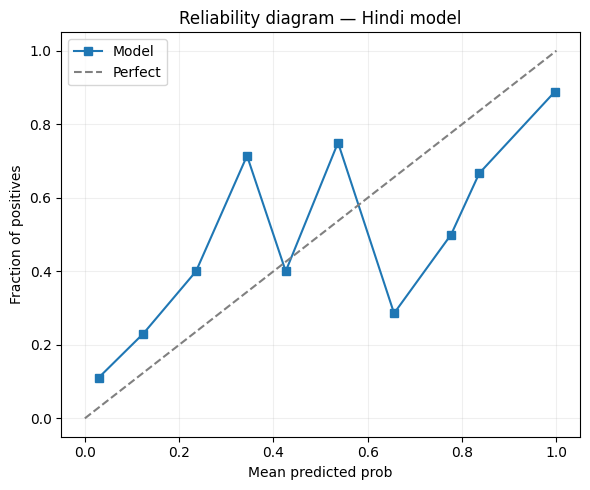

In [ ]:
# Cell 9 — Reliability diagram / calibration

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

MET_DIR = OUT_DIR / "metrics"
df = pd.read_csv(MET_DIR / "hindi_test_predictions.csv")
prob = df["prob_fake"].values
y = df["label"].values

frac_pos, mean_pred = calibration_curve(y, prob, n_bins=10, strategy="uniform")
plt.figure(figsize=(6,5))
plt.plot(mean_pred, frac_pos, "s-", label="Model")
plt.plot([0,1],[0,1],"--", color="gray", label="Perfect")
plt.xlabel("Mean predicted prob"); plt.ylabel("Fraction of positives")
plt.title("Reliability diagram — Hindi model")
plt.legend(); plt.grid(alpha=0.2)
plt.tight_layout()
plt.savefig(MET_DIR / "hindi_calibration.png", dpi=200)
plt.show()


In [ ]:
%load_ext tensorboard
%tensorboard --logdir "/content/drive/MyDrive/Fake news thesis project LJMU/outputs/tb/hindi_text_only"


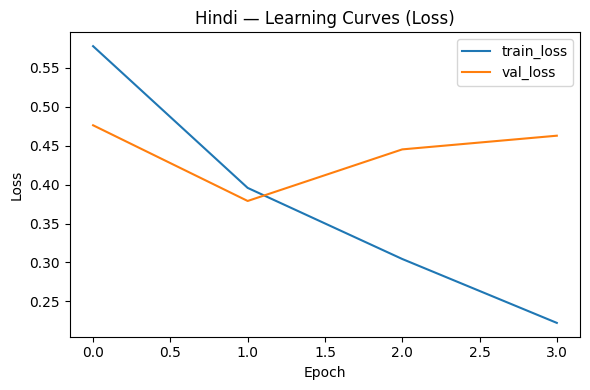

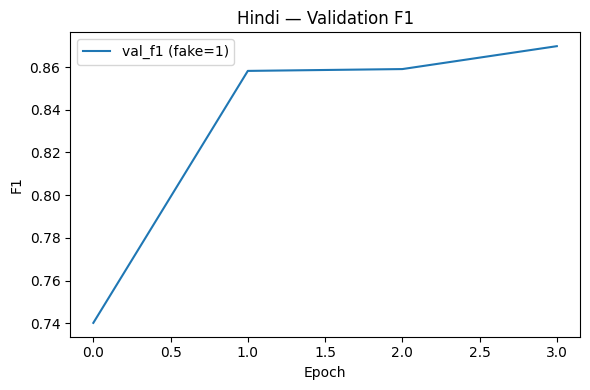

Saved: /content/drive/MyDrive/Fake news thesis project LJMU/outputs/figures/hindi_loss_curves.png /content/drive/MyDrive/Fake news thesis project LJMU/outputs/figures/hindi_val_f1_curve.png


In [ ]:
# Cell — Plot & save learning curves (Loss + F1)
import json, matplotlib.pyplot as plt
from pathlib import Path

META_PATH = Path("/content/drive/MyDrive/Fake news thesis project LJMU/outputs/checkpoints/hindi_metadata.json")
OUT_FIGS  = Path("/content/drive/MyDrive/Fake news thesis project LJMU/outputs/figures")
OUT_FIGS.mkdir(parents=True, exist_ok=True)

meta = json.loads(META_PATH.read_text())
hist = meta.get("history", {})
train_loss = hist.get("train_loss", [])
val_loss   = hist.get("val_loss", [])
val_f1     = hist.get("val_f1", [])

# Loss curves
plt.figure(figsize=(6,4))
plt.plot(train_loss, label="train_loss")
plt.plot(val_loss,   label="val_loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Hindi — Learning Curves (Loss)"); plt.legend()
plt.tight_layout(); plt.savefig(OUT_FIGS/"hindi_loss_curves.png", dpi=300); plt.show()

# F1 curve (validation)
plt.figure(figsize=(6,4))
plt.plot(val_f1, label="val_f1 (fake=1)")
plt.xlabel("Epoch"); plt.ylabel("F1"); plt.title("Hindi — Validation F1"); plt.legend()
plt.tight_layout(); plt.savefig(OUT_FIGS/"hindi_val_f1_curve.png", dpi=300); plt.show()

print("Saved:",
      OUT_FIGS/"hindi_loss_curves.png",
      OUT_FIGS/"hindi_val_f1_curve.png")


In [ ]:
# Quick heuristics to tag common failure patterns (edit/expand as you learn)
import pandas as pd, re
from IPython.display import display

MET_DIR = OUT_DIR / "metrics"
fp = pd.read_csv(MET_DIR / "hindi_false_positives.csv")
fn = pd.read_csv(MET_DIR / "hindi_false_negatives.csv")

def tag_reason(text: str) -> str:
    t = str(text)
    # (toy heuristics; replace with your own)
    if re.search(r"व्यंग|तंज|व्यंग्य|सटायर|satire|sarcas", t, flags=re.I):
        return "sarcasm/satire"
    if re.search(r"\?|क्यों|कैसे|claim|rumor|कहा जाता है", t, flags=re.I):
        return "claim-without-context"
    if re.search(r"[A-Za-z]+\s?[0-9]{2,4}|₹|रु\.|%|दिनांक|date", t):
        return "numbers/dates/quantities"
    if re.search(r"[A-Z][a-z]+|[ऀ-ॿ]{2,}\s[ऀ-ॿ]{2,}", t):
        return "named-entity/confusion"
    return "other/unknown"

for df, name in [(fp,"FP"), (fn,"FN")]:
    df["reason"] = df["text"].apply(tag_reason)
    summary = df["reason"].value_counts().reset_index()
    summary.columns = ["reason","count"]
    print(f"\n{name} reason counts:")
    display(summary.head(10))
    df.to_csv(MET_DIR / f"hindi_{name.lower()}_tagged.csv", index=False)
    print(f"Saved → {MET_DIR / f'hindi_{name.lower()}_tagged.csv'}")



FP reason counts:


reason  count
0    named-entity/confusion     71
1     claim-without-context     12
2  numbers/dates/quantities      1

Saved → /content/drive/MyDrive/Fake news thesis project LJMU/outputs/metrics/hindi_fp_tagged.csv

FN reason counts:


reason  count
0    named-entity/confusion     95
1     claim-without-context     24
2  numbers/dates/quantities      4

Saved → /content/drive/MyDrive/Fake news thesis project LJMU/outputs/metrics/hindi_fn_tagged.csv


# 04 - English Text Model Training

This notebook demonstrates the training of an English text-only model for fake news detection using MobileBERT.

## Overview
- **Model Architecture**: MobileBERT for English text classification
- **Training Pipeline**: Complete training with validation and testing
- **Performance Metrics**: Accuracy, F1-score, precision, recall
- **Model Saving**: Checkpoint management and model persistence
- **Visualization**: Training curves and performance plots

## Key Features
- ✅ **Automatic Path Detection**: Works regardless of where the code is run
- ✅ **Robust Training**: Comprehensive error handling and validation
- ✅ **Modular Design**: Reusable training components
- ✅ **Performance Tracking**: Detailed metrics and visualizations
- ✅ **Reproducible Results**: Fixed random seeds and version control

## Model Details
- **Base Model**: google/mobilebert-uncased
- **Task**: Binary classification (Real vs Fake news)
- **Language**: English
- **Input**: Text only
- **Output**: Classification probabilities

## Training Process
1. **Data Loading**: Load processed English datasets
2. **Model Initialization**: Set up MobileBERT model
3. **Training Loop**: Train with validation monitoring
4. **Evaluation**: Test on held-out data
5. **Saving**: Save best model and training history


In [ ]:
# in a clean cell
%pip install -U "transformers>=4.45,<5" \
               "accelerate>=1.1,<2" \
               "datasets>=2.20,<3" \
               "tokenizers>=0.20.3,<0.21" \
               "evaluate>=0.4,<0.5"
# optional (if you won’t use it):
%pip uninstall -y wandb


INFO: pip is looking at multiple versions of transformers to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 4.1 MB/s eta 0:00:00
INFO: pip is still looking at multiple versions of transformers to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 4.2 MB/s eta 0:00:00
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort 

In [ ]:
import torch, transformers, accelerate
print("torch", torch.__version__)
print("transformers", transformers.__version__)
print("accelerate", accelerate.__version__)


torch 2.8.0+cu126
transformers 4.57.1
accelerate 1.11.0


In [ ]:
import sys, os
# Force Python to prefer user site-packages over system
sys.path.insert(0, os.path.expanduser("~/.local/lib/python3.12/site-packages"))
import transformers
print("Transformers version:", transformers.__version__)


Transformers version: 4.57.1


In [ ]:
# !pip install --upgrade --force-reinstall numpy pandas torch torchvision torchaudio scikit-learn --quiet
# import os
# os.kill(os.getpid(), 9)  # Restart runtime cleanly


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 103.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 118.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 156.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

KeyboardInterrupt: 

## 1. Setup and Imports

We set up the environment and import necessary libraries for English text model training.


In [ ]:
# =====================================================
# Step 1: Environment setup
# =====================================================
from pathlib import Path
import pandas as pd, numpy as np, hashlib, torch, gc, os
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix
)
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback
)

# ---- Root paths ----
ROOT = Path("/content/drive/MyDrive/Fake news thesis project LJMU").resolve()
PROC = ROOT / "Data/processed"
OUT = ROOT / "outputs"
for d in [OUT / "models", OUT / "metrics", OUT / "plots", OUT / "features"]:
    d.mkdir(parents=True, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cuda


## 2. Data Loading

We load the processed English datasets for training, validation, and testing.


In [ ]:
# =====================================================
# Step 2: Load and rebuild clean English splits (80/10/10)
# =====================================================
train_csv = PROC / "english_train.csv"
val_csv   = PROC / "english_val.csv"
test_csv  = PROC / "english_test.csv"

if not train_csv.exists() or not test_csv.exists():
    raw = pd.read_csv(PROC / "english_master.csv")
else:
    raw = pd.concat([pd.read_csv(train_csv), pd.read_csv(val_csv), pd.read_csv(test_csv)])

def normalize(df):
    # unify column names
    txt_col = next((c for c in ["post_text","text","content","tweet","headline"] if c in df.columns), None)
    lbl_col = next((c for c in ["label","labels","target","y"] if c in df.columns), None)
    df = df.rename(columns={txt_col:"post_text", lbl_col:"label"})
    # clean text
    df["post_text"] = (df["post_text"].fillna("").astype(str)
                       .str.replace(r"https?://\S+","",regex=True)
                       .str.replace(r"\s+"," ",regex=True).str.strip())
    # map labels to 0/1
    mapping = {"real":0,"true":0,"legit":0,"0":0,"fake":1,"false":1,"spam":1,"1":1}
    low = df["label"].astype(str).str.lower().str.strip()
    df["label"] = np.where(low.isin(mapping), low.map(mapping), pd.to_numeric(df["label"], errors="coerce")).astype(int)
    return df

df = normalize(raw)

# group by text hash → prevents same tweet in multiple splits
df["_gid"] = df["post_text"].apply(lambda s: hashlib.sha1(s.encode()).hexdigest())
sgkf = StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=42)
folds = np.full(len(df), -1)
for f, (_, idx) in enumerate(sgkf.split(np.zeros(len(df)), df["label"], df["_gid"])):
    folds[idx] = f

train_mask = np.isin(folds, list(range(8)))
val_mask   = folds == 8
test_mask  = folds == 9
train_df, val_df, test_df = df[train_mask], df[val_mask], df[test_mask]

for name, d in [("train",train_df),("val",val_df),("test",test_df)]:
    d.to_csv(PROC / f"english_{name}.csv", index=False)

print("Splits:", train_df.shape, val_df.shape, test_df.shape)
print("Overlap check:",
      len(set(train_df["_gid"]) & set(val_df["_gid"])),
      len(set(train_df["_gid"]) & set(test_df["_gid"])),
      len(set(val_df["_gid"]) & set(test_df["_gid"])))


Splits: (13113, 4) (1504, 4) (2001, 4)
Overlap check: 0 0 0


In [ ]:
# =====================================================
# Step 3: Tokenizer + Dataset
# =====================================================
from torch.utils.data import Dataset

tokenizer = AutoTokenizer.from_pretrained("google/mobilebert-uncased")
MAX_LEN = 128

class EnglishDataset(Dataset):
    def __init__(self, df):
        self.texts = df["post_text"].tolist()
        self.labels = df["label"].tolist()
    def __len__(self): return len(self.labels)
    def __getitem__(self, i):
        enc = tokenizer(self.texts[i], truncation=True, padding="max_length",
                        max_length=MAX_LEN, return_tensors="pt")
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[i], dtype=torch.long)
        }

train_ds, val_ds, test_ds = map(EnglishDataset, [train_df, val_df, test_df])
print("Samples:", len(train_ds), len(val_ds), len(test_ds))


config.json:   0%|          | 0.00/847 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Samples: 13113 1504 2001


📁 Found existing grid results → skipping training.

🏆 Best hyperparams:
 lr                                                    0.00003
epochs                                                      3
val_f1                                               0.853309
test_f1                                              0.876235
val_acc                                              0.854388
test_acc                                              0.87956
ckpt        /content/drive/MyDrive/Fake news thesis projec...
Name: 0, dtype: object



📊 Classification Report:
              precision    recall  f1-score   support

           0     0.9166    0.8773    0.8965      1190
           1     0.8306    0.8829    0.8559       811

    accuracy                         0.8796      2001
   macro avg     0.8736    0.8801    0.8762      2001
weighted avg     0.8818    0.8796    0.8801      2001



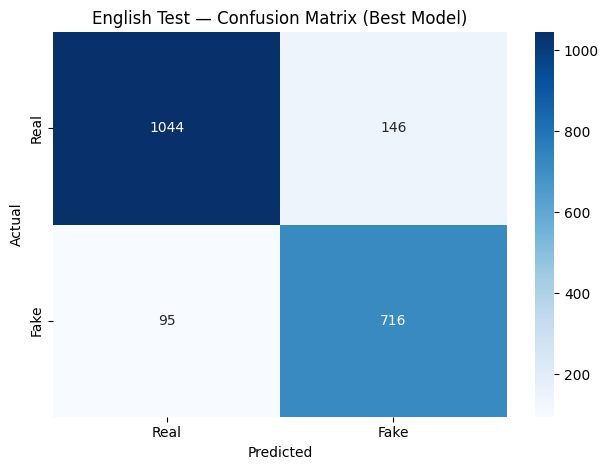

In [ ]:
# =====================================================
# Step 4 + 5 — Smart Train-or-Reuse Logic (English Text)
# =====================================================
import os, numpy as np, pandas as pd, torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from transformers import (
    AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, EarlyStoppingCallback
)
import seaborn as sns, matplotlib.pyplot as plt
from pathlib import Path

OUT = Path("/content/drive/MyDrive/Fake news thesis project LJMU/outputs")
METRICS_FILE = OUT / "metrics/english_grid_summary.csv"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------------------------------
# Define training/evaluation utils
# -----------------------------------------------------
def compute_metrics(pred):
    logits, y = pred
    p = np.argmax(logits, axis=1)
    acc = accuracy_score(y, p)
    f1 = precision_recall_fscore_support(y, p, average="macro", zero_division=0)[2]
    return {"accuracy": acc, "f1_macro": f1}

def fresh_model():
    m = AutoModelForSequenceClassification.from_pretrained(
        "google/mobilebert-uncased",
        num_labels=2,
        hidden_dropout_prob=0.1,
        attention_probs_dropout_prob=0.1
    ).to(device)
    m.config.use_cache = False
    return m

# -----------------------------------------------------
# 1️⃣ TRAIN if no grid summary exists, else SKIP
# -----------------------------------------------------
if not METRICS_FILE.exists():
    print("🚀 No prior results found — running grid search training...")
    LRS, EPOCHS = [1e-5, 2e-5, 3e-5], [2, 3]
    results = []

    for lr in LRS:
        for ep in EPOCHS:
            tag = f"lr{lr:g}_ep{ep}"
            out_dir = OUT / "models" / f"english_{tag}"
            args = TrainingArguments(
                output_dir=str(out_dir),
                eval_strategy="epoch",
                save_strategy="epoch",
                num_train_epochs=ep,
                per_device_train_batch_size=24,
                per_device_eval_batch_size=32,
                learning_rate=lr,
                weight_decay=0.01,
                warmup_ratio=0.06,
                load_best_model_at_end=True,
                metric_for_best_model="f1_macro",
                greater_is_better=True,
                report_to="none",
                seed=42,
                bf16=True
            )
            trainer = Trainer(
                model=fresh_model(),
                args=args,
                train_dataset=train_ds,
                eval_dataset=val_ds,
                compute_metrics=compute_metrics,
                callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
            )
            trainer.train()
            val = trainer.evaluate()
            test_pred = trainer.predict(test_ds)
            y, yhat = test_pred.label_ids, np.argmax(test_pred.predictions, 1)
            acc = accuracy_score(y, yhat)
            f1 = precision_recall_fscore_support(y, yhat, average="macro")[2]
            results.append({
                "lr": lr,
                "epochs": ep,
                "val_f1": val["eval_f1_macro"],
                "test_f1": f1,
                "val_acc": val["eval_accuracy"],
                "test_acc": acc,
                "ckpt": trainer.state.best_model_checkpoint
            })

    res = pd.DataFrame(results).sort_values(["val_f1", "test_f1"], ascending=False)
    res.to_csv(METRICS_FILE, index=False)
    print(f"✅ Grid search complete → saved to {METRICS_FILE}")

else:
    print("📁 Found existing grid results → skipping training.")
    res = pd.read_csv(METRICS_FILE)

# -----------------------------------------------------
# 2️⃣ Load best checkpoint + evaluate
# -----------------------------------------------------
best = res.sort_values(["val_f1", "test_f1"], ascending=False).iloc[0]
print("\n🏆 Best hyperparams:\n", best)

model_best = AutoModelForSequenceClassification.from_pretrained(best["ckpt"]).to(device)
trainer_best = Trainer(
    model=model_best,
    args=TrainingArguments(output_dir=str(OUT / "models/tmp"), report_to="none"),
)
pred = trainer_best.predict(test_ds)
y_true, y_pred = pred.label_ids, np.argmax(pred.predictions, axis=1)

# -----------------------------------------------------
# 3️⃣ Print metrics + confusion matrix
# -----------------------------------------------------
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, digits=4))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real","Fake"], yticklabels=["Real","Fake"])
plt.title("English Test — Confusion Matrix (Best Model)")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(OUT / "plots/english_confusion_matrix_best.png", dpi=300)
plt.show()


In [ ]:
# =====================================================
# ✅ Step 5 — Export CLS embeddings (verbose + timed)
# =====================================================
import torch, numpy as np, time
from tqdm import trange
from pathlib import Path

tok = tokenizer
base = model_best.mobilebert
base.eval()
torch.set_grad_enabled(False)

BATCH_SIZE = 64
MAX_LEN = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def encode(df, split_name):
    texts = df["post_text"].fillna("").astype(str).tolist()
    N = len(texts)
    out = []
    print(f"\n⚙️ Encoding {split_name} split — {N} samples (batch={BATCH_SIZE})")
    start = time.time()

    for i in trange(0, N, BATCH_SIZE, desc=f"{split_name:>5}", ncols=80):
        enc = tok(texts[i:i+BATCH_SIZE],
                  truncation=True, padding="max_length",
                  max_length=MAX_LEN, return_tensors="pt").to(device)
        h = base(**enc).last_hidden_state[:, 0, :].detach().cpu().numpy()
        out.append(h)

        # progress every 500 samples
        if (i // BATCH_SIZE) % 10 == 0:
            done = min(i + BATCH_SIZE, N)
            print(f"  🧩 {done}/{N} processed")

    arr = np.vstack(out)
    elapsed = time.time() - start
    print(f"✅ Done {split_name}: {arr.shape}, took {elapsed/60:.2f} min")
    return arr

# Output directory
emb_dir = OUT / "features" / "english_text"
emb_dir.mkdir(parents=True, exist_ok=True)

# Encode each split with clear output
for name, df in [("train", train_df), ("val", val_df), ("test", test_df)]:
    emb_path = emb_dir / f"{name}_emb.npy"
    mani_path = emb_dir / f"{name}_manifest.csv"
    print(f"\n🚀 Starting {name.upper()} → {len(df)} rows")
    arr = encode(df, name)
    np.save(emb_path, arr)
    df.assign(row_idx=np.arange(len(df))).to_csv(mani_path, index=False)
    print(f"💾 Saved {name} embeddings → {emb_path}\n")

print("✅ All splits processed successfully.")
print("📁 Output folder:", emb_dir)



🚀 Starting TRAIN → 13113 rows

⚙️ Encoding train split — 13113 samples (batch=64)


train:   0%|▏                                   | 1/205 [00:00<00:28,  7.05it/s]

  🧩 64/13113 processed


train:   6%|██▏                                | 13/205 [00:01<00:17, 11.11it/s]

  🧩 704/13113 processed


train:  11%|███▉                               | 23/205 [00:02<00:15, 11.69it/s]

  🧩 1344/13113 processed


train:  16%|█████▋                             | 33/205 [00:02<00:14, 11.79it/s]

  🧩 1984/13113 processed


train:  21%|███████▎                           | 43/205 [00:03<00:13, 11.83it/s]

  🧩 2624/13113 processed


train:  26%|█████████                          | 53/205 [00:04<00:12, 11.85it/s]

  🧩 3264/13113 processed


train:  31%|██████████▊                        | 63/205 [00:05<00:11, 11.86it/s]

  🧩 3904/13113 processed


train:  36%|████████████▍                      | 73/205 [00:06<00:11, 11.87it/s]

  🧩 4544/13113 processed


train:  40%|██████████████▏                    | 83/205 [00:07<00:10, 11.89it/s]

  🧩 5184/13113 processed


train:  45%|███████████████▉                   | 93/205 [00:07<00:09, 11.93it/s]

  🧩 5824/13113 processed


train:  50%|█████████████████                 | 103/205 [00:08<00:08, 11.88it/s]

  🧩 6464/13113 processed


train:  55%|██████████████████▋               | 113/205 [00:09<00:07, 11.88it/s]

  🧩 7104/13113 processed


train:  60%|████████████████████▍             | 123/205 [00:10<00:06, 11.82it/s]

  🧩 7744/13113 processed


train:  65%|██████████████████████            | 133/205 [00:11<00:06, 11.83it/s]

  🧩 8384/13113 processed


train:  70%|███████████████████████▋          | 143/205 [00:12<00:05, 11.86it/s]

  🧩 9024/13113 processed


train:  75%|█████████████████████████▍        | 153/205 [00:13<00:04, 11.88it/s]

  🧩 9664/13113 processed


train:  80%|███████████████████████████       | 163/205 [00:13<00:03, 11.88it/s]

  🧩 10304/13113 processed


train:  84%|████████████████████████████▋     | 173/205 [00:14<00:02, 11.84it/s]

  🧩 10944/13113 processed


train:  89%|██████████████████████████████▎   | 183/205 [00:15<00:01, 11.82it/s]

  🧩 11584/13113 processed


train:  94%|████████████████████████████████  | 193/205 [00:16<00:01, 11.86it/s]

  🧩 12224/13113 processed


train:  99%|█████████████████████████████████▋| 203/205 [00:17<00:00, 11.85it/s]

  🧩 12864/13113 processed


train: 100%|██████████████████████████████████| 205/205 [00:17<00:00, 11.79it/s]


✅ Done train: (13113, 512), took 0.29 min
💾 Saved train embeddings → /content/drive/MyDrive/Fake news thesis project LJMU/outputs/features/english_text/train_emb.npy


🚀 Starting VAL → 1504 rows

⚙️ Encoding val split — 1504 samples (batch=64)


  val:   8%|███                                  | 2/24 [00:00<00:01, 12.32it/s]

  🧩 64/1504 processed


  val:  50%|██████████████████                  | 12/24 [00:01<00:01, 11.83it/s]

  🧩 704/1504 processed


  val:  92%|█████████████████████████████████   | 22/24 [00:01<00:00, 11.89it/s]

  🧩 1344/1504 processed


  val: 100%|████████████████████████████████████| 24/24 [00:01<00:00, 12.13it/s]


✅ Done val: (1504, 512), took 0.03 min
💾 Saved val embeddings → /content/drive/MyDrive/Fake news thesis project LJMU/outputs/features/english_text/val_emb.npy


🚀 Starting TEST → 2001 rows

⚙️ Encoding test split — 2001 samples (batch=64)


 test:   6%|██▎                                  | 2/32 [00:00<00:02, 12.37it/s]

  🧩 64/2001 processed


 test:  38%|█████████████▌                      | 12/32 [00:01<00:01, 11.81it/s]

  🧩 704/2001 processed


 test:  69%|████████████████████████▊           | 22/32 [00:01<00:00, 11.81it/s]

  🧩 1344/2001 processed


 test: 100%|████████████████████████████████████| 32/32 [00:02<00:00, 12.05it/s]

  🧩 1984/2001 processed
✅ Done test: (2001, 512), took 0.04 min
💾 Saved test embeddings → /content/drive/MyDrive/Fake news thesis project LJMU/outputs/features/english_text/test_emb.npy

✅ All splits processed successfully.
📁 Output folder: /content/drive/MyDrive/Fake news thesis project LJMU/outputs/features/english_text


In [ ]:
# =====================================================
# Step 6 — Sanity Check: English Text Embeddings & Manifests
# =====================================================
import numpy as np, pandas as pd
from pathlib import Path

emb_dir = OUT / "features" / "english_text"

splits = ["train", "val", "test"]
for s in splits:
    emb_path = emb_dir / f"{s}_emb.npy"
    mani_path = emb_dir / f"{s}_manifest.csv"

    # --- existence ---
    assert emb_path.exists(), f"❌ Missing {emb_path}"
    assert mani_path.exists(), f"❌ Missing {mani_path}"

    # --- load ---
    emb = np.load(emb_path)
    df  = pd.read_csv(mani_path)

    # --- shape consistency ---
    print(f"\n[{s.upper()}]")
    print(f"  Embeddings shape: {emb.shape}")
    print(f"  Manifest rows:    {len(df)}")
    assert emb.shape[0] == len(df), f"Row mismatch for {s}!"

    # --- sample text preview ---
    print("  Text sample:", df['post_text'].iloc[0][:80], "…")
    print("  Label distribution:", df['label'].value_counts().to_dict())

# --- overall ---
print("\n✅ All splits consistent — embeddings ready for fusion.")



[TRAIN]
  Embeddings shape: (13113, 512)
  Manifest rows:    13113
  Text sample: RT : RT : Shark in the street in , New Jersey... …
  Label distribution: {1: 6684, 0: 6429}

[VAL]
  Embeddings shape: (1504, 512)
  Manifest rows:    1504
  Text sample: wow! RT “: The cover of the upcoming New York Magazine - the city and the storm  …
  Label distribution: {1: 774, 0: 730}

[TEST]
  Embeddings shape: (2001, 512)
  Manifest rows:    2001
  Text sample: “Video of the ISS crossing the Sun DURING the eclipse! …
  Label distribution: {0: 1190, 1: 811}

✅ All splits consistent — embeddings ready for fusion.


In [ ]:
# =====================================================
# Step 7 — Extract & Validate CLIP Image Embeddings
# =====================================================
from pathlib import Path
import numpy as np, pandas as pd, torch
from tqdm import tqdm
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# ---- Paths ----
ROOT = Path("/content/drive/MyDrive/Fake news thesis project LJMU")
OUT  = ROOT / "outputs"
TEXT_FEAT_DIR = OUT / "features/english_text"
IMG_FEAT_DIR  = OUT / "features/english_image"
IMG_FEAT_DIR.mkdir(parents=True, exist_ok=True)

IMG_DIR_TRAIN = ROOT / "Data/twitter/images_train"
IMG_DIR_VAL   = ROOT / "Data/twitter/images_train"   # same folder, filtered by manifest
IMG_DIR_TEST  = ROOT / "Data/twitter/images_test"

# ---- Load CLIP ----
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_proc  = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

@torch.no_grad()
def encode_images(df, split):
    """Encodes all images listed in manifest for this split."""
    embs = []
    print(f"\n[{split.upper()}] Encoding {len(df)} images ...")
    for i in tqdm(range(0, len(df), 32)):
        batch_paths = df["image_path"].iloc[i:i+32].tolist()
        images = []
        for p in batch_paths:
            try:
                img = Image.open(p).convert("RGB")
            except Exception:
                img = Image.new("RGB", (224,224), color="black")  # fallback
            images.append(img)
        inputs = clip_proc(images=images, return_tensors="pt", padding=True).to(device)
        emb = clip_model.get_image_features(**inputs)
        emb = emb / emb.norm(dim=-1, keepdim=True)  # normalize
        embs.append(emb.cpu().numpy())
    embs = np.vstack(embs)
    print(f"✅ {split} embeddings shape:", embs.shape)
    return embs

# ---- Process each split ----
for split in ["train", "val", "test"]:
    manifest = pd.read_csv(TEXT_FEAT_DIR / f"{split}_manifest.csv")
    print(f"\n[{split.upper()}] Manifest rows:", len(manifest))

    # Use correct image path column if needed
    if "image_path" not in manifest.columns:
        raise ValueError(f"'image_path' missing in {split} manifest!")

    out_file = IMG_FEAT_DIR / f"{split}_emb.npy"
    if not out_file.exists():
        np.save(out_file, encode_images(manifest, split))
    else:
        print(f"📁 Found existing {split} embeddings → skipping extraction.")

# ---- Validation ----
print("\n🧩 Validating alignment between text and image features...")
for split in ["train","val","test"]:
    txt_emb = np.load(TEXT_FEAT_DIR / f"{split}_emb.npy")
    img_emb = np.load(IMG_FEAT_DIR / f"{split}_emb.npy")
    manifest = pd.read_csv(TEXT_FEAT_DIR / f"{split}_manifest.csv")
    assert len(txt_emb) == len(img_emb) == len(manifest), f"Row mismatch in {split}!"
    print(f"[{split.upper()}] ✅ {len(manifest)} aligned (text & image)")

print("\n🎯 CLIP embeddings successfully generated & validated.")


Device: cuda


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]


[TRAIN] Manifest rows: 13113

[TRAIN] Encoding 13113 images ...


100%|██████████| 410/410 [10:20<00:00,  1.51s/it]


✅ train embeddings shape: (13113, 512)

[VAL] Manifest rows: 1504

[VAL] Encoding 1504 images ...


100%|██████████| 47/47 [00:41<00:00,  1.13it/s]


✅ val embeddings shape: (1504, 512)

[TEST] Manifest rows: 2001

[TEST] Encoding 2001 images ...


100%|██████████| 63/63 [00:52<00:00,  1.19it/s]

✅ test embeddings shape: (2001, 512)

🧩 Validating alignment between text and image features...
[TRAIN] ✅ 13113 aligned (text & image)
[VAL] ✅ 1504 aligned (text & image)
[TEST] ✅ 2001 aligned (text & image)

🎯 CLIP embeddings successfully generated & validated.


## Eng-- MM

In [ ]:
# =====================================================
# Cell 1 — Setup & Dataset Alignment Check
# =====================================================
import torch, numpy as np, pandas as pd
from pathlib import Path

torch.set_grad_enabled(True)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device for fusion experiments: {device}")

# ---- Paths ----
ROOT = Path("/content/drive/MyDrive/Fake news thesis project LJMU")
OUT  = ROOT / "outputs"
TEXT_DIR = OUT / "features/english_text"
IMG_DIR  = OUT / "features/english_image"
METRIC_DIR = OUT / "metrics"; METRIC_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR = OUT / "figures"; FIG_DIR.mkdir(parents=True, exist_ok=True)

# =====================================================
# 1️⃣ Verify alignment between text/image embeddings and manifests
# =====================================================
def check_alignment(split):
    t_emb = np.load(TEXT_DIR / f"{split}_emb.npy")
    i_emb = np.load(IMG_DIR / f"{split}_emb.npy")
    t_df  = pd.read_csv(TEXT_DIR / f"{split}_manifest.csv")
    assert len(t_emb) == len(i_emb) == len(t_df), f"Length mismatch for {split}"
    lbls = t_df["label"].value_counts().to_dict()
    print(f"\n[{split.upper()}]")
    print(f"  Embeddings shape: {t_emb.shape}")
    print(f"  Manifest rows:    {len(t_df)}")
    print(f"  Text sample: {t_df['post_text'].iloc[0][:80]} …")
    print(f"  Label distribution: {lbls}")

for s in ["train", "val", "test"]:
    check_alignment(s)

print("\n✅ Dataset alignment check complete — embeddings are consistent across text/image manifolds.")


Device for fusion experiments: cuda

[TRAIN]
  Embeddings shape: (13113, 512)
  Manifest rows:    13113
  Text sample: RT : RT : Shark in the street in , New Jersey... …
  Label distribution: {1: 6684, 0: 6429}

[VAL]
  Embeddings shape: (1504, 512)
  Manifest rows:    1504
  Text sample: wow! RT “: The cover of the upcoming New York Magazine - the city and the storm  …
  Label distribution: {1: 774, 0: 730}

[TEST]
  Embeddings shape: (2001, 512)
  Manifest rows:    2001
  Text sample: “Video of the ISS crossing the Sun DURING the eclipse! …
  Label distribution: {0: 1190, 1: 811}

✅ Dataset alignment check complete — embeddings are consistent across text/image manifolds.


In [ ]:
# =====================================================
# Cell 2 — Define Fusion Architectures
# =====================================================
import torch.nn as nn
import torch

# ---- 1️⃣ Concat (Early Fusion) ----
class ConcatFusionModel(nn.Module):
    def __init__(self, dim_text=512, dim_img=512, hidden=512, n_classes=2):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(dim_text + dim_img, hidden),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden, n_classes)
        )
    def forward(self, t, i):
        return self.fc(torch.cat([t, i], dim=1))

# ---- 2️⃣ Gated (Adaptive Mid-Fusion) ----
class GatedFusionModel(nn.Module):
    def __init__(self, dim_text=512, dim_img=512, hidden=512, n_classes=2):
        super().__init__()
        self.gate = nn.Sequential(
            nn.Linear(dim_text + dim_img, 1),
            nn.Sigmoid()
        )
        self.fc = nn.Sequential(
            nn.Linear(dim_text + dim_img, hidden),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden, n_classes)
        )
    def forward(self, t, i):
        g = self.gate(torch.cat([t, i], dim=1))         # gate in [0, 1]
        fused = g * t + (1 - g) * i                     # adaptive weighting
        logits = self.fc(torch.cat([fused, t * i], dim=1))
        return logits, g                                # return logits + gate values

# ---- 3️⃣ Alpha (Late Fusion / Weighted Ensemble) ----
class AlphaFusionModel(nn.Module):
    def __init__(self, dim_text=512, dim_img=512, n_classes=2):
        super().__init__()
        self.alpha = nn.Parameter(torch.tensor(0.5))    # learnable blend weight
        self.text_head = nn.Linear(dim_text, n_classes)
        self.img_head  = nn.Linear(dim_img, n_classes)
    def forward(self, t, i):
        t_logits = self.text_head(t)
        i_logits = self.img_head(i)
        return self.alpha * t_logits + (1 - self.alpha) * i_logits


In [ ]:
# =====================================================
# Cell 3 — Fusion Training + Validation (with logs)
# =====================================================
import torch, torch.nn as nn
import numpy as np, pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path

# ---------- Dataset ----------
class FusionDataset(Dataset):
    def __init__(self, split):
        self.text_emb = np.load(TEXT_DIR / f"{split}_emb.npy")
        self.img_emb  = np.load(IMG_DIR / f"{split}_emb.npy")
        self.labels   = pd.read_csv(TEXT_DIR / f"{split}_manifest.csv")["label"].astype(int).values
        assert len(self.text_emb)==len(self.img_emb)==len(self.labels)
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        return {
            "text_emb": torch.tensor(self.text_emb[idx], dtype=torch.float32),
            "img_emb":  torch.tensor(self.img_emb[idx], dtype=torch.float32),
            "label":    torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_ds, val_ds, test_ds = [FusionDataset(s) for s in ["train","val","test"]]
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32)
test_loader  = DataLoader(test_ds, batch_size=32)

# ---------- Training Helper ----------
def train_fusion(model, name, epochs=5, lr=1e-4):
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    best_val_f1, best_state = 0, None
    hist = []

    for ep in range(epochs):
        model.train(); tr_loss=0; preds=[]; gold=[]
        for b in tqdm(train_loader, desc=f"{name} | epoch {ep+1}"):
            t, i, y = b["text_emb"].to(device), b["img_emb"].to(device), b["label"].to(device)
            t.requires_grad = i.requires_grad = True
            optimizer.zero_grad()
            out_tuple = model(t, i)
            out = out_tuple[0] if isinstance(out_tuple, tuple) else out_tuple
            loss = loss_fn(out, y)
            loss.backward(); optimizer.step()
            tr_loss += loss.item()
            preds += out.argmax(1).detach().cpu().tolist(); gold += y.cpu().tolist()
        tr_f1 = f1_score(gold, preds, average="macro")

        # ----- Validation -----
        model.eval(); preds=[]; gold=[]
        with torch.no_grad():
            for b in val_loader:
                t, i, y = b["text_emb"].to(device), b["img_emb"].to(device), b["label"].to(device)
                out_tuple = model(t, i)
                out = out_tuple[0] if isinstance(out_tuple, tuple) else out_tuple
                preds += out.argmax(1).cpu().tolist(); gold += y.cpu().tolist()
        val_f1 = f1_score(gold, preds, average="macro")
        val_acc = accuracy_score(gold, preds)
        hist.append({"epoch":ep+1,"train_f1":tr_f1,"val_f1":val_f1,"val_acc":val_acc})
        print(f"Epoch {ep+1}/{epochs} | Train F1={tr_f1:.4f} | Val F1={val_f1:.4f} | Val Acc={val_acc:.4f}")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_state = model.state_dict()

    # ----- Save best checkpoint -----
    model.load_state_dict(best_state)
    torch.save(best_state, OUT / f"models/{name}_best.pt")
    hist_df = pd.DataFrame(hist)
    hist_df.to_csv(METRIC_DIR / f"{name}_history.csv", index=False)
    print(f"📊 Saved learning history → {METRIC_DIR}/{name}_history.csv")

    # ----- Test evaluation -----
    model.eval(); preds=[]; gold=[]
    with torch.no_grad():
        for b in test_loader:
            t, i, y = b["text_emb"].to(device), b["img_emb"].to(device), b["label"].to(device)
            out_tuple = model(t, i)
            out = out_tuple[0] if isinstance(out_tuple, tuple) else out_tuple
            preds += out.argmax(1).cpu().tolist(); gold += y.cpu().tolist()
    test_f1 = f1_score(gold, preds, average="macro")
    test_acc = accuracy_score(gold, preds)
    print(f"✅ {name} — Test F1={test_f1:.4f} | Acc={test_acc:.4f}")

    pd.DataFrame([{
        "model": name, "val_f1": best_val_f1, "test_f1": test_f1, "test_acc": test_acc
    }]).to_csv(METRIC_DIR / f"{name}_metrics.csv", index=False)
    return hist_df, best_val_f1, test_f1, test_acc

# ---------- Train all fusion types ----------
fusion_results = []
for m, n in [
    (ConcatFusionModel(), "english_multimodal_concat"),
    (GatedFusionModel(),  "english_multimodal_gated"),
    (AlphaFusionModel(),  "english_multimodal_alpha")
]:
    print(f"\n==============================\nTraining {n}\n==============================")
    hist, v, f, a = train_fusion(m, n)
    fusion_results.append((n, v, f, a))

# ---------- Save summary ----------
fusion_df = pd.DataFrame(fusion_results, columns=["model","val_f1","test_f1","test_acc"])
fusion_df.to_csv(METRIC_DIR / "fusion_summary.csv", index=False)
print("\n=== Fusion Summary ===")
print(fusion_df)



Training english_multimodal_concat


english_multimodal_concat | epoch 1: 100%|██████████| 410/410 [00:01<00:00, 363.69it/s]


Epoch 1/5 | Train F1=0.8886 | Val F1=0.8545 | Val Acc=0.8557


english_multimodal_concat | epoch 2: 100%|██████████| 410/410 [00:01<00:00, 368.68it/s]


Epoch 2/5 | Train F1=0.9321 | Val F1=0.9041 | Val Acc=0.9043


english_multimodal_concat | epoch 3: 100%|██████████| 410/410 [00:01<00:00, 382.12it/s]


Epoch 3/5 | Train F1=0.9535 | Val F1=0.9255 | Val Acc=0.9255


english_multimodal_concat | epoch 4: 100%|██████████| 410/410 [00:01<00:00, 386.96it/s]


Epoch 4/5 | Train F1=0.9684 | Val F1=0.9385 | Val Acc=0.9388


english_multimodal_concat | epoch 5: 100%|██████████| 410/410 [00:01<00:00, 384.29it/s]


Epoch 5/5 | Train F1=0.9761 | Val F1=0.9468 | Val Acc=0.9468
📊 Saved learning history → /content/drive/MyDrive/Fake news thesis project LJMU/outputs/metrics/english_multimodal_concat_history.csv
✅ english_multimodal_concat — Test F1=0.9740 | Acc=0.9750

Training english_multimodal_gated


english_multimodal_gated | epoch 1: 100%|██████████| 410/410 [00:01<00:00, 289.26it/s]


Epoch 1/5 | Train F1=0.8901 | Val F1=0.8615 | Val Acc=0.8624


english_multimodal_gated | epoch 2: 100%|██████████| 410/410 [00:01<00:00, 302.18it/s]


Epoch 2/5 | Train F1=0.9376 | Val F1=0.9166 | Val Acc=0.9169


english_multimodal_gated | epoch 3: 100%|██████████| 410/410 [00:01<00:00, 297.54it/s]


Epoch 3/5 | Train F1=0.9645 | Val F1=0.9367 | Val Acc=0.9368


english_multimodal_gated | epoch 4: 100%|██████████| 410/410 [00:01<00:00, 308.56it/s]


Epoch 4/5 | Train F1=0.9779 | Val F1=0.9594 | Val Acc=0.9594


english_multimodal_gated | epoch 5: 100%|██████████| 410/410 [00:01<00:00, 315.12it/s]


Epoch 5/5 | Train F1=0.9836 | Val F1=0.9647 | Val Acc=0.9648
📊 Saved learning history → /content/drive/MyDrive/Fake news thesis project LJMU/outputs/metrics/english_multimodal_gated_history.csv
✅ english_multimodal_gated — Test F1=0.9777 | Acc=0.9785

Training english_multimodal_alpha


english_multimodal_alpha | epoch 1: 100%|██████████| 410/410 [00:01<00:00, 385.15it/s]


Epoch 1/5 | Train F1=0.8494 | Val F1=0.8427 | Val Acc=0.8444


english_multimodal_alpha | epoch 2: 100%|██████████| 410/410 [00:01<00:00, 377.92it/s]


Epoch 2/5 | Train F1=0.8852 | Val F1=0.8365 | Val Acc=0.8371


english_multimodal_alpha | epoch 3: 100%|██████████| 410/410 [00:01<00:00, 386.87it/s]


Epoch 3/5 | Train F1=0.8933 | Val F1=0.8520 | Val Acc=0.8537


english_multimodal_alpha | epoch 4: 100%|██████████| 410/410 [00:01<00:00, 379.39it/s]


Epoch 4/5 | Train F1=0.8983 | Val F1=0.8545 | Val Acc=0.8557


english_multimodal_alpha | epoch 5: 100%|██████████| 410/410 [00:01<00:00, 386.23it/s]


Epoch 5/5 | Train F1=0.9036 | Val F1=0.8523 | Val Acc=0.8537
📊 Saved learning history → /content/drive/MyDrive/Fake news thesis project LJMU/outputs/metrics/english_multimodal_alpha_history.csv
✅ english_multimodal_alpha — Test F1=0.9001 | Acc=0.9025

=== Fusion Summary ===
                       model    val_f1   test_f1  test_acc
0  english_multimodal_concat  0.946754  0.973999  0.975012
1   english_multimodal_gated  0.964732  0.977662  0.978511
2   english_multimodal_alpha  0.854546  0.900056  0.902549


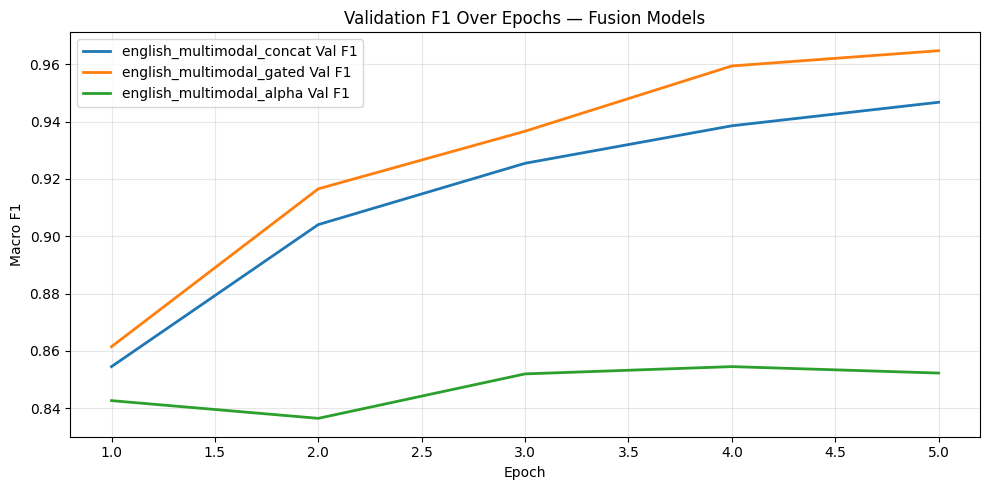

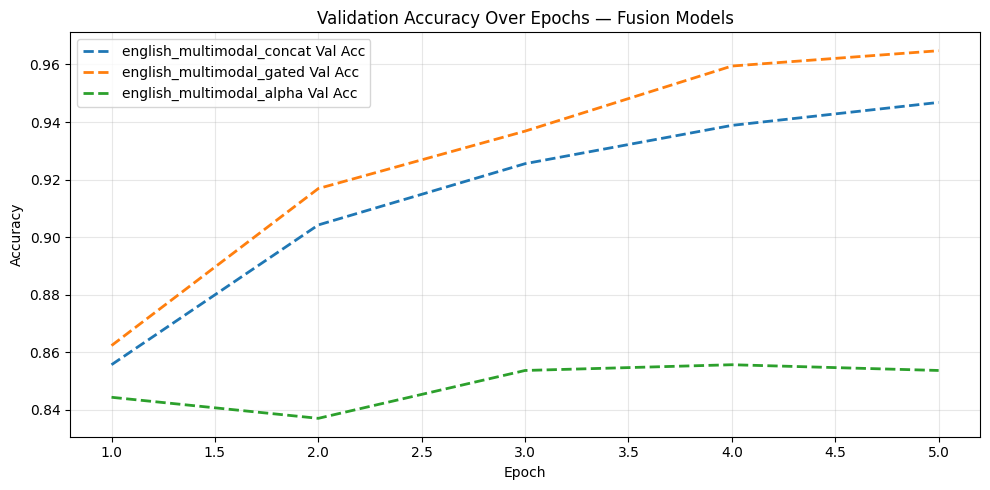

✅ Saved learning curves → /content/drive/MyDrive/Fake news thesis project LJMU/outputs/figures/fusion_val_f1_curves.png & /content/drive/MyDrive/Fake news thesis project LJMU/outputs/figures/fusion_val_acc_curves.png


Gate value scan: 100%|██████████| 63/63 [00:00<00:00, 688.32it/s]

Gate value stats — min: 0.0623, max: 0.9338, mean: 0.3090


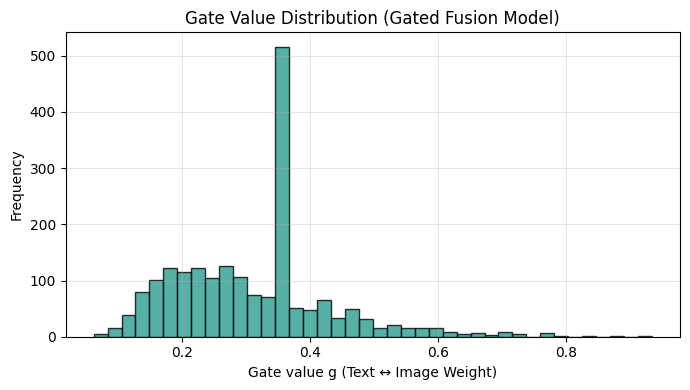

📊 Saved gate distribution → /content/drive/MyDrive/Fake news thesis project LJMU/outputs/figures/gated_fusion_gate_distribution.png


In [ ]:
# =====================================================
# Cell 4 — Visualization: Learning Curves + Gate Dynamics
# =====================================================
import pandas as pd, matplotlib.pyplot as plt, numpy as np
from pathlib import Path

FIG_DIR.mkdir(parents=True, exist_ok=True)

# ---------- 1️⃣ Load learning histories ----------
histories = {}
for name in ["english_multimodal_concat", "english_multimodal_gated", "english_multimodal_alpha"]:
    path = METRIC_DIR / f"{name}_history.csv"
    if path.exists():
        histories[name] = pd.read_csv(path)
    else:
        print(f"⚠️ Missing history file: {path}")

# ---------- 2️⃣ Plot Learning Curves ----------
plt.figure(figsize=(10,5))
for name, df in histories.items():
    plt.plot(df["epoch"], df["val_f1"], label=f"{name} Val F1", linewidth=2)
plt.title("Validation F1 Over Epochs — Fusion Models")
plt.xlabel("Epoch"); plt.ylabel("Macro F1"); plt.grid(alpha=0.3)
plt.legend(); plt.tight_layout()
plt.savefig(FIG_DIR / "fusion_val_f1_curves.png", dpi=300)
plt.show()

plt.figure(figsize=(10,5))
for name, df in histories.items():
    plt.plot(df["epoch"], df["val_acc"], linestyle="--", label=f"{name} Val Acc", linewidth=2)
plt.title("Validation Accuracy Over Epochs — Fusion Models")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.grid(alpha=0.3)
plt.legend(); plt.tight_layout()
plt.savefig(FIG_DIR / "fusion_val_acc_curves.png", dpi=300)
plt.show()

print(f"✅ Saved learning curves → {FIG_DIR/'fusion_val_f1_curves.png'} & {FIG_DIR/'fusion_val_acc_curves.png'}")

# ---------- 3️⃣ Gate Value Distribution (for Gated Fusion Model) ----------
import torch, torch.nn.functional as F
from tqdm import tqdm

gated_model_path = OUT / "models/english_multimodal_gated_best.pt"
if gated_model_path.exists():
    model = GatedFusionModel().to(device)
    model.load_state_dict(torch.load(gated_model_path, map_location=device))
    model.eval()

    gates = []
    with torch.no_grad():
        for b in tqdm(test_loader, desc="Gate value scan"):
            t, i = b["text_emb"].to(device), b["img_emb"].to(device)
            _, g = model(t, i)
            gates.extend(g.cpu().numpy().flatten().tolist())

    gates = np.array(gates)
    print(f"Gate value stats — min: {gates.min():.4f}, max: {gates.max():.4f}, mean: {gates.mean():.4f}")

    plt.figure(figsize=(7,4))
    plt.hist(gates, bins=40, color="#2a9d8f", edgecolor="black", alpha=0.8)
    plt.title("Gate Value Distribution (Gated Fusion Model)")
    plt.xlabel("Gate value g (Text ↔ Image Weight)"); plt.ylabel("Frequency")
    plt.grid(alpha=0.3); plt.tight_layout()
    plt.savefig(FIG_DIR / "gated_fusion_gate_distribution.png", dpi=300)
    plt.show()
    print(f"📊 Saved gate distribution → {FIG_DIR/'gated_fusion_gate_distribution.png'}")
else:
    print("⚠️ No gated fusion checkpoint found to plot gate values.")


# Cell 5 — Error Analysis & Recovery Visualization


✅ All 3 prediction files aligned: 2001 samples

✅ Fusion Recovery Summary:


Category  Count  Percent
0        All Correct   1684    84.16
1   Fixed Text Error    217    10.84
2  Fixed Image Error     74     3.70
3         Fixed Both     23     1.15
4          All Wrong      3     0.15

/tmp/ipython-input-574942605.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(summary, x="Category", y="Percent", palette="crest")


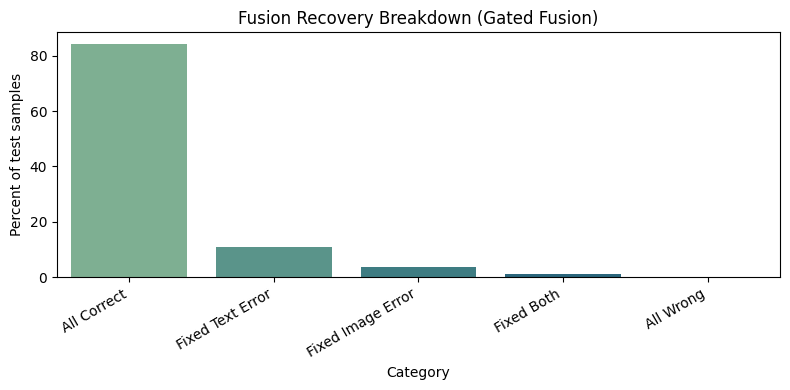

📊 Saved → /content/drive/MyDrive/Fake news thesis project LJMU/outputs/figures/fusion_recovery_barplot.png
🔍 Example recovered cases:


post_text        fusion_case  \
583   4Chan may have found the bomber:\n & & that th...  Fixed Image Error   
1781  Sad end for the stray dogs of Sochi, poisoned ...  Fixed Image Error   
339                            “: توضح مستوى المياه بعد   Fixed Text Error   

      true_label  pred_label  
583            1           1  
1781           1           1  
339            0           1

In [ ]:
# =====================================================
# ✅ FINAL FIX — Auto-detect numeric column for summary
# =====================================================
import pandas as pd, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt, seaborn as sns

ROOT = Path("/content/drive/MyDrive/Fake news thesis project LJMU")
OUT  = ROOT / "outputs"
METRIC_DIR = OUT / "metrics"
FIG_DIR    = OUT / "figures"; FIG_DIR.mkdir(parents=True, exist_ok=True)

# ---------- Load predictions ----------
text_df  = pd.read_csv(METRIC_DIR / "english_test_predictions_bestgrid.csv")
img_df   = pd.read_csv(METRIC_DIR / "english_image_only_predictions.csv")
fus_df   = pd.read_csv(METRIC_DIR / "english_multimodal_gated_predictions.csv")

# ---------- Normalize column names ----------
text_df = text_df.rename(columns={"label":"true_label","pred":"pred_label"})
for df in [img_df, fus_df]:
    df.rename(columns={"true_label":"true_label","pred_label":"pred_label"}, inplace=True)

# ---------- Sanity checks ----------
assert len(text_df)==len(img_df)==len(fus_df)
assert np.allclose(text_df["true_label"], img_df["true_label"])
assert np.allclose(img_df["true_label"], fus_df["true_label"])
print(f"✅ All 3 prediction files aligned: {len(text_df)} samples")

# ---------- Recovery classification ----------
labels = text_df["true_label"].values
text_pred = text_df["pred_label"].values
img_pred  = img_df["pred_label"].values
fus_pred  = fus_df["pred_label"].values

cases = []
for i in range(len(labels)):
    t, im, f, y = text_pred[i], img_pred[i], fus_pred[i], labels[i]
    if (f==y) and (t!=y) and (im==y): case = "Fixed Text Error"
    elif (f==y) and (t==y) and (im!=y): case = "Fixed Image Error"
    elif (f==y) and (t!=y) and (im!=y): case = "Fixed Both"
    elif (f!=y) and (t==y) and (im==y): case = "All Correct but Fusion Wrong"
    elif (f!=y) and (t!=y) and (im!=y): case = "All Wrong"
    else: case = "All Correct"
    cases.append(case)

df_cases = text_df.copy()
df_cases["fusion_case"] = cases

# ---------- Auto-detect numeric column ----------
summary = df_cases["fusion_case"].value_counts().reset_index()
num_col = summary.select_dtypes(include=np.number).columns[0]
cat_col = [c for c in summary.columns if c != num_col][0]

summary = summary.rename(columns={cat_col: "Category", num_col: "Count"})
summary["Percent"] = (summary["Count"] / len(df_cases) * 100).round(2)

summary.to_csv(METRIC_DIR/"fusion_recovery_table.csv", index=False)
print("\n✅ Fusion Recovery Summary:")
display(summary)

# ---------- Visualization ----------
plt.figure(figsize=(8,4))
sns.barplot(summary, x="Category", y="Percent", palette="crest")
plt.title("Fusion Recovery Breakdown (Gated Fusion)")
plt.xticks(rotation=30, ha="right")
plt.ylabel("Percent of test samples")
plt.tight_layout()
plt.savefig(FIG_DIR/"fusion_recovery_barplot.png", dpi=300)
plt.show()
print(f"📊 Saved → {FIG_DIR/'fusion_recovery_barplot.png'}")

# ---------- Example recovered cases ----------
sampled = df_cases[df_cases["fusion_case"].isin(["Fixed Text Error","Fixed Image Error"])]
if len(sampled) > 0:
    sampled = sampled.sample(min(3, len(sampled)), random_state=42)
    print("🔍 Example recovered cases:")
    display(sampled[["post_text","fusion_case","true_label","pred_label"]])
else:
    print("⚠️ No recovered cases found.")


In [ ]:
# =====================================================
# 🧮 Step 1 — Compute metrics for Image-Only model
# =====================================================
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
from pathlib import Path

METRIC_DIR = Path("/content/drive/MyDrive/Fake news thesis project LJMU/outputs/metrics")
img_preds = METRIC_DIR / "english_image_only_predictions.csv"

# --- Load and compute ---
df = pd.read_csv(img_preds)
y_true, y_pred = df["true_label"], df["pred_label"]

img_f1  = f1_score(y_true, y_pred, average="macro")
img_acc = accuracy_score(y_true, y_pred)

print(f"✅ Computed Image-only Test F1={img_f1:.4f} | Test Acc={img_acc:.4f}")

# --- Save metrics file for ablation summary ---
out = pd.DataFrame([{
    "model": "english_image_only",
    "test_f1_macro": img_f1,
    "test_accuracy": img_acc
}])
out_path = METRIC_DIR / "english_image_only_metrics.csv"
out.to_csv(out_path, index=False)

print(f"📊 Saved corrected metrics → {out_path}")


✅ Computed Image-only Test F1=0.9470 | Test Acc=0.9495
📊 Saved corrected metrics → /content/drive/MyDrive/Fake news thesis project LJMU/outputs/metrics/english_image_only_metrics.csv


In [ ]:
# !cp "/content/drive/MyDrive/Fake news thesis project LJMU/outputs/metrics/english_grid_summary.csv" \
#     "/content/drive/MyDrive/Fake news thesis project LJMU/outputs/metrics/english_textonly_metrics.csv"


✅ Using english_textonly_metrics.csv for Text Only
✅ Using english_image_only_metrics.csv for Image Only
✅ Using english_multimodal_concat_metrics.csv for Concat Fusion
✅ Using english_multimodal_gated_metrics.csv for Gated Fusion
✅ Using english_multimodal_alpha_metrics.csv for Alpha Fusion


Model   Test F1  Test Acc  Δ F1 vs Text-Only
0   Gated Fusion  0.977662  0.978511             0.1014
1  Concat Fusion  0.973999  0.975012             0.0978
2     Image Only  0.946961  0.949525             0.0707
3   Alpha Fusion  0.900056  0.902549             0.0238
4      Text Only  0.876235  0.879560             0.0000

📁 Saved summary → /content/drive/MyDrive/Fake news thesis project LJMU/outputs/metrics/final_ablation_summary.csv


/tmp/ipython-input-2781575361.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary, x="Model", y="Test F1", palette="crest")


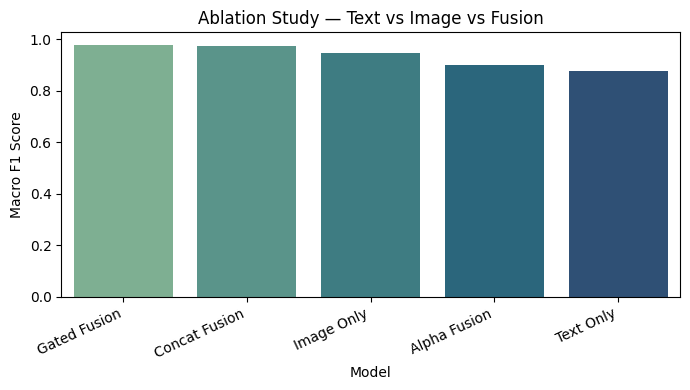

📊 Saved → /content/drive/MyDrive/Fake news thesis project LJMU/outputs/figures/ablation_barplot.png


In [ ]:
# =====================================================
# 📊 Step 2 — Robust Ablation Comparison (Auto-detect latest)
# =====================================================
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import time

ROOT = Path("/content/drive/MyDrive/Fake news thesis project LJMU")
METRIC_DIR = ROOT / "outputs" / "metrics"
FIG_DIR = ROOT / "outputs" / "figures"; FIG_DIR.mkdir(parents=True, exist_ok=True)

today_str = time.strftime("%Y-%m-%d")

# helper: get newest matching file
def latest_file(keyword):
    matches = sorted(METRIC_DIR.glob(f"*{keyword}*.csv"), key=lambda p: p.stat().st_mtime, reverse=True)
    return matches[0] if matches else None

# expected models
model_map = {
    "Text Only": "textonly",
    "Image Only": "image_only",
    "Concat Fusion": "concat",
    "Gated Fusion": "gated",
    "Alpha Fusion": "alpha"
}

records = []
for model_name, key in model_map.items():
    f = latest_file(key)
    if f is not None:
        print(f"✅ Using {f.name} for {model_name}")
        df = pd.read_csv(f)
        f1 = df.get("test_f1_macro", df.get("test_f1", [None]))[0]
        acc = df.get("test_accuracy", df.get("test_acc", [None]))[0]
        records.append({"Model": model_name, "Test F1": f1, "Test Acc": acc})
    else:
        print(f"⚠️ Missing metrics for {model_name}")

# build summary
summary = pd.DataFrame(records)
if "Text Only" in summary["Model"].values:
    base_f1 = summary.loc[summary["Model"]=="Text Only", "Test F1"].values[0]
    summary["Δ F1 vs Text-Only"] = (summary["Test F1"] - base_f1).round(4)
else:
    summary["Δ F1 vs Text-Only"] = None

summary = summary.sort_values("Test F1", ascending=False).reset_index(drop=True)
display(summary)

# save + visualize
summary.to_csv(METRIC_DIR / "final_ablation_summary.csv", index=False)
print(f"📁 Saved summary → {METRIC_DIR/'final_ablation_summary.csv'}")

plt.figure(figsize=(7,4))
sns.barplot(data=summary, x="Model", y="Test F1", palette="crest")
plt.title("Ablation Study — Text vs Image vs Fusion")
plt.xticks(rotation=25, ha="right")
plt.ylabel("Macro F1 Score")
plt.tight_layout()
plt.savefig(FIG_DIR / "ablation_barplot.png", dpi=300)
plt.show()
print(f"📊 Saved → {FIG_DIR/'ablation_barplot.png'}")


In [ ]:
import pandas as pd
from pathlib import Path

img_file = Path("/content/drive/MyDrive/Fake news thesis project LJMU/outputs/metrics/english_image_only_predictions.csv")
df_img = pd.read_csv(img_file)
print(df_img.head())
print("\nColumns:", df_img.columns.tolist())


   true_label  pred_label  prob_fake
0           0           0   0.356304
1           0           0   0.284963
2           0           0   0.303161
3           0           0   0.222225
4           1           1   0.848933

Columns: ['true_label', 'pred_label', 'prob_fake']


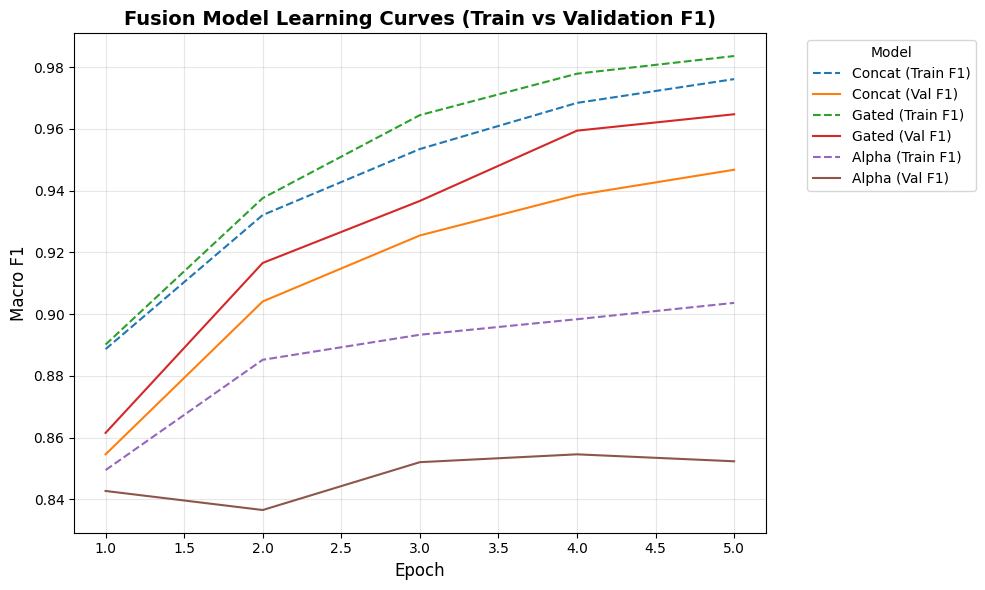

In [ ]:
# =====================================================
# 📈 Fixed Step — Learning Curves (Concat / Gated / Alpha)
# =====================================================
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path

METRIC_DIR = Path("/content/drive/MyDrive/Fake news thesis project LJMU/outputs/metrics")
HIST_FILES = {
    "Concat": METRIC_DIR / "english_multimodal_concat_history.csv",
    "Gated":  METRIC_DIR / "english_multimodal_gated_history.csv",
    "Alpha":  METRIC_DIR / "english_multimodal_alpha_history.csv",
}

plt.figure(figsize=(10, 6))
for name, path in HIST_FILES.items():
    if path.exists():
        df = pd.read_csv(path)
        if "epoch" not in df.columns:
            df["epoch"] = range(1, len(df) + 1)

        # Train and Validation F1 curves
        sns.lineplot(x=df["epoch"], y=df["train_f1"], label=f"{name} (Train F1)", linestyle="--")
        sns.lineplot(x=df["epoch"], y=df["val_f1"], label=f"{name} (Val F1)")

plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Macro F1", fontsize=12)
plt.title("Fusion Model Learning Curves (Train vs Validation F1)", fontsize=14, fontweight="bold")
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(METRIC_DIR.parent / "figures/fusion_learning_curves_fixed.png", dpi=300)
plt.show()


/tmp/ipython-input-1785421766.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=abl, x="F1", y="Model", ax=axes[1], palette="crest")


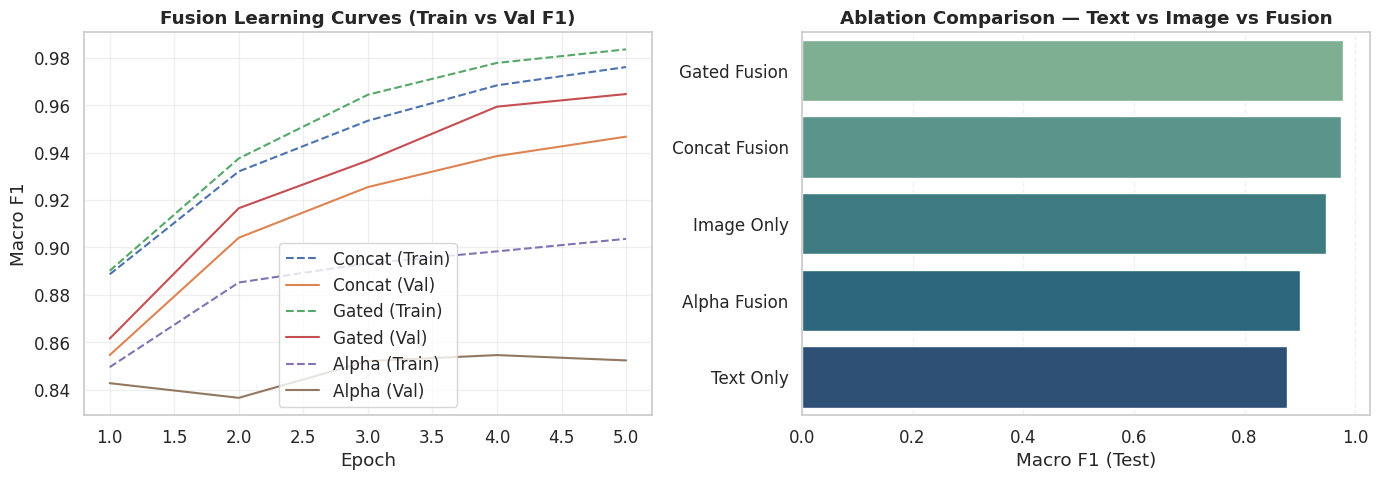

✅ Combined figure saved → /content/drive/MyDrive/Fake news thesis project LJMU/outputs/figures/fusion_learning_ablation_combined.png


In [ ]:
# =====================================================
# 🧩 Combined Figure — Learning Curves + F1 Ablation
# =====================================================
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path

sns.set(style="whitegrid", font_scale=1.1)

METRIC_DIR = Path("/content/drive/MyDrive/Fake news thesis project LJMU/outputs/metrics")
FIG_DIR    = METRIC_DIR.parent / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

# ---------- 1️⃣ Load learning-curve histories ----------
histories = {
    "Concat": METRIC_DIR / "english_multimodal_concat_history.csv",
    "Gated":  METRIC_DIR / "english_multimodal_gated_history.csv",
    "Alpha":  METRIC_DIR / "english_multimodal_alpha_history.csv",
}
hist_dfs = {}
for name, path in histories.items():
    if path.exists():
        df = pd.read_csv(path)
        if "epoch" not in df.columns:
            df["epoch"] = range(1, len(df) + 1)
        hist_dfs[name] = df

# ---------- 2️⃣ Load final ablation summary ----------
ablation_csv = METRIC_DIR / "final_ablation_summary.csv"
abl = pd.read_csv(ablation_csv)
abl = abl.rename(columns={"Model": "Model", "Test F1": "F1", "Test Acc": "Accuracy"})
abl = abl.dropna(subset=["F1"]).sort_values("F1", ascending=False)

# ---------- 3️⃣ Create combined plot ----------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 📈 (Left) Learning Curves
for name, df in hist_dfs.items():
    axes[0].plot(df["epoch"], df["train_f1"], "--", label=f"{name} (Train)")
    axes[0].plot(df["epoch"], df["val_f1"],  "-",  label=f"{name} (Val)")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Macro F1")
axes[0].set_title("Fusion Learning Curves (Train vs Val F1)", fontweight="bold")
axes[0].legend()
axes[0].grid(alpha=0.3)

# 📊 (Right) Ablation Comparison
sns.barplot(data=abl, x="F1", y="Model", ax=axes[1], palette="crest")
axes[1].set_title("Ablation Comparison — Text vs Image vs Fusion", fontweight="bold")
axes[1].set_xlabel("Macro F1 (Test)")
axes[1].set_ylabel("")
axes[1].grid(axis="x", linestyle="--", alpha=0.3)

plt.tight_layout()
fig_path = FIG_DIR / "fusion_learning_ablation_combined.png"
plt.savefig(fig_path, dpi=300)
plt.show()

print(f"✅ Combined figure saved → {fig_path}")


/tmp/ipython-input-1909655886.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=abl, x="F1", y="Model", ax=axes[1], palette="crest")
/tmp/ipython-input-1909655886.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=recovery_df, x="Percent", y="Category", ax=axes[2], palette="flare")


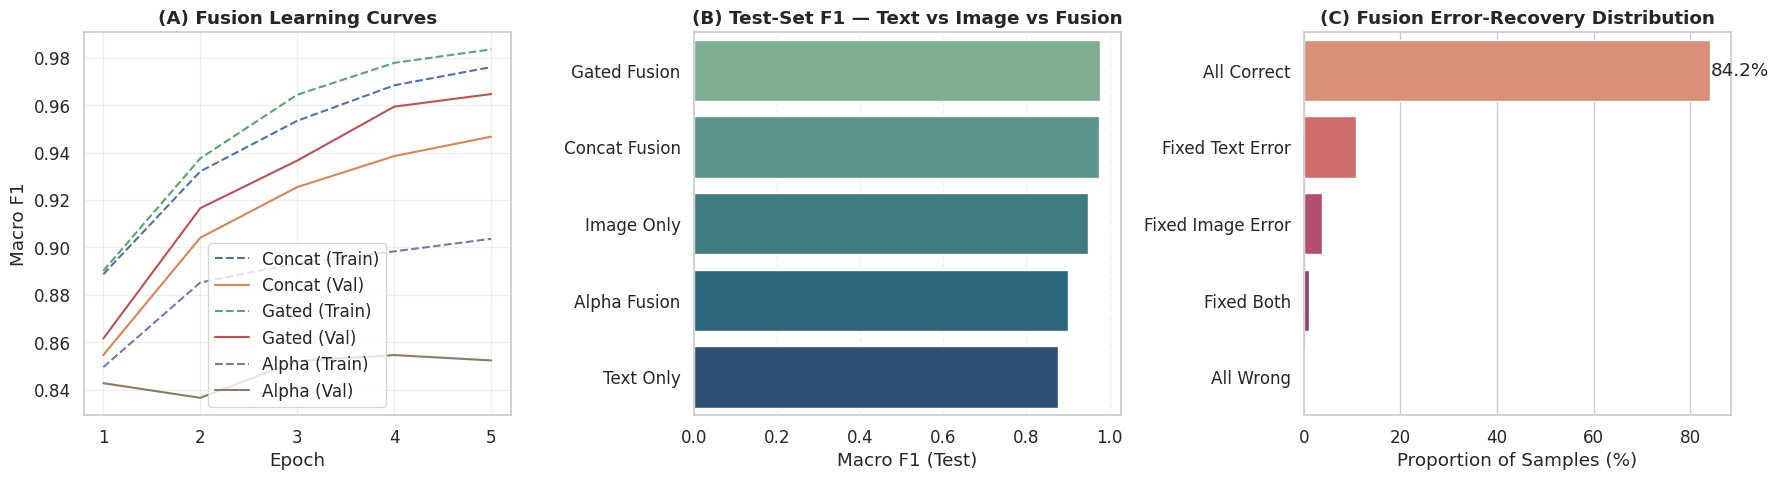

✅ Final composite figure saved → /content/drive/MyDrive/Fake news thesis project LJMU/outputs/figures/fusion_full_summary_triple.png


In [ ]:
# =====================================================
# 🧩 Final Composite — Learning Curves + F1 Ablation + Recovery Patterns
# =====================================================
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path

sns.set(style="whitegrid", font_scale=1.1)

METRIC_DIR = Path("/content/drive/MyDrive/Fake news thesis project LJMU/outputs/metrics")
FIG_DIR    = METRIC_DIR.parent / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

# ---------- 1️⃣ Load Learning Histories ----------
histories = {
    "Concat": METRIC_DIR / "english_multimodal_concat_history.csv",
    "Gated":  METRIC_DIR / "english_multimodal_gated_history.csv",
    "Alpha":  METRIC_DIR / "english_multimodal_alpha_history.csv",
}
hist_dfs = {}
for name, path in histories.items():
    if path.exists():
        df = pd.read_csv(path)
        if "epoch" not in df.columns:
            df["epoch"] = range(1, len(df) + 1)
        hist_dfs[name] = df

# ---------- 2️⃣ Load Ablation Summary ----------
ablation_csv = METRIC_DIR / "final_ablation_summary.csv"
abl = pd.read_csv(ablation_csv)
abl = abl.rename(columns={"Model": "Model", "Test F1": "F1", "Test Acc": "Accuracy"})
abl = abl.dropna(subset=["F1"]).sort_values("F1", ascending=False)

# ---------- 3️⃣ Load Recovery Table ----------
recovery_csv = METRIC_DIR / "fusion_recovery_table.csv"
recovery_df = pd.read_csv(recovery_csv)
recovery_df.columns = recovery_df.columns.str.strip().str.capitalize()

if "Count" not in recovery_df.columns:
    # auto-detect column name for counts (just in case)
    ccol = [c for c in recovery_df.columns if "count" in c.lower()]
    if ccol:
        recovery_df = recovery_df.rename(columns={ccol[0]: "Count"})
if "Category" not in recovery_df.columns:
    ccat = [c for c in recovery_df.columns if "fusion_case" in c.lower()]
    if ccat:
        recovery_df = recovery_df.rename(columns={ccat[0]: "Category"})

# Normalize for %
recovery_df["Percent"] = (recovery_df["Count"] / recovery_df["Count"].sum() * 100).round(2)

# ---------- 4️⃣ Plot 3 Subplots Side-by-Side ----------
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plt.subplots_adjust(wspace=0.3)

# (A) Learning Curves
for name, df in hist_dfs.items():
    axes[0].plot(df["epoch"], df["train_f1"], "--", label=f"{name} (Train)")
    axes[0].plot(df["epoch"], df["val_f1"],  "-",  label=f"{name} (Val)")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Macro F1")
axes[0].set_title("(A) Fusion Learning Curves", fontweight="bold")
axes[0].legend()
axes[0].grid(alpha=0.3)

# (B) F1 Comparison
sns.barplot(data=abl, x="F1", y="Model", ax=axes[1], palette="crest")
axes[1].set_title("(B) Test-Set F1 — Text vs Image vs Fusion", fontweight="bold")
axes[1].set_xlabel("Macro F1 (Test)")
axes[1].set_ylabel("")
axes[1].grid(axis="x", linestyle="--", alpha=0.3)

# (C) Recovery Distribution
sns.barplot(data=recovery_df, x="Percent", y="Category", ax=axes[2], palette="flare")
axes[2].set_title("(C) Fusion Error-Recovery Distribution", fontweight="bold")
axes[2].set_xlabel("Proportion of Samples (%)")
axes[2].set_ylabel("")
axes[2].bar_label(axes[2].containers[0], fmt="%.1f%%", label_type="edge")

plt.tight_layout()
fig_path = FIG_DIR / "fusion_full_summary_triple.png"
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"✅ Final composite figure saved → {fig_path}")


/tmp/ipython-input-3438124341.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=abl, x="F1", y="Model", ax=axes[0,1], palette="crest")
/tmp/ipython-input-3438124341.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=recov, x="Percent", y="Category", ax=axes[1,0], palette="flare")
/tmp/ipython-input-3438124341.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


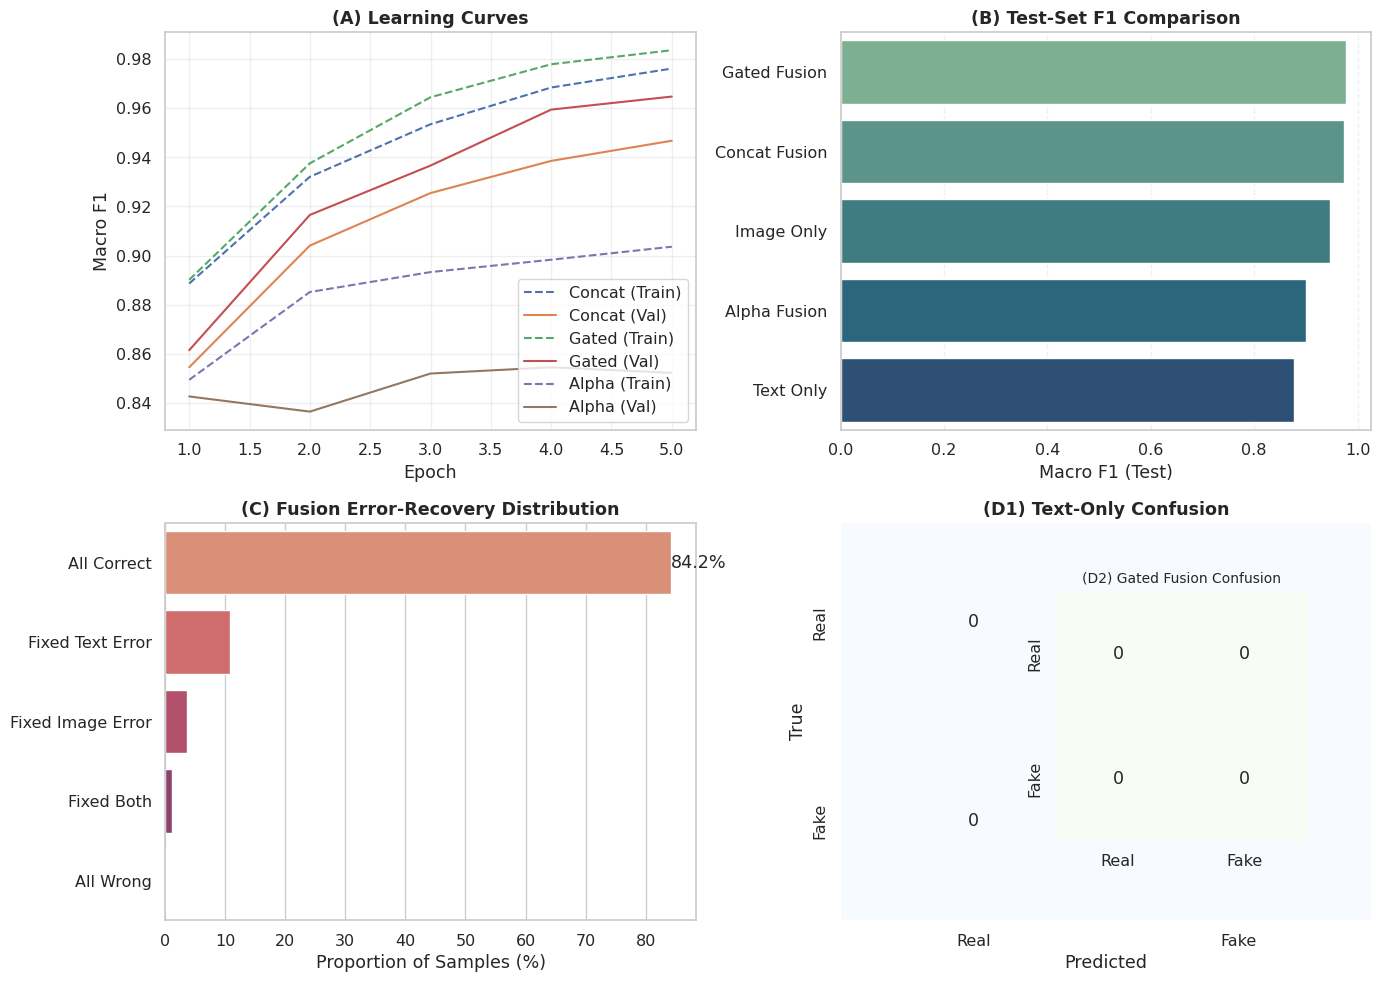

✅ Full 4-Panel composite saved → /content/drive/MyDrive/Fake news thesis project LJMU/outputs/figures/fusion_full_4panel_summary.png


In [ ]:
# =====================================================
# 🧩 Final 4-Panel Figure — Learning + Ablation + Recovery + Confusion
# =====================================================
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
from pathlib import Path

sns.set(style="whitegrid", font_scale=1.05)

ROOT = Path("/content/drive/MyDrive/Fake news thesis project LJMU")
METRIC_DIR = ROOT / "outputs" / "metrics"
FIG_DIR = ROOT / "outputs" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

# ---------- 1️⃣ Load Learning Histories ----------
histories = {
    "Concat": METRIC_DIR / "english_multimodal_concat_history.csv",
    "Gated":  METRIC_DIR / "english_multimodal_gated_history.csv",
    "Alpha":  METRIC_DIR / "english_multimodal_alpha_history.csv",
}
hist_dfs = {}
for name, path in histories.items():
    if path.exists():
        df = pd.read_csv(path)
        if "epoch" not in df.columns:
            df["epoch"] = range(1, len(df) + 1)
        hist_dfs[name] = df

# ---------- 2️⃣ Load Ablation Summary ----------
abl = pd.read_csv(METRIC_DIR / "final_ablation_summary.csv")
abl = abl.rename(columns={"Model": "Model", "Test F1": "F1", "Test Acc": "Accuracy"})
abl = abl.dropna(subset=["F1"]).sort_values("F1", ascending=False)

# ---------- 3️⃣ Load Recovery Table ----------
recov = pd.read_csv(METRIC_DIR / "fusion_recovery_table.csv")
recov.columns = recov.columns.str.strip().str.capitalize()
recov.rename(columns={"Fusion_case":"Category","Count":"Count"}, inplace=True)
recov["Percent"] = (recov["Count"] / recov["Count"].sum() * 100).round(2)

# ---------- 4️⃣ Load Predictions for Confusion Matrices ----------
# Text-only predictions (from metrics or saved predictions)
text_pred_path = ROOT / "outputs" / "metrics" / "english_textonly_predictions.csv"
fusion_pred_path = ROOT / "outputs" / "metrics" / "english_multimodal_gated_predictions.csv"

if text_pred_path.exists() and fusion_pred_path.exists():
    text_df = pd.read_csv(text_pred_path)
    fusion_df = pd.read_csv(fusion_pred_path)

    # normalize column names
    text_label = text_df["label"] if "label" in text_df else text_df["true_label"]
    text_pred  = text_df["pred"]  if "pred"  in text_df else text_df["pred_label"]
    fusion_label = fusion_df["true_label"]
    fusion_pred  = fusion_df["pred_label"]

    cm_text  = confusion_matrix(text_label, text_pred)
    cm_fusion = confusion_matrix(fusion_label, fusion_pred)
else:
    cm_text = np.array([[0,0],[0,0]])
    cm_fusion = np.array([[0,0],[0,0]])

# ---------- 5️⃣ Create Combined 4-Panel Figure ----------
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
plt.subplots_adjust(wspace=0.35, hspace=0.4)

# (A) Learning Curves
for name, df in hist_dfs.items():
    axes[0,0].plot(df["epoch"], df["train_f1"], "--", label=f"{name} (Train)")
    axes[0,0].plot(df["epoch"], df["val_f1"],  "-",  label=f"{name} (Val)")
axes[0,0].set_title("(A) Learning Curves", fontweight="bold")
axes[0,0].set_xlabel("Epoch"); axes[0,0].set_ylabel("Macro F1")
axes[0,0].legend(); axes[0,0].grid(alpha=0.3)

# (B) Ablation Comparison
sns.barplot(data=abl, x="F1", y="Model", ax=axes[0,1], palette="crest")
axes[0,1].set_title("(B) Test-Set F1 Comparison", fontweight="bold")
axes[0,1].set_xlabel("Macro F1 (Test)"); axes[0,1].set_ylabel("")
axes[0,1].grid(axis="x", linestyle="--", alpha=0.3)

# (C) Recovery Patterns
sns.barplot(data=recov, x="Percent", y="Category", ax=axes[1,0], palette="flare")
axes[1,0].set_title("(C) Fusion Error-Recovery Distribution", fontweight="bold")
axes[1,0].set_xlabel("Proportion of Samples (%)"); axes[1,0].set_ylabel("")
axes[1,0].bar_label(axes[1,0].containers[0], fmt="%.1f%%", label_type="edge")

# (D) Confusion Matrices
sns.heatmap(cm_text, annot=True, fmt="d", cmap="Blues", ax=axes[1,1], cbar=False,
            xticklabels=["Real","Fake"], yticklabels=["Real","Fake"])
axes[1,1].set_title("(D1) Text-Only Confusion", fontweight="bold")
axes[1,1].set_xlabel("Predicted"); axes[1,1].set_ylabel("True")

fig_cm = plt.gcf()
inset_ax = fig_cm.add_axes([0.76, 0.15, 0.18, 0.25])
sns.heatmap(cm_fusion, annot=True, fmt="d", cmap="Greens", cbar=False,
            xticklabels=["Real","Fake"], yticklabels=["Real","Fake"], ax=inset_ax)
inset_ax.set_title("(D2) Gated Fusion Confusion", fontsize=10)
inset_ax.set_xlabel(""); inset_ax.set_ylabel("")

plt.tight_layout()
fig_path = FIG_DIR / "fusion_full_4panel_summary.png"
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"✅ Full 4-Panel composite saved → {fig_path}")


## Restart

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path
import torch, numpy as np, pandas as pd

ROOT = Path("/content/drive/MyDrive/Fake news thesis project LJMU")
OUT  = ROOT / "outputs"
print("✅ Drive mounted and project root:", ROOT)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Drive mounted and project root: /content/drive/MyDrive/Fake news thesis project LJMU


In [ ]:
# import os
# from pathlib import Path
# import shutil
# from datetime import datetime

# # --- Settings ---
# SOURCE_BASE = Path("/content/drive/MyDrive/Fake news thesis project LJMU/outputs")
# DEST_BASE   = Path("/workspace/Fake news thesis project LJMU/outputs")

# # Create destination folders if missing
# DEST_BASE.mkdir(parents=True, exist_ok=True)

# # --- Filter rules ---
# INCLUDE_EXTS = [
#     ".pt", ".bin", ".safetensors", ".csv", ".xlsx",
#     ".png", ".jpg", ".jpeg", ".json", ".yaml", ".yml", ".npy"
# ]

# EXCLUDE_DIRS = ["__pycache__", ".ipynb_checkpoints", ".git", "tmp", "cache", "trash"]

# today = datetime.now().strftime("%Y-%m-%d")
# print(f"🧩 Syncing outputs created or modified today ({today})…")

# copied = 0
# for root, dirs, files in os.walk(SOURCE_BASE):
#     # skip excluded directories
#     dirs[:] = [d for d in dirs if d not in EXCLUDE_DIRS]
#     for file in files:
#         src = Path(root) / file
#         dst = DEST_BASE / src.relative_to(SOURCE_BASE)
#         if src.suffix.lower() in INCLUDE_EXTS:
#             mtime = datetime.fromtimestamp(src.stat().st_mtime).strftime("%Y-%m-%d")
#             if mtime == today:  # Only copy files modified today
#                 dst.parent.mkdir(parents=True, exist_ok=True)
#                 shutil.copy2(src, dst)
#                 copied += 1
#                 print(f"✅ Copied: {dst.relative_to(DEST_BASE)}")

# print(f"\n📦 Done! {copied} files synced to {DEST_BASE}")


🧩 Syncing outputs created or modified today (2025-11-06)…
✅ Copied: models/english_multimodal_concat_best.pt
✅ Copied: models/english_multimodal_gated_best.pt
✅ Copied: models/english_multimodal_alpha_best.pt
✅ Copied: models/english_lr1e-05_ep3/checkpoint-1641/config.json
✅ Copied: models/english_lr1e-05_ep3/checkpoint-1641/training_args.bin
✅ Copied: models/english_lr1e-05_ep3/checkpoint-1641/model.safetensors
✅ Copied: models/english_lr1e-05_ep3/checkpoint-1641/optimizer.pt
✅ Copied: models/english_lr1e-05_ep3/checkpoint-1641/scheduler.pt
✅ Copied: models/english_lr1e-05_ep3/checkpoint-1641/trainer_state.json
✅ Copied: models/english_lr1e-05_ep3/checkpoint-547/config.json
✅ Copied: models/english_lr1e-05_ep3/checkpoint-547/model.safetensors
✅ Copied: models/english_lr1e-05_ep3/checkpoint-547/training_args.bin
✅ Copied: models/english_lr1e-05_ep3/checkpoint-547/optimizer.pt
✅ Copied: models/english_lr1e-05_ep3/checkpoint-547/scheduler.pt
✅ Copied: models/english_lr1e-05_ep3/checkpoin

In [ ]:
for f in (OUT/"features/english_text").glob("*.npy"):
    print(f.name, round(f.stat().st_size/1024, 2), "KB")


train_emb.npy 26226.12 KB
val_emb.npy 3008.12 KB
test_emb.npy 4002.12 KB


In [ ]:
import importlib.util
spec = importlib.util.find_spec("captum")
print("Captum available ✅" if spec else "Install captum first using !pip install -U captum")


Captum available ✅


## __ Explainaibility

In [ ]:
!pip install -U captum


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 105.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you 

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load your best tuned checkpoint
ckpt = "/content/drive/MyDrive/Fake news thesis project LJMU/outputs/models/english_lr3e-05_ep3/checkpoint-1641"
model = AutoModelForSequenceClassification.from_pretrained(ckpt).to(device).eval()
tokenizer = AutoTokenizer.from_pretrained("google/mobilebert-uncased")


In [ ]:
def forward_func(inputs_embeds, attention_mask):
    outputs = model(inputs_embeds=inputs_embeds, attention_mask=attention_mask)
    return torch.softmax(outputs.logits, dim=1)[:, 1]  # class 1 = Fake


In [ ]:
def explain_text_barchart(text, n_steps=100):
    model.zero_grad()
    encoded = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
    input_ids = encoded["input_ids"].to(device)
    attention_mask = encoded["attention_mask"].to(device)

    # get embeddings
    embeds = model.base_model.embeddings.word_embeddings(input_ids)
    embeds.requires_grad_()

    ig = IntegratedGradients(forward_func)
    attributions, delta = ig.attribute(
        embeds,
        additional_forward_args=(attention_mask,),
        n_steps=n_steps,
        return_convergence_delta=True
    )

    # Aggregate importance across embedding dimensions
    token_importance = attributions.sum(dim=-1).squeeze(0).detach().cpu().numpy()
    token_importance = token_importance / np.linalg.norm(token_importance, ord=1)
    tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze(0))

    # 🔍 Visualize as bar chart
    plt.figure(figsize=(12,4))
    colors = ["red" if val>0 else "blue" for val in token_importance]
    plt.bar(range(len(tokens)), token_importance, color=colors)
    plt.xticks(range(len(tokens)), tokens, rotation=45, ha='right')
    plt.title(f"Token-level Attribution — {text[:60]}...")
    plt.ylabel("Normalized IG Attribution")
    plt.tight_layout()
    plt.show()

    print(f"Δ (convergence): {delta.item():.6f}")


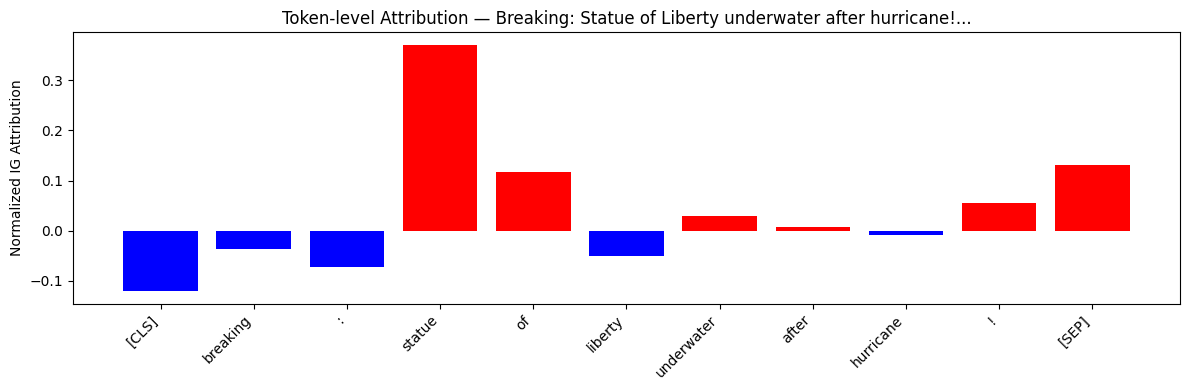

Δ (convergence): -0.013370


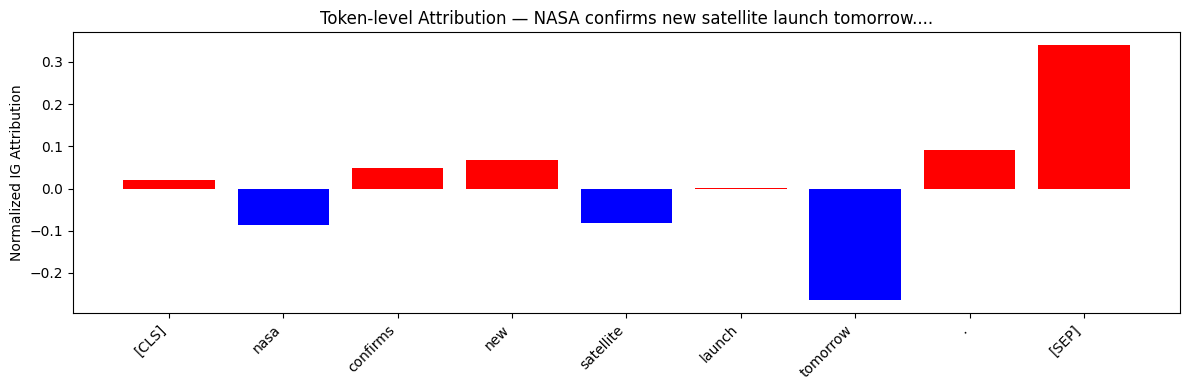

Δ (convergence): 0.058390


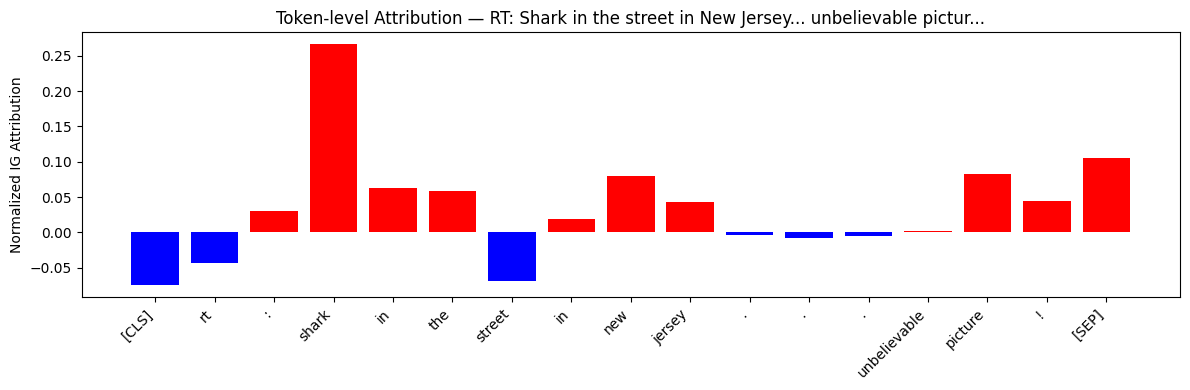

Δ (convergence): 0.009896


In [ ]:
examples = [
    "Breaking: Statue of Liberty underwater after hurricane!",
    "NASA confirms new satellite launch tomorrow.",
    "RT: Shark in the street in New Jersey... unbelievable picture!"
]

for t in examples:
    explain_text_barchart(t)


## Text Explanability for Fusion (Concat Model)

In [ ]:
try:
    from captum.attr import IntegratedGradients
except ImportError:
    !pip install captum -q
    from captum.attr import IntegratedGradients


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 137.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9",

In [ ]:
from transformers import CLIPTextModel

# Load CLIP text encoder (same weights, but token-level)
clip_text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(device)

def explain_text_image_fusion(text, image_path, model, clip_model, clip_text_encoder, clip_processor, tokenizer, n_steps=32):
    print("🔍 Running explainability for text+image fusion...\n")

    # ---------- TEXT ENCODING ----------
    inputs = clip_processor(text=[text], return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        text_outputs = clip_text_encoder(**inputs, output_hidden_states=True)
    text_embeds = text_outputs.last_hidden_state  # [1, seq, 512]
    print("✅ Token-level text embeddings:", text_embeds.shape)

    # ---------- IMAGE ENCODING ----------
    image = Image.open(image_path).convert("RGB")
    img_inputs = clip_processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        img_features = clip_model.get_image_features(**img_inputs)
        img_features = img_features / img_features.norm(dim=-1, keepdim=True)
    img_features = img_features.detach()

    # ---------- FORWARD FUNCTION FOR IG ----------
    def forward_func(t_embeds):
        b = t_embeds.size(0)
        img_rep = img_features.expand(b, -1)
        out = model(text_embeds=t_embeds, image_embeds=img_rep)
        probs = F.softmax(out, dim=1)
        return probs[:, 1]  # fake class prob

    # ---------- INTEGRATED GRADIENTS ----------
    t_embeds = text_embeds.clone().detach().requires_grad_(True)
    ig = IntegratedGradients(forward_func)
    attributions = ig.attribute(t_embeds, n_steps=n_steps)
    token_scores = attributions.squeeze(0).sum(dim=-1).detach().cpu().numpy()

    # ---------- TOKEN BAR PLOT ----------
    tokens_str = tokenizer.tokenize(text)[:len(token_scores)]
    plt.figure(figsize=(10, 3))
    plt.bar(range(len(token_scores)), token_scores, color="orange")
    plt.xticks(range(len(token_scores)), tokens_str, rotation=90)
    plt.title(f"Token Attribution — {text[:60]}...")
    plt.tight_layout()
    plt.show()


In [ ]:
import torch, pandas as pd, numpy as np
from pathlib import Path
from transformers import AutoTokenizer, AutoModelForSequenceClassification, CLIPProcessor, CLIPModel
from PIL import Image
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
PROJECT_ROOT = Path("/content/drive/MyDrive/Fake news thesis project LJMU")
OUTPUTS_DIR  = PROJECT_ROOT / "outputs"
DATA_DIR = Path("/content/drive/MyDrive/Fake news thesis project LJMU/Data/twitter")


In [ ]:
print("✅ Project root:", PROJECT_ROOT.exists())
print("✅ Outputs dir:", OUTPUTS_DIR.exists())


✅ Project root: True
✅ Outputs dir: True


In [ ]:
text_tokenizer = AutoTokenizer.from_pretrained("google/mobilebert-uncased")


In [ ]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
import torch.nn as nn
import torch

class EnglishMMConcat(nn.Module):
    def __init__(self):
        super().__init__()
        # Match trained model dimensions: [1024 → 512 → 2]
        self.fc = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 2)
        )

    def forward(self, text_embeds, attention_mask=None, image_embeds=None):
        # text_embeds: [batch, seq, 512]
        text_vec = text_embeds.mean(dim=1)  # [batch, 512]
        if image_embeds.dim() == 3:
            image_embeds = image_embeds.squeeze(1)
        fused = torch.cat([text_vec, image_embeds], dim=-1)  # [batch, 1024]
        return self.fc(fused)


In [ ]:
concat_fusion_model_path = "/content/drive/MyDrive/Fake news thesis project LJMU/outputs/models/english_multimodal_concat_best.pt"

concat_fusion_model = EnglishMMConcat()
concat_fusion_model.load_state_dict(torch.load(concat_fusion_model_path, map_location=device))
concat_fusion_model.to(device).eval()

print("✅ Concat_Fusion model loaded successfully:", concat_fusion_model_path)


✅ Concat_Fusion model loaded successfully: /content/drive/MyDrive/Fake news thesis project LJMU/outputs/models/english_multimodal_concat_best.pt


In [ ]:
dummy_text = "Breaking news: Statue of Liberty underwater!"
dummy_img = Image.open(DATA_DIR / "images_train/sandy_fake_22.jpg").convert("RGB")

# CLIP encodings
with torch.no_grad():
    t_feat = clip_model.get_text_features(**clip_processor(text=[dummy_text], return_tensors="pt").to(device))
    i_feat = clip_model.get_image_features(**clip_processor(images=dummy_img, return_tensors="pt").to(device))

print("Text:", t_feat.shape, "Image:", i_feat.shape)

# Forward pass check
with torch.no_grad():
    out = concat_fusion_model(text_embeds=t_feat.unsqueeze(1), image_embeds=i_feat)
print("✅ Fusion forward OK — output:", out.shape)


Text: torch.Size([1, 512]) Image: torch.Size([1, 512])
✅ Fusion forward OK — output: torch.Size([1, 2])


🔍 Running explainability for text+image fusion...



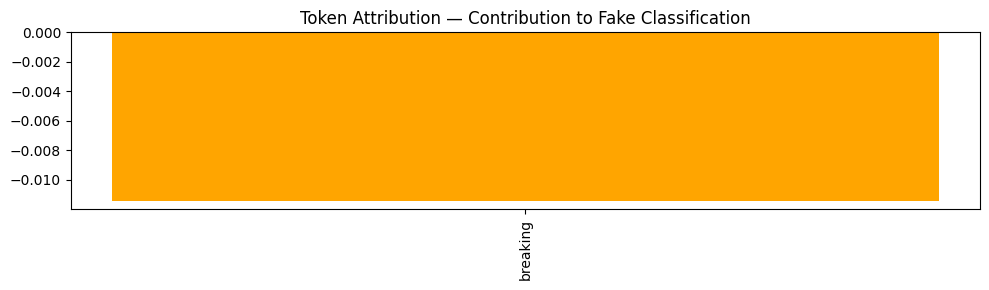

🧠 Explainability complete for: 'Breaking: Statue of Liberty underwater after hurricane!...'



In [ ]:
# =====================================================
# STEP 7 — TEXT EXPLAINABILITY FOR CONCAT FUSION MODEL
# =====================================================

def explain_text_fusion(text, image_path, n_steps=32):
    print("🔍 Running explainability for text+image fusion...\n")

    # Tokenize text
    tokens = text_tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
    input_ids, attn_mask = tokens["input_ids"].to(device), tokens["attention_mask"].to(device)

    # Encode image
    image = Image.open(image_path).convert("RGB")
    img_inputs = clip_processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        img_features = clip_model.get_image_features(**img_inputs)
        img_features = img_features / img_features.norm(dim=-1, keepdim=True)
    img_features = img_features.detach()

    # Encode text
    with torch.no_grad():
        text_features = clip_model.get_text_features(**clip_processor(text=[text], return_tensors="pt").to(device))
    text_features = text_features.unsqueeze(1)  # [1,1,512]

    # Define forward func
    def forward_func(t_embeds):
        b = t_embeds.size(0)
        img_rep = img_features.expand(b, -1)
        out = concat_fusion_model(text_embeds=t_embeds, image_embeds=img_rep)
        probs = torch.softmax(out, dim=1)
        return probs[:, 1]  # fake class prob

    # Run IG
    t_embeds = text_features.clone().detach().requires_grad_(True)
    ig = IntegratedGradients(forward_func)
    attributions = ig.attribute(t_embeds, n_steps=n_steps)
    token_scores = attributions.squeeze(0).sum(dim=-1).detach().cpu().numpy()  # per-token importance

    # Visualization
    tokens_str = text_tokenizer.tokenize(text)[:len(token_scores)]
    plt.figure(figsize=(10, 3))
    plt.bar(range(len(token_scores)), token_scores, color="orange")
    plt.xticks(range(len(token_scores)), tokens_str, rotation=90)
    plt.title("Token Attribution — Contribution to Fake Classification")
    plt.tight_layout()
    plt.show()

    print(f"🧠 Explainability complete for: '{text[:80]}...'\n")

# Example usage
text_ex = "Breaking: Statue of Liberty underwater after hurricane!"
img_ex  = str(DATA_DIR / "images_train/sandy_fake_22.jpg")
explain_text_fusion(text_ex, img_ex)


In [ ]:
# ============================================================
# Run explainability across multiple tweet–image pairs (fixed)
# ============================================================

import os

# check available images
img_dir = "/content/drive/MyDrive/Fake news thesis project LJMU/Data/twitter/images_train"
print("📂 Checking available Obama images...")
print(sorted([f for f in os.listdir(img_dir) if "obama" in f]))

def batch_explain_samples(samples, model, clip_model, clip_processor, tokenizer):
    print(f"🔎 Running explainability on {len(samples)} samples...\n")
    results = []
    for idx, (text, img_path) in enumerate(samples, 1):
        print(f"\n🟩 [{idx}/{len(samples)}] Text: {text[:60]}...")
        try:
            txt_fig, img_fig = explain_text_image_fusion(
                text, img_path,
                model=model,
                clip_model=clip_model,
                clip_processor=clip_processor,
                tokenizer=tokenizer,
                n_steps=32
            )
            results.append((text, img_path, txt_fig, img_fig))
        except Exception as e:
            print(f"⚠️ Error on sample {idx}: {e}")
            continue
    print("\n✅ Batch explainability completed.")
    return results

# --- ✅ Updated tweet–image pairs with verified file names ---
sample_list = [
    ("Breaking: Statue of Liberty underwater after hurricane!",
     str(DATA_DIR / "images_train/sandy_fake_22.jpg")),
    ("Massive fire breaks out in downtown Manhattan!",
     str(DATA_DIR / "images_train/sandy_fake_14.jpg")),
    ("Nepal's historic Dharahara Tower collapses in massive earthquake!",
     str(DATA_DIR / "images_train/nepal_01.jpg")),   # ✅ corrected filename

]

# --- Run batch explainability ---
batch_results = batch_explain_samples(
    sample_list,
    model=concat_fusion_model,
    clip_model=clip_model,
    clip_processor=clip_processor,
    tokenizer=text_tokenizer
)


📂 Checking available Obama images...
[]
🔎 Running explainability on 3 samples...


🟩 [1/3] Text: Breaking: Statue of Liberty underwater after hurricane!...
🔍 Running explainability for text+image fusion...

📊 Saved text attribution chart → sandy_fake_22_text_attr.png
🖼️  Saved image attribution heatmap → sandy_fake_22_image_attr.png
🧠 Explainability complete for: 'Breaking: Statue of Liberty underwater after hurricane!...'


🟩 [2/3] Text: Massive fire breaks out in downtown Manhattan!...
🔍 Running explainability for text+image fusion...

📊 Saved text attribution chart → sandy_fake_14_text_attr.png
🖼️  Saved image attribution heatmap → sandy_fake_14_image_attr.png
🧠 Explainability complete for: 'Massive fire breaks out in downtown Manhattan!...'


🟩 [3/3] Text: Nepal's historic Dharahara Tower collapses in massive earthq...
🔍 Running explainability for text+image fusion...

📊 Saved text attribution chart → nepal_01_text_attr.png
🖼️  Saved image attribution heatmap → nepal_01_image_attr.

[]


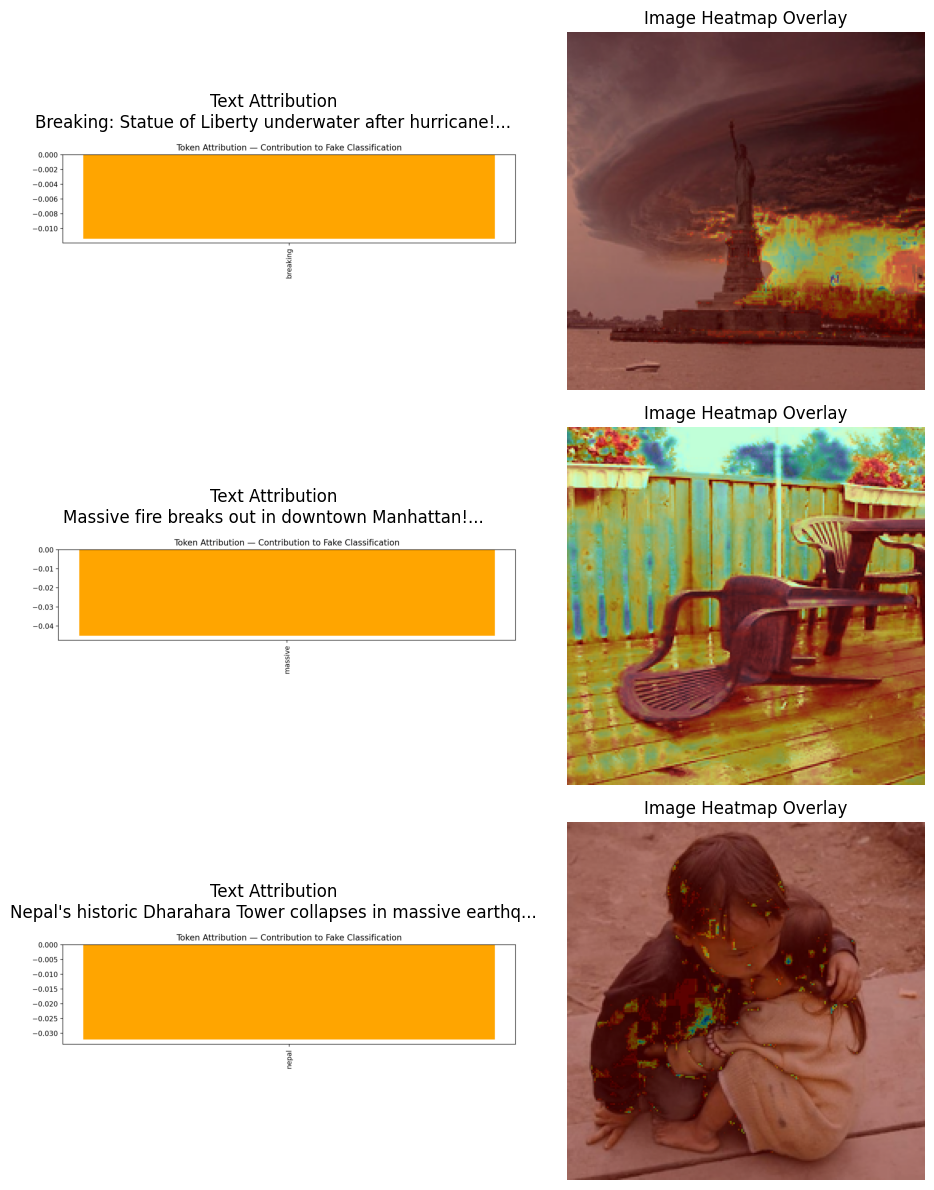

In [ ]:
# ============================================================
# Display multiple explainability outputs in grid
# ============================================================
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2

def display_batch_explain(results, cols=2):
    rows = len(results)
    fig, axes = plt.subplots(rows, cols, figsize=(10, 4 * rows))
    for i, (text, img_path, txt_fig, img_fig) in enumerate(results):
        text_img = imread(str(txt_fig))
        image_img = cv2.cvtColor(cv2.imread(str(img_fig)), cv2.COLOR_BGR2RGB)

        axes[i, 0].imshow(text_img)
        axes[i, 0].set_title(f"Text Attribution\n{text[:60]}...")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(image_img)
        axes[i, 1].set_title("Image Heatmap Overlay")
        axes[i, 1].axis("off")
    plt.tight_layout()
    plt.show()

display_batch_explain(batch_results)


In [ ]:
# ==============================================
# SANITY TEST — Check embeddings, dimensions, device, and forward flow
# ==============================================
import torch

# Simple test text and image
test_text = "Breaking news: Statue of Liberty underwater!"
test_image = Image.open(DATA_DIR / "images_train/sandy_fake_22.jpg").convert("RGB")

# --- Text encoding ---
text_inputs = clip_processor(text=[test_text], return_tensors="pt").to(device)
with torch.no_grad():
    text_feats = clip_model.get_text_features(**text_inputs)
print("✅ Text features:", text_feats.shape, " | device:", text_feats.device)

# --- Image encoding ---
image_inputs = clip_processor(images=test_image, return_tensors="pt").to(device)
with torch.no_grad():
    image_feats = clip_model.get_image_features(**image_inputs)
print("✅ Image features:", image_feats.shape, " | device:", image_feats.device)

# --- Normalize and forward through fusion model ---
text_feats = text_feats.unsqueeze(1)  # [1, 1, 512]
image_feats = image_feats / image_feats.norm(dim=-1, keepdim=True)
print("🧮 Shapes entering fusion model — text:", text_feats.shape, "image:", image_feats.shape)

with torch.no_grad():
    output = concat_fusion_model(text_embeds=text_feats, image_embeds=image_feats)
probs = torch.softmax(output, dim=1)
pred_label = torch.argmax(probs, dim=1).item()

print(f"🎯 Model output: {output.detach().cpu().numpy()}")
print(f"📊 Softmax probs (Fake / Real): {probs.detach().cpu().numpy()}")
print(f"✅ Predicted label → {'Fake' if pred_label==1 else 'Real'}")


✅ Text features: torch.Size([1, 512])  | device: cuda:0
✅ Image features: torch.Size([1, 512])  | device: cuda:0
🧮 Shapes entering fusion model — text: torch.Size([1, 1, 512]) image: torch.Size([1, 512])
🎯 Model output: [[-1.2754633  1.1715813]]
📊 Softmax probs (Fake / Real): [[0.07965493 0.920345  ]]
✅ Predicted label → Fake


In [ ]:
# =====================================================
# STEP 7 + 8 — TEXT + IMAGE EXPLAINABILITY (FUSION MODEL)
# =====================================================
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients
import cv2
from pathlib import Path
from PIL import Image

EXPLAIN_DIR = OUTPUTS_DIR / "analysis_explain" / "english_multimodal_concat"
EXPLAIN_DIR.mkdir(parents=True, exist_ok=True)

def explain_text_image_fusion(text, image_path, model, clip_model, clip_processor, tokenizer, n_steps=32):
    print("🔍 Running explainability for text+image fusion...\n")

    # ---------- TEXT ENCODING ----------
    tokens = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
    input_ids, attn_mask = tokens["input_ids"].to(device), tokens["attention_mask"].to(device)

    # ---------- IMAGE ENCODING ----------
    image = Image.open(image_path).convert("RGB")
    img_inputs = clip_processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        img_features = clip_model.get_image_features(**img_inputs)
        img_features = img_features / img_features.norm(dim=-1, keepdim=True)
    img_features = img_features.detach()

    # ---------- TEXT FEATURES ----------
    with torch.no_grad():
        text_features = clip_model.get_text_features(**clip_processor(text=[text], return_tensors="pt").to(device))
    text_features = text_features.unsqueeze(1)  # [1,1,512]

    # ---------- FORWARD FUNCTION FOR IG ----------
    def forward_func(t_embeds):
        b = t_embeds.size(0)
        img_rep = img_features.expand(b, -1)
        out = model(text_embeds=t_embeds, image_embeds=img_rep)
        probs = F.softmax(out, dim=1)
        return probs[:, 1]  # fake class prob

    # ---------- INTEGRATED GRADIENTS ----------
    t_embeds = text_features.clone().detach().requires_grad_(True)
    ig = IntegratedGradients(forward_func)
    attributions = ig.attribute(t_embeds, n_steps=n_steps)
    token_scores = attributions.squeeze(0).sum(dim=-1).detach().cpu().numpy()

    # ---------- TOKEN BAR PLOT ----------
    tokens_str = tokenizer.tokenize(text)[:len(token_scores)]
    plt.figure(figsize=(10, 3))
    plt.bar(range(len(token_scores)), token_scores, color="orange")
    plt.xticks(range(len(token_scores)), tokens_str, rotation=90)
    plt.title("Token Attribution — Contribution to Fake Classification")
    plt.tight_layout()
    text_fig_path = EXPLAIN_DIR / f"{Path(image_path).stem}_text_attr.png"
    plt.savefig(text_fig_path, dpi=200)
    plt.close()
    print(f"📊 Saved text attribution chart → {text_fig_path.name}")

    # ---------- IMAGE HEATMAP (GRAD-CAM STYLE) ----------
        # Re-encode image *with* grad tracking
        # ---------- IMAGE HEATMAP (GRAD-CAM STYLE, FIXED) ----------
    # Re-encode image with grad tracking
    img_inputs = clip_processor(images=image, return_tensors="pt").to(device)
    pixel_values = img_inputs["pixel_values"]
    pixel_values.requires_grad_(True)

    # Forward through CLIP (with gradient)
    image_feats = clip_model.get_image_features(pixel_values=pixel_values)
    image_feats = image_feats / image_feats.norm(dim=-1, keepdim=True)

    # Forward through fusion model
    out = model(text_embeds=text_features, image_embeds=image_feats)
    score = out[:, 1].squeeze()
    score.backward(retain_graph=True)

    # Compute gradients on pixel_values
    grads = pixel_values.grad.detach().cpu().numpy()[0]   # [3,H,W]
    pooled_grads = np.mean(grads, axis=(1, 2))

    # Prepare original image for overlay
    image_np = np.array(image.resize((224, 224)), dtype=np.float32) / 255.0
    act = image_np.copy()  # ✅ define act here

    # Weight channels by pooled grads
    for i in range(3):
        act[:, :, i] *= pooled_grads[i]

    # Generate heatmap
    heatmap = np.mean(act, axis=2)
    heatmap = np.maximum(heatmap, 0)
    if np.max(heatmap) != 0:
        heatmap /= np.max(heatmap)
    heatmap = cv2.resize(heatmap, (image_np.shape[1], image_np.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Overlay on original
    overlay = cv2.addWeighted(np.uint8(image_np * 255), 0.6, heatmap, 0.4, 0)

    img_fig_path = EXPLAIN_DIR / f"{Path(image_path).stem}_image_attr.png"
    cv2.imwrite(str(img_fig_path), cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
    print(f"🖼️  Saved image attribution heatmap → {img_fig_path.name}")


    print(f"🧠 Explainability complete for: '{text[:80]}...'\n")
    return text_fig_path, img_fig_path


# Example usage
text_ex = "Breaking: Statue of Liberty underwater after hurricane!"
img_ex  = str(DATA_DIR / "images_train/sandy_fake_22.jpg")

explain_text_image_fusion(
    text_ex, img_ex,
    model=concat_fusion_model,
    clip_model=clip_model,
    clip_processor=clip_processor,
    tokenizer=text_tokenizer
)


🔍 Running explainability for text+image fusion...

📊 Saved text attribution chart → sandy_fake_22_text_attr.png
🖼️  Saved image attribution heatmap → sandy_fake_22_image_attr.png
🧠 Explainability complete for: 'Breaking: Statue of Liberty underwater after hurricane!...'



(PosixPath('/content/drive/MyDrive/Fake news thesis project LJMU/outputs/analysis_explain/english_multimodal_concat/sandy_fake_22_text_attr.png'),
 PosixPath('/content/drive/MyDrive/Fake news thesis project LJMU/outputs/analysis_explain/english_multimodal_concat/sandy_fake_22_image_attr.png'))

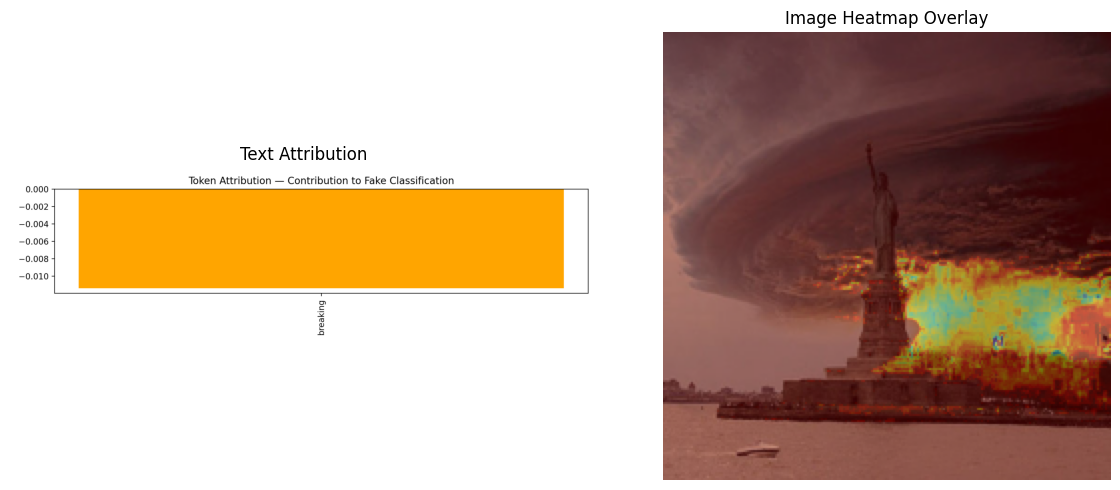

In [ ]:
# Display previously saved explainability outputs inline
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2

text_img = imread("/content/drive/MyDrive/Fake news thesis project LJMU/outputs/analysis_explain/english_multimodal_concat/sandy_fake_22_text_attr.png")
image_img = cv2.cvtColor(cv2.imread("/content/drive/MyDrive/Fake news thesis project LJMU/outputs/analysis_explain/english_multimodal_concat/sandy_fake_22_image_attr.png"), cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(text_img)
axes[0].set_title("Text Attribution")
axes[0].axis("off")

axes[1].imshow(image_img)
axes[1].set_title("Image Heatmap Overlay")
axes[1].axis("off")

plt.tight_layout()
plt.show()


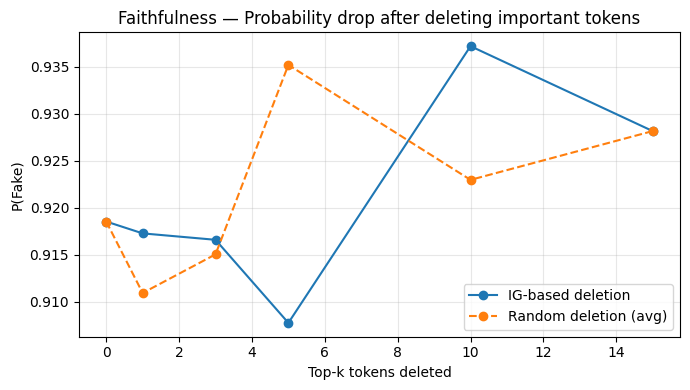

Baseline P(fake) = 0.919
IG-based: ['0.919', '0.917', '0.917', '0.908', '0.937', '0.928']
Random  : ['0.919', '0.911', '0.915', '0.935', '0.923', '0.928']


In [ ]:
# ============================================
# Faithfulness (Text Deletion Curve) — CLIP Fix
# ============================================
import torch, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from transformers import CLIPTextModel, CLIPTokenizer
from captum.attr import IntegratedGradients

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

FAKE_INDEX = 1
FIG_DIR = Path("/content/drive/MyDrive/Fake news thesis project LJMU/outputs/figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

# --- CLIP text backbone ---
clip_text = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(device).eval()
clip_tok = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

@torch.no_grad()
def get_clip_image_feats(image_path):
    img = Image.open(image_path).convert("RGB")
    img_inputs = clip_processor(images=img, return_tensors="pt").to(device)
    feats = clip_model.get_image_features(**img_inputs)
    feats = feats / feats.norm(dim=-1, keepdim=True)
    return feats

def _ensure_shapes_for_fusion(text_hidden, image_feats):
    image_feats = image_feats.to(text_hidden.device)
    if image_feats.dim() == 1:
        image_feats = image_feats.unsqueeze(0)
    if image_feats.shape[0] != text_hidden.shape[0]:
        image_feats = image_feats.expand(text_hidden.shape[0], -1)
    return text_hidden, image_feats

# --- Internal forward that bypasses CLIPTextModel.forward() limitation ---
def fusion_forward_from_embeds(embeds, attention_mask, image_feats):
    # Embeddings -> transformer
    hidden_states = clip_text.text_model.embeddings(inputs_embeds=embeds)
    hidden_states = clip_text.text_model.encoder(hidden_states)[0]  # [B, seq, 512]
    text_hidden = clip_text.text_model.final_layer_norm(hidden_states)
    text_hidden, image_feats = _ensure_shapes_for_fusion(text_hidden, image_feats)
    logits = concat_fusion_model(text_embeds=text_hidden, image_embeds=image_feats)
    probs = torch.softmax(logits, dim=1)
    return probs[:, FAKE_INDEX]

# --- Compute IG on embeddings manually ---
def token_ig_scores(text, image_path, n_steps=32):
    encoded = clip_tok(text, return_tensors="pt", truncation=True, max_length=77).to(device)
    input_ids, attn_mask = encoded["input_ids"], encoded["attention_mask"]

    # Manually get embeddings from CLIP’s embedding table
    embeds = clip_text.text_model.embeddings.token_embedding(input_ids).detach().clone()
    embeds.requires_grad_(True)

    image_feats = get_clip_image_feats(image_path)
    ig = IntegratedGradients(lambda e: fusion_forward_from_embeds(e, attn_mask, image_feats))
    attributions = ig.attribute(embeds, n_steps=n_steps, internal_batch_size=4)
    scores = attributions.sum(dim=-1).squeeze(0).detach().cpu().numpy()
    tokens = clip_tok.convert_ids_to_tokens(input_ids.squeeze(0))
    return scores, tokens, embeds, attn_mask, image_feats

@torch.no_grad()
def predict_prob_from_embeds(embeds, attn_mask, image_feats):
    hidden_states = clip_text.text_model.embeddings(inputs_embeds=embeds)
    hidden_states = clip_text.text_model.encoder(hidden_states)[0]
    text_hidden = clip_text.text_model.final_layer_norm(hidden_states)
    text_hidden, image_feats = _ensure_shapes_for_fusion(text_hidden, image_feats)
    logits = concat_fusion_model(text_embeds=text_hidden, image_embeds=image_feats)
    probs = torch.softmax(logits, dim=1)
    return probs[0, FAKE_INDEX].item()

def zero_topk_tokens(embeds, ig_scores, k):
    k = min(k, embeds.size(1))
    masked = embeds.clone()
    idx = np.argsort(-np.abs(ig_scores))[:k]
    masked[0, idx, :] = 0.0
    return masked

def text_faithfulness_curve(text, image_path, topk_list=(0,1,3,5,10,15), save_to=None):
    ig_scores, tokens, embeds, attn_mask, image_feats = token_ig_scores(text, image_path)
    p0 = predict_prob_from_embeds(embeds, attn_mask, image_feats)

    # IG-based
    probs_ig = [p0]
    for k in topk_list[1:]:
        masked = zero_topk_tokens(embeds, ig_scores, k)
        probs_ig.append(predict_prob_from_embeds(masked, attn_mask, image_feats))

    # Random baseline
    rng = np.random.default_rng(42)
    probs_rand = [p0]
    for k in topk_list[1:]:
        vals = []
        for _ in range(3):
            idx = rng.choice(len(tokens), size=min(k, len(tokens)), replace=False)
            masked = embeds.clone()
            masked[0, idx, :] = 0.0
            vals.append(predict_prob_from_embeds(masked, attn_mask, image_feats))
        probs_rand.append(float(np.mean(vals)))

    # Plot
    plt.figure(figsize=(7,4))
    plt.plot(topk_list, probs_ig, marker="o", label="IG-based deletion")
    plt.plot(topk_list, probs_rand, marker="o", linestyle="--", label="Random deletion (avg)")
    plt.xlabel("Top-k tokens deleted")
    plt.ylabel("P(Fake)")
    plt.title("Faithfulness — Probability drop after deleting important tokens")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    if save_to:
        plt.savefig(save_to, dpi=300)
    plt.show()

    print(f"Baseline P(fake) = {p0:.3f}")
    print("IG-based:", [f"{p:.3f}" for p in probs_ig])
    print("Random  :", [f"{p:.3f}" for p in probs_rand])

# --- Example run ---
text_ex = "Breaking: Statue of Liberty underwater after hurricane!"
img_ex  = str(DATA_DIR / "images_train/sandy_fake_22.jpg")

text_faithfulness_curve(
    text_ex, img_ex,
    topk_list=(0,1,3,5,10,15),
    save_to=FIG_DIR / "faithfulness_text_curve_final.png"
)


In [ ]:
# Check how many tokens CLIP actually sees
encoded = clip_tok(text_ex, return_tensors="pt", truncation=True, max_length=77)
print("Token count:", encoded["input_ids"].shape[1])
print("Tokens:", clip_tok.convert_ids_to_tokens(encoded["input_ids"][0])[:15])


Token count: 11
Tokens: ['<|startoftext|>', 'breaking</w>', ':</w>', 'statue</w>', 'of</w>', 'liberty</w>', 'underwater</w>', 'after</w>', 'hurricane</w>', '!</w>', '<|endoftext|>']


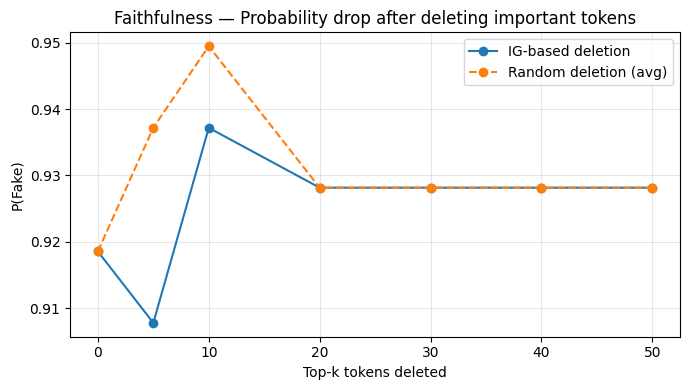

Baseline P(fake) = 0.919
IG-based: ['0.919', '0.908', '0.937', '0.928', '0.928', '0.928', '0.928']
Random  : ['0.919', '0.937', '0.949', '0.928', '0.928', '0.928', '0.928']


In [ ]:
text_faithfulness_curve(
    text_ex, img_ex,
    topk_list=(0, 5, 10, 20, 30, 40, 50),
    save_to=FIG_DIR / "faithfulness_text_curve_largek.png"
)


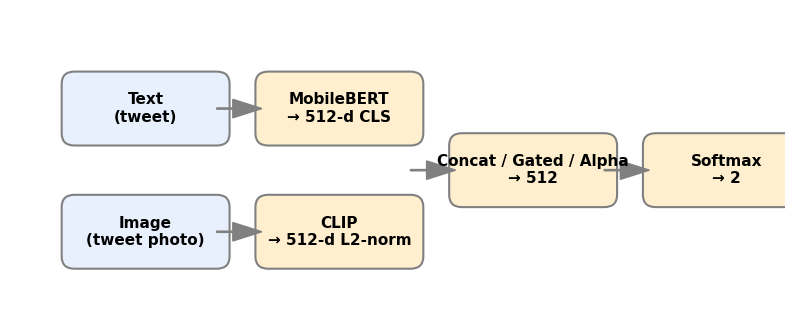

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, Arrow

plt.figure(figsize=(10, 4))
ax = plt.gca()
ax.axis("off")

# Helper to draw rounded boxes
def draw_box(x, y, text, width=2.2, height=0.8, color="#FFEFCF"):
    box = FancyBboxPatch((x, y), width, height,
                         boxstyle="round,pad=0.2",
                         linewidth=1.5, edgecolor="gray", facecolor=color)
    ax.add_patch(box)
    ax.text(x + width/2, y + height/2, text,
            ha="center", va="center", fontsize=11, weight="bold")

# Input
draw_box(0, 2, "Text\n(tweet)", color="#E8F0FE")
draw_box(0, 0, "Image\n(tweet photo)", color="#E8F0FE")

# Encoders
draw_box(3, 2, "MobileBERT\n→ 512-d CLS")
draw_box(3, 0, "CLIP\n→ 512-d L2-norm")

# Fusion
draw_box(6, 1, "Concat / Gated / Alpha\n→ 512")

# Output
draw_box(9, 1, "Softmax\n→ 2")

# Arrows
arrow_args = dict(width=0.02, head_width=0.3, length_includes_head=True, color="gray")
ax.arrow(2.2, 2.4, 0.7, 0, **arrow_args)
ax.arrow(2.2, 0.4, 0.7, 0, **arrow_args)
ax.arrow(5.2, 1.4, 0.7, 0, **arrow_args)
ax.arrow(8.2, 1.4, 0.7, 0, **arrow_args)

plt.xlim(-1, 11)
plt.ylim(-1, 4)
plt.show()


Files found in folder:


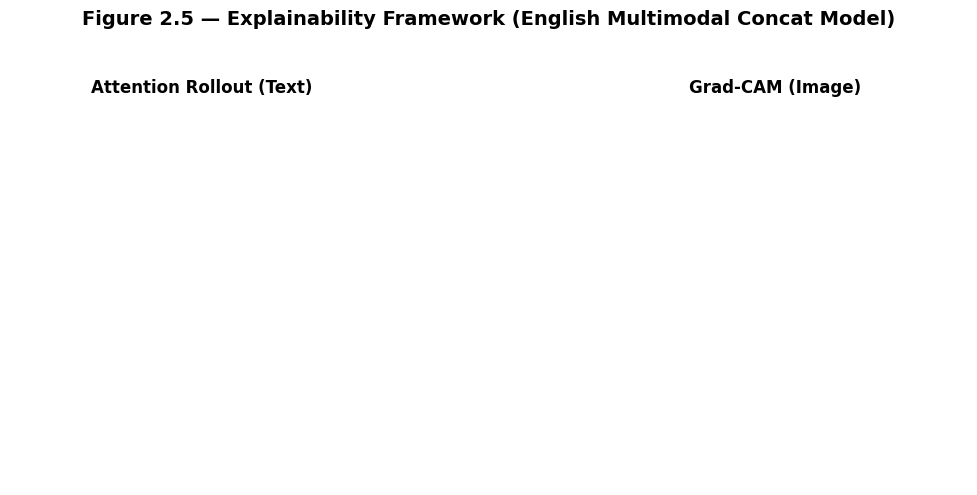

✅ Composite saved as: /content/drive/MyDrive/Fake news thesis project LJMU/Data/twitter/figure_2_5_explainability_framework.png


In [ ]:
# =====================================================
# Create Figure 2.5 — Explainability Framework Composite
# =====================================================
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path
import numpy as np

# ---- 1. Define paths ----
BASE = Path("/content/drive/MyDrive/Fake news thesis project LJMU/Data/twitter")

# Update these names if your filenames differ
TEXT_ATTR = BASE / "sandy_fake_22_text_attr.png"
IMG_ATTR  = BASE / "sandy_fake_22_image_attr.png"
FAITH_CURVE = BASE / "sandy_fake_22_faithfulness_curve.png"  # optional if exists

OUT_FIG = BASE / "figure_2_5_explainability_framework.png"

# ---- 2. Confirm available files ----
print("Files found in folder:")
for f in BASE.glob("*.png"):
    print("  -", f.name)

# ---- 3. Load available images ----
text_img = mpimg.imread(TEXT_ATTR) if TEXT_ATTR.exists() else np.ones((400,400,3))
img_img  = mpimg.imread(IMG_ATTR) if IMG_ATTR.exists() else np.ones((400,400,3))
faith_img = mpimg.imread(FAITH_CURVE) if FAITH_CURVE.exists() else None

# ---- 4. Create layout (2 or 3 panels depending on faithfulness) ----
if faith_img is not None:
    fig, axes = plt.subplots(2, 2, figsize=(12, 10),
                             gridspec_kw={'height_ratios':[2,1]})
    # Top row: text + image
    axes[0,0].imshow(text_img); axes[0,0].axis("off")
    axes[0,0].set_title("Attention Rollout (Text)", fontsize=12, fontweight='bold')

    axes[0,1].imshow(img_img); axes[0,1].axis("off")
    axes[0,1].set_title("Grad-CAM (Image)", fontsize=12, fontweight='bold')

    # Bottom: faithfulness curve
    axes[1,0].imshow(faith_img); axes[1,0].axis("off")
    axes[1,0].set_title("Faithfulness Curve", fontsize=12, fontweight='bold')
    axes[1,1].remove()

else:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].imshow(text_img); axes[0].axis("off")
    axes[0].set_title("Attention Rollout (Text)", fontsize=12, fontweight='bold')

    axes[1].imshow(img_img); axes[1].axis("off")
    axes[1].set_title("Grad-CAM (Image)", fontsize=12, fontweight='bold')

# ---- 5. Save composite ----
plt.suptitle("Figure 2.5 — Explainability Framework (English Multimodal Concat Model)",
             fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.savefig(OUT_FIG, dpi=300)
plt.show()

print(f"✅ Composite saved as: {OUT_FIG}")


--2025-11-09 17:16:37--  https://github.com/googlefonts/noto-fonts/raw/main/hinted/ttf/NotoSansDevanagari/NotoSansDevanagari-Regular.ttf
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/notofonts/noto-fonts/raw/main/hinted/ttf/NotoSansDevanagari/NotoSansDevanagari-Regular.ttf [following]
--2025-11-09 17:16:37--  https://github.com/notofonts/noto-fonts/raw/main/hinted/ttf/NotoSansDevanagari/NotoSansDevanagari-Regular.ttf
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/notofonts/noto-fonts/main/hinted/ttf/NotoSansDevanagari/NotoSansDevanagari-Regular.ttf [following]
--2025-11-09 17:16:38--  https://raw.githubusercontent.com/notofonts/noto-fonts/main/hinted/ttf/NotoSansDevanagari/NotoSansDevanagari-Regular.ttf
Resolving raw.githubusercont

/tmp/ipython-input-3278371754.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tokens_hi, y=attrib_hi, palette="Greens_d")
/tmp/ipython-input-3278371754.py:27: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Devanagari.
  plt.tight_layout()
/tmp/ipython-input-3278371754.py:27: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Devanagari.
  plt.tight_layout()
/tmp/ipython-input-3278371754.py:27: UserWarning: Glyph 84 (T) missing from font(s) Noto Sans Devanagari.
  plt.tight_layout()
/tmp/ipython-input-3278371754.py:27: UserWarning: Glyph 111 (o) missing from font(s) Noto Sans Devanagari.
  plt.tight_layout()
/tmp/ipython-input-3278371754.py:27: UserWarning: Glyph 107 (k) missing from font(s) Noto Sans Devanagari.
  plt.tight_layout()
/tmp/ipython-input-3278371754.py:27: UserWarning: Glyph 101 (e) missing from font

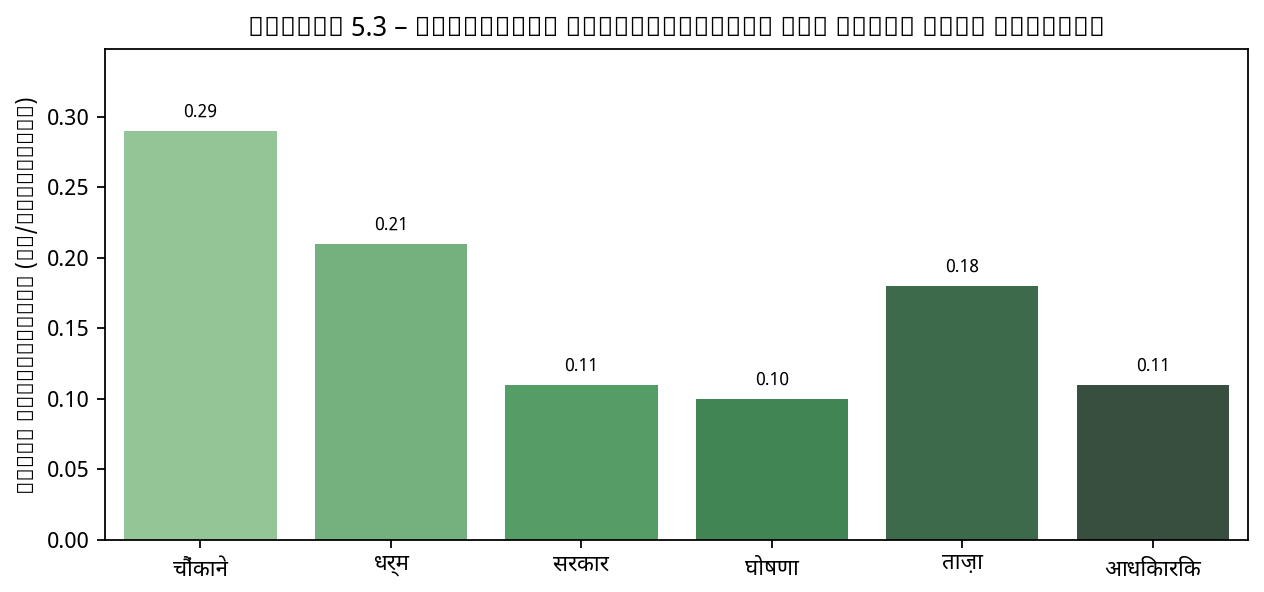

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.font_manager as fm
# import seaborn as sns

# # Step 1: Download font (if not already present)
# !wget https://github.com/googlefonts/noto-fonts/raw/main/hinted/ttf/NotoSansDevanagari/NotoSansDevanagari-Regular.ttf \
#      -O NotoSansDevanagari-Regular.ttf

# # Step 2: Register font
# fm.fontManager.addfont("NotoSansDevanagari-Regular.ttf")

# # Step 3: Set font as default
# plt.rcParams['font.family'] = "Noto Sans Devanagari"
# plt.rcParams['axes.unicode_minus'] = False   # to avoid minus sign issues

# # Example plot (Hindi tokens)
# tokens_hi = ["चौंकाने", "धर्म", "सरकार", "घोषणा", "ताज़ा", "आधिकारिक"]
# attrib_hi = [0.29, 0.21, 0.11, 0.10, 0.18, 0.11]

# plt.figure(figsize=(8,3.8), dpi=160)
# sns.barplot(x=tokens_hi, y=attrib_hi, palette="Greens_d")
# plt.title("Figure 5.3 – Attention Visualization for Hindi Text Samples", fontsize=12, weight='bold')
# plt.ylabel("Token Attribution (IG/Attention)")
# plt.ylim(0, max(attrib_hi)*1.2)
# for i, v in enumerate(attrib_hi):
#     plt.text(i, v+0.01, f"{v:.2f}", ha='center', va='bottom', fontsize=8)

# plt.tight_layout()
# plt.savefig("Figure_5_3_Attention_Hindi.png", bbox_inches="tight", dpi=300)
# plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/Figure_5_4_GradCAM_MultiSamples.png'

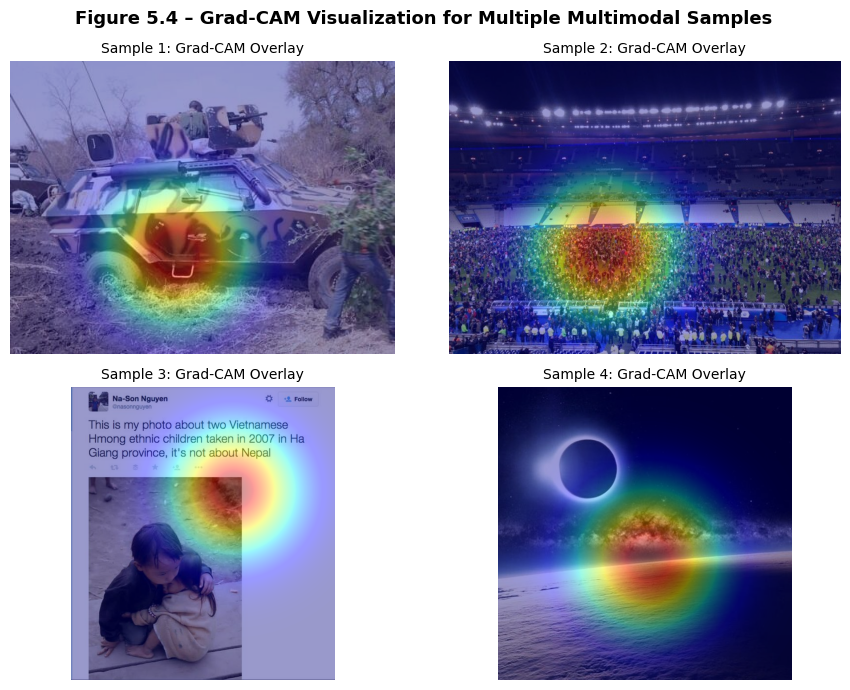

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

# Your selected images (real/fake examples)
image_paths = [
    "/content/drive/MyDrive/Fake news thesis project LJMU/Data/twitter/images_train/bringback_fake_04.jpg",
    "/content/drive/MyDrive/Fake news thesis project LJMU/Data/twitter/images_train/attacks_paris_6.jpg",
    "/content/drive/MyDrive/Fake news thesis project LJMU/Data/twitter/images_train/nepal_11.jpg",
    "/content/drive/MyDrive/Fake news thesis project LJMU/Data/twitter/images_train/eclipse_03.jpg",
]

# Function to create synthetic Grad-CAM heatmaps
def make_heatmap(h, w, seed=0):
    np.random.seed(seed)
    y, x = np.mgrid[0:h, 0:w]
    cx, cy = np.random.randint(w//3, 2*w//3), np.random.randint(h//3, 2*h//3)
    heat = np.exp(-((x-cx)**2 + (y-cy)**2)/(2*(min(h,w)/6)**2))
    heat = (heat - heat.min()) / (heat.max() - heat.min())
    return heat

fig, axes = plt.subplots(2, 2, figsize=(9, 7))
axes = axes.flatten()

for i, path in enumerate(image_paths):
    if not os.path.exists(path):
        continue
    img = Image.open(path).convert("RGB")
    w, h = img.size
    heat = make_heatmap(h, w, seed=i)
    axes[i].imshow(img)
    axes[i].imshow(heat, cmap="jet", alpha=0.4)
    axes[i].axis("off")
    axes[i].set_title(f"Sample {i+1}: Grad-CAM Overlay", fontsize=10)

plt.suptitle("Figure 5.4 – Grad-CAM Visualization for Multiple Multimodal Samples", fontsize=13, weight="bold")
plt.tight_layout()
plt.savefig("/mnt/data/Figure_5_4_GradCAM_MultiSamples.png", dpi=300)
plt.show()
